<center><h1>Fine-tuning Gemma 2 for Spanish QA using SQUAD-es and MLQA</h1></center>
<center><h2>Exploratory Data Analysis Notebook</h2></center>

In this notebook we will load the datasets, explore their data and prepare (clean and harmonize) them for training.  

After completing all steps in the notebook, the clean datasets will be exported to disk for use in the next steps on the project (preprocessing and training).  

> **NOTE:** The train and validation splits of the **SQuAD** dataset will be used as train and val splits, and we will explore and clean them to improve data quality to enhance our models performance. **MLQA** and **XQuAD** however, will be used as unseen data (test sets, heldout) and will be used for final evaluation and benchmarking, as such we will explore and format (harmonize) them, but no modifications will be done regardless of what we find, so that we can fairly compare our scores in them against others.  

# Table of Contents

- [1. Setup](#1-setup)
- [2. Load Datasets](#2-load-datasets)
- [3. Discovery](#3-discovery)
- [4. Harmonize](#4-harmonize)
- [5. Clean & Validate](#5-clean--validate)
    - [5.1. Auxiliary Functions](#5-1-auxiliary-functions)
    - [5.2. SQuAD Train](#5-2-squad-train)
    - [5.3. SQuAD Val](#5-3-squad-val)
    - [5.4. MLQA Test](#5-4-mlqa-test)
    - [5.5. XQuAD Test](#5-5-xquad-test)
    - [5.6. Shared QA Removal](#5-6-shared-qa-removal)
- [6. Analysis & Exploration](#6-analysis--exploration)
    - [6.1. Context Length](#6-1-context-length)
    - [6.2. Question Length](#6-2-question-length)
    - [6.3. Answer Length](#6-3-answer-length)
    - [6.4. Number of Questions per Context](#6-4-number-of-questions-per-context)
    - [6.5. Number of Answers per Question](#6-5-number-of-answers-per-question)
    - [6.6. Flagged Entries Removal](#6-6-flagged-entries-removal)
- [7. Summary](#7-summary)
- [8. Export Datasets](#8-export-datasets)
- [9. Citations & References](#9-citations--references)

# 1. Setup

Here we will import all necessary packages/libraries used during the execution of this notebook:

In [ ]:
# Standard imports
import os
import random
import re
import subprocess
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer

For consistency, whether in notebooks or scripts, paths will be referenced from the project root folder.  
To make the notebook compatible, we will set its working directory to the project root.

In [2]:
# Set project root directory as working directory for path consistency
os.chdir(Path('../').resolve())

Because of the length of the content of some cells (big pieces of text), we will disable the limitation of width to be displayed with pandas, so that we can read the text without truncation while exploring.

In [3]:
# Optios commented out for online display, uncomment for full display
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

Because some of the checks done required the tokenized input, we will define the tokenizers we plan to use so that they are available for checks down the line:

> **IMPORTANT!** Gemma 2 models (and their tokenizers) have gated access.   
To be able to use them follow these instructions: [Hugging Face: Accessing Private/Gated Models](https://huggingface.co/docs/transformers.js/en/guides/private).

In [4]:
tokenizerS = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")  # Basic multilingual BERT (mBERT) - Basic baseline
tokenizerM = AutoTokenizer.from_pretrained("xlm-roberta-base")  # XLM-R multilingual base model - Moderate baseline
tokenizerL = AutoTokenizer.from_pretrained("xlm-roberta-large")  # Strong baseline for QA in multiple languages
tokenizerG2 = AutoTokenizer.from_pretrained("google/gemma-2-2b") # Gemma 2 2B tokenizer
tokenizerG9 = AutoTokenizer.from_pretrained("google/gemma-2-9b") # Gemma 2 9B tokenizer

tokenizers = {"S":tokenizerS, "M":tokenizerM, "L":tokenizerL, "G2":tokenizerG2, "G9":tokenizerG9}

# 2. Load Datasets

At the time of writing this, neither the main dataset used for training and evaluation (translated SQuAD) nor the MLQA dataset can be directly loaded from Hugging Face due to not having been converted to Parquet format (Pull Request pending).  

Because of that we will need to download the datasets from their respective GitHub repositories. A make command is available to get the necessary files.  

Note that XQuAD can be directly loaded from HF.  

The following cell defines the paths to the necessary files and executes the make command if there is any missing.  

In [5]:
# Files needed for raw dataset loading
squad_folder = Path('data/squad_es')
mlqa_folder = Path('data/mlqa')
xquad_folder = Path('data/xquad') # XQuAD is loaded from Hugging Face datasets, no raw files needed, but folder defined for exports
squad_es_raw_train_path = squad_folder / 'train-v1.1-es_small.json'
squad_es_raw_dev_path = squad_folder / 'dev-v1.1-es_small.json'
mlqa_es_raw_dev_path = mlqa_folder / 'dev-context-es-question-es.json'
mlqa_es_raw_test_path = mlqa_folder / 'test-context-es-question-es.json'

raw_files = [squad_es_raw_train_path, squad_es_raw_dev_path,
             mlqa_es_raw_dev_path, mlqa_es_raw_test_path]

for file in raw_files:
    if not file.is_file():
        try:
            print(f'Required raw data file not found: {file}')
            print('Executing "download_data" commands...')
            subprocess.run(["make", "download_data"])
            print('Data download complete.')
            break
        except subprocess.CalledProcessError as e:
            print(f'\nProcess failed with exit code {e.returncode}')
            print('=== STDOUT ===')
            print(e.stdout)
            print('\n=== STDERR ===')
            print(e.stderr)
print('Files ready.')

Files ready.


Once the necessary files are available, we can load the datasets:

In [6]:
# Load datasets

# SQuAD translated to Spanish (from local files)
raw_squad_es = load_dataset(
    "json",
    data_files={
        "train": str(squad_es_raw_train_path),
        "validation": str(squad_es_raw_dev_path)
    }
)

# MLQA Spanishs subset (from local files)
raw_mlqa_es = load_dataset(
    "json",
    data_files={
        "dev": str(mlqa_es_raw_dev_path), # small set for testing or exploring
        "test": str(mlqa_es_raw_test_path) # main test set, for evaluation
    }
)

# XQuAD Spanish subset (from Hugging Face)
raw_xquad_es = load_dataset("google/xquad", "xquad.es")

# 3. Discovery

With the datasets loaded, we need to assert what kind of structure they have so we know how to access the information inside.  

Lets check each dataset starting with the translated SQuAD:

In [7]:
raw_squad_es

DatasetDict({
    train: Dataset({
        features: ['version', 'data'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['version', 'data'],
        num_rows: 1
    })
})

In [8]:
raw_squad_es["train"].features

{'version': Value('string'),
 'data': List({'title': Value('string'), 'paragraphs': List({'context': Value('string'), 'qas': List({'question': Value('string'), 'answers': List({'text': Value('string'), 'answer_start': Value('int64')}), 'id': Value('string')})})})}

As we can see, we are dealing with a DatasectDict containing two Datasets 'train' and 'validation', which will be used as train and val splits respectively.  
Inside each dataset we have two features with 1 value (row):
- 'version': Refers to the SQuAD dataset version, in our case v1.1
- 'data': This single value actually holds all the data in a very nested format.

The data in each dataset is stored in this way:

- 'train' (Dataset)
    - data (list of dicts):
        - title (str)
        - paragraphs (list of dicts):
            - context (str)
            - qas (list of dicts):
                - question (str)
                - id (str)
                - answers (list of dicts):
                    text (str)
                    answer_start (int)

So for each 'title' (topic) there can be one or more paragraphs, and for each paragraphs there can be one or more questions, and for each question there can be one or more answers.  

Now lets check MLQA:

In [9]:
raw_mlqa_es

DatasetDict({
    dev: Dataset({
        features: ['version', 'data'],
        num_rows: 1
    })
    test: Dataset({
        features: ['version', 'data'],
        num_rows: 1
    })
})

In [10]:
raw_mlqa_es["dev"].features

{'version': Value('float64'),
 'data': List({'title': Value('string'), 'paragraphs': List({'context': Value('string'), 'qas': List({'question': Value('string'), 'answers': List({'text': Value('string'), 'answer_start': Value('int64')}), 'id': Value('string')})})})}

MLQA has the same nested format as SQuAD, the only differences being:
- The datasets inside the main DatasetDict are called 'dev' and 'test'. Where 'dev' is a very small split that either will not be used, or will be used for exploration purposes, while 'test' will be the actual dataset that will be used as one of our two held-out 'test' sets.
- Version is stored as float64 instead of str (SQuAD)

But from the perspective of accesing the data from the individual datasets, it has the same format as SQuAD.  

Finally, lets check the XQuAD dataset:

In [11]:
raw_xquad_es

DatasetDict({
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers'],
        num_rows: 1190
    })
})

In [12]:
raw_xquad_es["validation"].features

{'id': Value('string'),
 'context': Value('string'),
 'question': Value('string'),
 'answers': {'text': List(Value('string')),
  'answer_start': List(Value('int32'))}}

XQuAD, unlike SQuAD and MLQA, has a flat format.  
Like with the others, it is a DatasetDict, but this time only one dataset called 'validation' is stored in it, and this dataset has 4 features:
- 'validation' (dataset)
    - context (str)
    - question (str)
    - answers (dict):
        - 'text' (list of str)
        - 'answer_start' (list of int32)

The dataset has 1190 entries (rows) which each entry holding one QA sample that includes all information (context, question, id and answers), which can possibly have more than one answer per question ('text' and 'answer_start' are lists).  

As opposed to the other datasets, there is no 'title' or topic segregating the questions, and if there are groups of questions with the same context they are not grouped together either.  

# 4. Harmonize

To facilitate access to the samples during the rest of this notebook, in this section we will transform SQuAD and MLQA datasets to the same format as XQuAD in order to:
- Get rid of the deep nested structure which difficults data access
- Meet the standard format usually expected by HF pipelines for QA (matches the XQuAD format)

First, we will define a function to change the SQuAD format style (used by both SQuAD and MLQA) to the desired format (XQuAD):

In [13]:
def harmonize_squad_format(dataset):
    """
    Harmonize a HF SQuAD-style enforcing consistent types.
    Final dataset will have 4 features: id (str), context (str), question (str),
    answers (dict with 'text' (list of str) and 'answer_start' (list of int32)).
    """
    records = []
    for title in dataset["data"][0]:
        for paragraph in title["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                answer_starts = []
                texts = []
                for an in qa["answers"]:
                    answer_starts.append(np.int32(an["answer_start"]))
                    texts.append(str(an["text"]))
                records.append({
                    "id": str(qa["id"]),
                    "context": str(context),
                    "question": str(qa["question"]),
                    "answers": {"text": texts, "answer_start": answer_starts},
                })
    return Dataset.from_list(records)

Now, we can apply the function to each dataset inside the DatasetDict objects, un-nesting the XQuAD Dataset form its DatasetDict too.  

This way we will have 4 Dataset objects, with the same format.  
For easier access we will drop the 'es' refering to spanish, as there are no other languages involved, and sufixes will be added to clarify their function in our project:
- _train: used for training
- _val: used for evaluation during training and finetuning
- _test: held out sets for final evaluation and benchmarking

In [14]:
squad_train = harmonize_squad_format(raw_squad_es["train"])
squad_val = harmonize_squad_format(raw_squad_es["validation"])
mlqa_test = harmonize_squad_format(raw_mlqa_es["test"])
xquad_test= raw_xquad_es["validation"]

Before moving forward lets validate the structure of the datasets:

In [15]:
print(squad_train)
print(squad_val)
print(mlqa_test)
print(xquad_test)

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 46260
})
Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 6583
})
Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 5253
})
Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 1190
})


All of them are Dataset objects, with the same 4 features ['id', 'context', 'question', 'answers'].  

Number of samples originally included in the datasets:  
- **Translated SQuAD v1.1 train split**: 46260 samples
- **Translated SQuAD v1.1 validation split**: 6583 samples
- **MLQA spanish-spanish subset, test split**: 5253 samples
- **XQuAD spanish subset**: 1190 samples

And lets validate also the data types of the stored values to make sure they match:

In [16]:
print(squad_train.features)
print(squad_val.features)
print(mlqa_test.features)
print(xquad_test.features)

{'id': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'answer_start': List(Value('int32')), 'text': List(Value('string'))}}
{'id': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'answer_start': List(Value('int32')), 'text': List(Value('string'))}}
{'id': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'answer_start': List(Value('int32')), 'text': List(Value('string'))}}
{'id': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'text': List(Value('string')), 'answer_start': List(Value('int32'))}}


All 4 datasets match in format and data types.

# 5. Clean & Validate

In this section we will procede to explore more deeply the content of the datasets, and get rid of unwanted entries.  

Each dataset will be handled individually in their own subsection, but all of them will follow the same process:
- Check for duplicates
- Check for empty values
- Check for non-valid characters
- Assert answer validity (answer is contained in context)
- Assert tokenized contex meets input size limit

_Note: For easier handling, Dataset's will be converted to Pandas DataFrames._

## 5.1 Auxiliary Functions

Before we start, as this process will have a combination of individual repetitive steps, with manual intervention when needed, we will define a series of auxiliary functions to automate the repetitive part.

In [17]:
def check_column_unique(df, col):
    """Check if there are duplicate entries in a dataframe column."""
    n_dup = df.shape[0] - df[col].nunique()
    if n_dup:
        print(f"{n_dup} duplicate entries in '{col}'!")
    else:
        print(f"No duplicates in '{col}'.")

In [18]:
def check_multi_column_unique(df, cols):
    """Check if there are duplicate combinations of entries from multiple dataframe columns."""
    temp_df = df.copy()
    # answers contains dicts, non-hashable, so convert to str for duplication check
    if "answers" in cols:
        temp_df["answers"] = temp_df["answers"].apply(str) # Order guaranteed due to df source being HF Dataset
    dup_count = temp_df.duplicated(subset=cols).sum()
    if dup_count:
        print(f"{dup_count} duplicate row(s) for columns {cols}!")
    else:
        print(f"No duplicate combinations for columns {cols}.")

In [19]:
def check_null_or_empty(df, col):
    """Check for null or empty entries in a dataframe column of type string/object."""
    mask = df[col].isnull() | (df[col] == "")
    count = mask.sum()
    if count:
        print(f"{count} null or empty entries in '{col}'!")
    else:
        print(f"No null or empty values in '{col}'.")

In [20]:
def check_null_or_negative(df, col):
    """Check for null, empty, or negative entries in a dataframe column of numeric type."""
    mask = df[col].isnull() | (df[col] == "") | (df[col] < 0)
    count = mask.sum()
    if count:
        print(f"{count} null, empty, or negative entries in '{col}'!")
    else:
        print(f"No null, empty, or negative values in '{col}'.")

In [21]:
# Define a filter for "universal bad chars"
# It looks for some non-printable ASCII control characters and the replacement character '�':
# Between ASCII code \x00 and \x08 (null byte through backspace)
# \x0b (vertical tab)
# \x0c (form feed)
# Between \x0e and \x1f (various ASCII control chars)
# \x7f (ASCII DEL control character)
def has_bad_char(s):
    # Control chars (Unicode categories: Cc, Cf, Cs, Co, Cn)
    return bool(re.search(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f]', s)) or '�' in s

def check_bad_chars(df, cols):
    """Check for bad/universal control characters in specified dataframe columns of type string/object."""
    for col in cols:
        count = df[col].apply(has_bad_char).sum()
        print(f"{count} rows in '{col}' with bad chars.")

In [22]:
def factory_no_tokens(tokenizer):
    """Create a function to check if a string has no tokens when tokenized by the given tokenizer."""
    def no_tokens(s):
        tokens = tokenizer.tokenize(s)
        return len(tokens) == 0
    return no_tokens

def check_no_tokens(df, cols, tokenizers):
    """Check for rows in specified dataframe columns that have no tokens when tokenized by given tokenizers."""
    for col in cols:
        for name, tokenizer in tokenizers.items():
            fn = factory_no_tokens(tokenizer)
            count = df[col].apply(fn).sum()
            print(f"{count} '{col}' rows flagged (no tokens) for tokenizer {name}")

In [23]:
def factory_unk_tokens(tokenizer):
    """Create a function to check if a string has UNK tokens when tokenized by the given tokenizer."""
    def unk_tokens(s):
        tokens = tokenizer.tokenize(s)
        unk_count = tokens.count(tokenizer.unk_token)
        return (unk_count > 0) 
    return unk_tokens

def check_unk_tokens(df, cols, tokenizers):
    """Check for rows in specified dataframe columns that have UNK tokens when tokenized by given tokenizers."""
    for col in cols:
        for name, tokenizer in tokenizers.items():
            fn = factory_unk_tokens(tokenizer)
            count = df[col].apply(fn).sum()
            print(f"{count} '{col}' rows flagged (UNK tokens) for tokenizer {name}")

In [24]:
def check_input_truncation(df, tokenizers, context_col="context", question_col="question"):
    """Check for rows that would be truncated by the tokenizers when encoding context and question."""
    for name, tokenizer in tokenizers.items():
        max_len = min(tokenizer.model_max_length, 8192) # Gemma 2 can handle up to 8192 tokens, but .model_max_length in their tokenizers is not set (returns infinity)
        over_max = df.apply(
            lambda x: len(tokenizer(x[question_col], x[context_col], truncation=False, add_special_tokens=True)['input_ids']) > max_len, axis=1
        )
        count = over_max.sum()
        print(f"{count} rows would be truncated for tokenizer {name} (limit {max_len} tokens)")

In [25]:
def explode_answers_dict(df):
    """Explode the 'answers' column (dict) of a dataframe into separate 'answer_start' and 'answer_text' columns."""
    df = df.copy()
    df['answer_start'] = df['answers'].apply(lambda x: x['answer_start'])
    df['answer_text'] = df['answers'].apply(lambda x: x['text'])
    df.drop(['answers'], axis=1, inplace=True)
    return df

def check_answers_len(df):
    """Check that the lengths of answer_start and answer_text lists match in each row of the dataframe."""
    mask = df.apply(lambda x: len(x['answer_start']) == len(x['answer_text']), axis=1)
    count = (~mask).sum()
    if count:
        print(f"{count} rows where answer_start/text lists don't match!")
        return False
    else:
        return True

def explode_answers_lists(df):
    """Explode the lists in 'answer_start' and 'answer_text' columns into separate rows."""
    df = df.copy()
    df['answer_pair'] = df.apply(lambda x: (list(zip(x['answer_start'], x['answer_text']))), axis=1)
    df = df.explode('answer_pair')
    df['answer_start'] = df['answer_pair'].apply(lambda x: x[0])
    df['answer_text'] = df['answer_pair'].apply(lambda x: x[1])
    df = df.drop(columns=['answer_pair'])
    return df

def explode_answers(df):
    """Explode the 'answers' column of a dataframe into separate rows for each answer."""
    df = df.copy()
    df = explode_answers_dict(df)
    if not check_answers_len(df):
        raise ValueError("Cannot explode answers: answer_start and answer_text lists have different lengths.")
    df = explode_answers_lists(df)
    return df

def unexplode_answers(df):
    """Unexplode the 'answer_start' and 'answer_text' columns of a dataframe back into lists in an 'answers' column."""
    df = df.copy()
    grouped = df.groupby(['id', 'context', 'question'])
    records = []
    for (id_, context, question), group in grouped:
        answer_starts = group['answer_start'].tolist()
        answer_texts = group['answer_text'].tolist()
        records.append({
            'id': id_,
            'context': context,
            'question': question,
            'answers': {
                'answer_start': answer_starts,
                'text': answer_texts
            }
        })
    return pd.DataFrame.from_records(records)

In [26]:
def is_answer_in_context(row):
    """Check that answer_text is actually found in context at the specified answer_start position (use after exploding)."""
    context = row['context']
    answer_text = row['answer_text']
    answer_start = row['answer_start']
    
    # Check if answer_start is within the bounds of the context
    if answer_start < 0 or answer_start + len(answer_text) > len(context):
        return False
    
    # Extract the substring from context at the specified position
    extracted_text = context[answer_start:answer_start + len(answer_text)]
    
    # Compare the extracted text with the answer_text
    return extracted_text == answer_text

def check_answer_in_context(df):
    """Check that answer_text is found in context at answer_start for each row of the dataframe (use after exploding)."""
    count = (~df.apply(is_answer_in_context, axis=1)).sum()
    if count:
        print(f"{count} rows where answer_text isn't found at answer_start in context.")
    else:
        print("All answers properly mapped into context.")

## 5.2 SQuAD Train

We will start by converting the HF Dataset into a Pandas Dataframe, for easier handling and exploration.

In [27]:
squad_train_df = squad_train.to_pandas()

Now lets confirm the expected columns and dtypes, with the `.info()` method to check what columns and dtypes there are in the dataframe.  
We will also observe a few samples to see if the information is presented as expected.

In [28]:
squad_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46260 entries, 0 to 46259
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46260 non-null  object
 1   context   46260 non-null  object
 2   question  46260 non-null  object
 3   answers   46260 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


In [29]:
squad_train_df.head()

,id,context,question,answers
0,5733be284776f41900661182,"Arquitectónicamente, la escuela tiene un carác...",¿A quién acudió la Virgen María supuestamente ...,"{'answer_start': [572], 'text': ['Santa Bernad..."
1,5733be284776f41900661180,"Arquitectónicamente, la escuela tiene un carác...",La Basílica del Sagrado Corazón en Notre Dame ...,"{'answer_start': [88], 'text': ['el edificio p..."
2,5733be284776f41900661181,"Arquitectónicamente, la escuela tiene un carác...",¿Qué es la Gruta de Notre Dame?,"{'answer_start': [430], 'text': ['un lugar mar..."
3,5733be284776f4190066117e,"Arquitectónicamente, la escuela tiene un carác...",¿Qué se encuentra en la parte superior del edi...,"{'answer_start': [114], 'text': ['una estatua ..."
4,5733bf84d058e614000b61bf,"Como en la mayoría de las otras universidades,...",¿Con qué frecuencia se publica el Juggler de N...,"{'answer_start': [504], 'text': ['dos veces']}"


There are 4 columns with 46260 entries, matching the format expected after our harmonizing steps, all of them being *objects* dtype as three are strings and the last column 'answers' is a dict.  
No null values are present at top level, but 'answers' contains a nested structure and we will need to analyse the content to be sure. 

During the cleaning and validation process, we may have to drop certain entries (samples), and just in case we will save the number of entries we have at the beginning into a variable for later comparison.

In [30]:
original_squad_train_len = squad_train_df.shape[0]

Check for duplicate 'ID' values:

In [31]:
check_column_unique(squad_train_df, "id")

No duplicates in 'id'.


Check for unique combination of 'context'-'question'-'answers' values:

In [32]:
check_multi_column_unique(squad_train_df, ["context", "question", "answers"])

71 duplicate row(s) for columns ['context', 'question', 'answers']!


We have found 71 duplicates where there was already the exact same entry with a different 'ID', we will drop those duplicated entries:

In [33]:
squad_train_df["answers_str"] = squad_train_df["answers"].apply(str)
before_len = len(squad_train_df)
squad_train_df.drop_duplicates(subset=['context', 'question', 'answers_str'], inplace=True)
print(f"Dropped {before_len - len(squad_train_df)} duplicate rows based on context-question-answers triplets.")
squad_train_df.drop(['answers_str'], axis=1, inplace=True)

Dropped 71 duplicate rows based on context-question-answers triplets.


Validation of unique combination of 'context'-'question'-'answers':

In [34]:
check_multi_column_unique(squad_train_df, ["context", "question", "answers"])

No duplicate combinations for columns ['context', 'question', 'answers'].


Check for unique combination of 'context'-'question' values:

In [35]:
check_multi_column_unique(squad_train_df, ["context", "question"])

24 duplicate row(s) for columns ['context', 'question']!


We have found 24 duplicated entries where there was already an entry with the same 'context'-'question' but with a different 'answers' value. They could still be valid entries (a different but correct answer, worded differently or with a different valid answer). As the number of entries is small, we will manually check those entries:

In [36]:
squad_train_df[squad_train_df.duplicated(subset=['context', 'question'], keep=False)]

,id,context,question,answers
942,56cf5433aab44d1400b88ff1,La música de Chopin fue utilizada en el ballet...,¿Quién orquestó Chopiniana?,"{'answer_start': [116], 'text': ['Alexander Gl..."
945,56d3a9bb2ccc5a1400d82ddc,La música de Chopin fue utilizada en el ballet...,¿Quién orquestó Chopiniana?,"{'answer_start': [116], 'text': ['Alexander Gl..."
977,56cfeae2234ae51400d9c0b9,"El funeral, celebrado en la Iglesia de la Made...",¿Dónde se celebró el funeral de Chopin?,"{'answer_start': [28], 'text': ['Iglesia de la..."
979,56d38ba459d6e414001466e7,"El funeral, celebrado en la Iglesia de la Made...",¿Dónde se celebró el funeral de Chopin?,"{'answer_start': [25], 'text': ['la Iglesia de..."
3174,56cff91b234ae51400d9c1bb,El budismo (en sánscrito: र र ्; dharma; en sá...,¿Qué tipo de religión es el budismo?,"{'answer_start': [93], 'text': ['no teísta']}"
3177,56d0c933234ae51400d9c43c,El budismo (en sánscrito: र र ्; dharma; en sá...,¿Qué tipo de religión es el budismo?,"{'answer_start': [84], 'text': ['religión no t..."
3314,56d0ac6c234ae51400d9c414,El concepto de liberación (nirvāṇa) - el objet...,¿Cuál es el objetivo del camino budista?,"{'answer_start': [15], 'text': ['liberación']}"
3317,56d1d7cbe7d4791d00902292,El concepto de liberación (nirvāṇa) - el objet...,¿Cuál es el objetivo del camino budista?,"{'answer_start': [27], 'text': ['nirvāṇa']}"
5386,56de0fef4396321400ee2586,Iluminación o iluminación es el uso deliberado...,¿Las lámparas y los accesorios son una forma d...,"{'answer_start': [133], 'text': ['fuentes de l..."
5388,56de1377cffd8e1900b4b5b3,Iluminación o iluminación es el uso deliberado...,¿Las lámparas y los accesorios son una forma d...,"{'answer_start': [0], 'text': ['Iluminación']}"


After careful evaluation, most cases are valid duplicates (same answer in a different part of the paragraph, different wording...), with only a few exceptions.  

These are those entries that will be dropped and the reason for it:  
- Entry (id **56d3a9bb2ccc5a1400d82ddc**) will be dropped because of another almost identical entry, the only difference being than in this one there is a trailing dot in the answer ('Alexander Glazunov.')
- Entry (id **5725b53c38643c19005acb99**) will be dropped too for the same reason ('sur de Fujian.')
- Entries (id **5726f08ef1498d1400e8f07e**) and (id **5726f08ef1498d1400e8f07f**) have the same context and question, and neither answer make sense, probably due to a mistake in the automated translation, as such both will be dropped.
- Entry (id **57327da60fdd8d15006c6b28**) has a wrong answer, the duplicated instance is correct, so this one will be dropped.
- Entries (id **57327ed206a3a419008aca8c**) and (id **57327ed206a3a419008aca8d**) share context and question, but both answers are wrong. Both will be dropped

And besides those listed, two more cases need to be mentioned that will require further action besides just dropping them:
- Entries (id **572857f42ca10214002da2ac**), (id **572857f42ca10214002da2ad**) and (id **572c010e750c471900ed4c70**) share the same context and question, but the first part of the context is contradictory as it contradicts itself, probably another case of wrong translation. As such not only these entries need to be dropped given that the answer is the wrong part, but other instances of this same context (different questions) need to be checked if they exist.
- Entries (id **5730f1c3e6313a140071cad6**), (id **5730f1c3e6313a140071cad8**) and (id **5730f1c3e6313a140071cad9**) share the same context and question, but the context talks about letters from the russian alphabet, and the question asks for a symbol that does not appear in the text, probably a machine translation artifact. As with the previous case, these entries need to be dropped and others with the same context need to be evaluated.

In [37]:
squad_train_df[squad_train_df['context'] == squad_train_df[squad_train_df["id"] == "572857f42ca10214002da2ac"]['context'].iloc[0]]

,id,context,question,answers
33273,572857f42ca10214002da2ac,El panteísmo sostiene que Dios es el universo ...,¿Qué es el panteísmo?,"{'answer_start': [26], 'text': ['Dios es el un..."
33274,572857f42ca10214002da2ad,El panteísmo sostiene que Dios es el universo ...,¿Qué es el panteísmo?,"{'answer_start': [108], 'text': ['Dios contien..."
33275,572857f42ca10214002da2ae,El panteísmo sostiene que Dios es el universo ...,¿Qué es la Cábala?,"{'answer_start': [461], 'text': ['misticismo j..."
33276,572857f42ca10214002da2af,El panteísmo sostiene que Dios es el universo ...,¿Quién es el fundador del judaísmo jasídico?,"{'answer_start': [600], 'text': ['el Baal Shem..."
33277,572c010e750c471900ed4c70,El panteísmo sostiene que Dios es el universo ...,¿Qué es el panteísmo?,"{'answer_start': [26], 'text': ['Dios es el un..."
33278,572c010e750c471900ed4c71,El panteísmo sostiene que Dios es el universo ...,¿Quién fue el fundador del judaísmo jasídico?,"{'answer_start': [600], 'text': ['el Baal Shem..."


No need to drop the rest, as their answers are in a different part of the text which does not seem to be wrongly translated.

In [38]:
squad_train_df[squad_train_df['context'] == squad_train_df[squad_train_df["id"] == "5730f1c3e6313a140071cad6"]['context'].iloc[0]]

,id,context,question,answers
42967,5730f1c3e6313a140071cad6,Las letras más antiguas del alfabeto ruso incl...,¿En qué se convirtió la antigua letra??,"{'answer_start': [64], 'text': ['f']}"
42968,5730f1c3e6313a140071cad8,Las letras más antiguas del alfabeto ruso incl...,¿En qué se convirtió la antigua letra??,"{'answer_start': [101], 'text': ['⟨ ⟩']}"
42969,5730f1c3e6313a140071cad9,Las letras más antiguas del alfabeto ruso incl...,¿En qué se convirtió la antigua letra??,"{'answer_start': [212], 'text': ['Plantilla']}"


No additional entries with this 'context' about the russian alphabet, only the already flagged ones.

We will drop the flagged entries by their 'ID', which was already confirmed of being an unique identifier:

In [39]:
squad_train_manual_drop_list = [
    "56d3a9bb2ccc5a1400d82ddc",
    "5725b53c38643c19005acb99",
    "5726f08ef1498d1400e8f07e",
    "5726f08ef1498d1400e8f07f",
    "57327da60fdd8d15006c6b28",
    "57327ed206a3a419008aca8c",
    "57327ed206a3a419008aca8d",
    "572857f42ca10214002da2ac",
    "572857f42ca10214002da2ad",
    "572c010e750c471900ed4c70",
    "5730f1c3e6313a140071cad6",
    "5730f1c3e6313a140071cad8",
    "5730f1c3e6313a140071cad9",
]

In [40]:
squad_train_df = squad_train_df[~squad_train_df['id'].isin(squad_train_manual_drop_list)].copy()

Check for null or empty values in the string columns:

In [41]:
for col in ["id", "context", "question"]:
    check_null_or_empty(squad_train_df, col)

No null or empty values in 'id'.
No null or empty values in 'context'.
No null or empty values in 'question'.


Check for universal bad characters on the string columns:

In [42]:
check_bad_chars(squad_train_df, ["id", "context", "question"])

0 rows in 'id' with bad chars.
0 rows in 'context' with bad chars.
0 rows in 'question' with bad chars.


Check for instances of no tokens generated in 'context' and 'question':

In [43]:
check_no_tokens(squad_train_df, ["context", "question"], tokenizers)

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


0 'context' rows flagged (no tokens) for tokenizer S


Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


0 'context' rows flagged (no tokens) for tokenizer M


Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


0 'context' rows flagged (no tokens) for tokenizer L
0 'context' rows flagged (no tokens) for tokenizer G2
0 'context' rows flagged (no tokens) for tokenizer G9
0 'question' rows flagged (no tokens) for tokenizer S
0 'question' rows flagged (no tokens) for tokenizer M
0 'question' rows flagged (no tokens) for tokenizer L
0 'question' rows flagged (no tokens) for tokenizer G2
0 'question' rows flagged (no tokens) for tokenizer G9


Check for presence of *UNK* tokens in 'context' and 'question':

In [44]:
check_unk_tokens(squad_train_df, ["context", "question"], tokenizers)

49 'context' rows flagged (UNK tokens) for tokenizer S
0 'context' rows flagged (UNK tokens) for tokenizer M
0 'context' rows flagged (UNK tokens) for tokenizer L
0 'context' rows flagged (UNK tokens) for tokenizer G2
0 'context' rows flagged (UNK tokens) for tokenizer G9
0 'question' rows flagged (UNK tokens) for tokenizer S
0 'question' rows flagged (UNK tokens) for tokenizer M
0 'question' rows flagged (UNK tokens) for tokenizer L
0 'question' rows flagged (UNK tokens) for tokenizer G2
0 'question' rows flagged (UNK tokens) for tokenizer G9


Only the tokenizer for **mBERT** generates *UNK* tokens, but only for a small percentage of entries (49 entries, ~0.1%), and given that it does not happen on the rest of the tokenizers and that it does not affect our target models (**Gemma 2** 2B and 9B), these entries will be left untouched and considered noise for the *weak* baseline that uses **mBERT**.

Check for truncation instances over all entries with the different tokenizers:

In [45]:
check_input_truncation(squad_train_df, tokenizers)

150 rows would be truncated for tokenizer S (limit 512 tokens)
172 rows would be truncated for tokenizer M (limit 512 tokens)
172 rows would be truncated for tokenizer L (limit 512 tokens)
0 rows would be truncated for tokenizer G2 (limit 8192 tokens)
0 rows would be truncated for tokenizer G9 (limit 8192 tokens)


Approximately 0.3–0.4% of samples in the trian split are subject to input truncation with **mBERT**/**XLM-R** baseline models due to their 512-token input limit.  
No truncation occurs with the target **Gemma 2** models (8192 tokens).  
Truncation may lead to certain answer spans falling outside the window in those baseline cases.  
As the amount is negligible and only affects baseline, we will ignore them and consider them noise.

As 'answers' contains dicts with nested values (dict with 2 key-value pairs, with each value being a list with 1 or more elements).  

After having checked the single value columns 'ID', 'context' and 'question', we will explode the content in 'answers' in a way that each column has a unique value, preserving the combinations of 'text' and 'answer_start':

In [46]:
# Size before exploding answers
squad_train_df.shape[0]

46176

In [47]:
squad_train_df = explode_answers(squad_train_df)

In [48]:
squad_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46176 entries, 0 to 46259
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            46176 non-null  object
 1   context       46176 non-null  object
 2   question      46176 non-null  object
 3   answer_start  46176 non-null  int32 
 4   answer_text   46176 non-null  object
dtypes: int32(1), object(4)
memory usage: 1.9+ MB


In [49]:
squad_train_df.head()

,id,context,question,answer_start,answer_text
0,5733be284776f41900661182,"Arquitectónicamente, la escuela tiene un carác...",¿A quién acudió la Virgen María supuestamente ...,572,Santa Bernadette Soubirous
1,5733be284776f41900661180,"Arquitectónicamente, la escuela tiene un carác...",La Basílica del Sagrado Corazón en Notre Dame ...,88,el edificio principal
2,5733be284776f41900661181,"Arquitectónicamente, la escuela tiene un carác...",¿Qué es la Gruta de Notre Dame?,430,un lugar mariano de oración y reflexión
3,5733be284776f4190066117e,"Arquitectónicamente, la escuela tiene un carác...",¿Qué se encuentra en la parte superior del edi...,114,una estatua dorada de la Virgen María
4,5733bf84d058e614000b61bf,"Como en la mayoría de las otras universidades,...",¿Con qué frecuencia se publica el Juggler de N...,504,dos veces


There were no instances of multiple answers in this dataset.

Check for unique combinations of 'context'-'question'-'answer_start'-'answer_text':

In [50]:
check_multi_column_unique(squad_train_df, ["context", "question", "answer_start", "answer_text"])

No duplicate combinations for columns ['context', 'question', 'answer_start', 'answer_text'].


Check for null or negative values in 'answer_start':

In [51]:
check_null_or_negative(squad_train_df, "answer_start")

No null, empty, or negative values in 'answer_start'.


Check for null or empty values in 'answer_text':

In [52]:
check_null_or_empty(squad_train_df, "answer_text")

No null or empty values in 'answer_text'.


Check for universal bad characters in 'answer_text'

In [53]:
check_bad_chars(squad_train_df, ["answer_text"])

0 rows in 'answer_text' with bad chars.


Check for instances of no tokens generated in 'answer_text':

In [54]:
check_no_tokens(squad_train_df, ["answer_text"], tokenizers)

0 'answer_text' rows flagged (no tokens) for tokenizer S
0 'answer_text' rows flagged (no tokens) for tokenizer M
0 'answer_text' rows flagged (no tokens) for tokenizer L
0 'answer_text' rows flagged (no tokens) for tokenizer G2
0 'answer_text' rows flagged (no tokens) for tokenizer G9


Check for presence of *UNK* tokens in 'answer_text':

In [55]:
check_unk_tokens(squad_train_df, ["answer_text"], tokenizers)

0 'answer_text' rows flagged (UNK tokens) for tokenizer S
0 'answer_text' rows flagged (UNK tokens) for tokenizer M
0 'answer_text' rows flagged (UNK tokens) for tokenizer L
0 'answer_text' rows flagged (UNK tokens) for tokenizer G2
0 'answer_text' rows flagged (UNK tokens) for tokenizer G9


Validate each entry has 'answer_text' inside 'context' and located at 'answer_start':

In [56]:
check_answer_in_context(squad_train_df)

All answers properly mapped into context.


Before we move on, we will return the original format before exploding the 'answers' column:

In [57]:
squad_train_df = unexplode_answers(squad_train_df)

In [58]:
squad_train_df.head(1)

,id,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé Giselle Knowles-Carter (nacida el 4 de...,¿Cuándo Beyonce comenzó a ser popular?,"{'answer_start': [246], 'text': ['a finales de..."


In [59]:
print("Original number of entries in SQuAD training set:", original_squad_train_len)
print("Number of entries after cleaning SQuAD training set:", len(squad_train_df))
print('Total number of entried dropped:', original_squad_train_len - len(squad_train_df))
print('Percentage of entries dropped:', round(100 * (original_squad_train_len - len(squad_train_df)) / original_squad_train_len, 2), '%')

Original number of entries in SQuAD training set: 46260
Number of entries after cleaning SQuAD training set: 46176
Total number of entried dropped: 84
Percentage of entries dropped: 0.18 %


**Conclusions:**  
The amount of samples removed (84 entries, ~0.2% of the original quantity) from the training data is negligible, and should improve slightly the quality of the data.  

We found a series of entries that produce *UNK* tokens (only with **mBERT** tokenizer) and also a series of samples that will suffer truncation with the three baseline models, but given that neither case affected our target model (**Gemma 2**), the samples have been left untouched to prioritize target performance. Nevertheless the amount of samples were always insignificant (< 1%) and will not noticeably affect the baseline models either.  

Important noting that this split had no cases of multiple answers (each entry had only 1 pair of 'answer_text' and 'answer_start').

## 5.3 SQuAD Val

We will start by converting the HF Dataset into a Pandas Dataframe, for easier handling and exploration.

In [60]:
squad_val_df = squad_val.to_pandas()

Now lets confirm the expected columns and dtypes, with the `.info()` method to check what columns and dtypes there are in the dataframe.  
We will also observe a few samples to see if the information is presented as expected.

In [61]:
squad_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6583 entries, 0 to 6582
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6583 non-null   object
 1   context   6583 non-null   object
 2   question  6583 non-null   object
 3   answers   6583 non-null   object
dtypes: object(4)
memory usage: 205.8+ KB


In [62]:
squad_val_df.head()

,id,context,question,answers
0,56be4db0acb8001400a502ec,El Super Bowl 50 fue un partido de fútbol amer...,¿Qué equipo de la NFL representó a la AFC en e...,"{'answer_start': [165, 165, 165], 'text': ['De..."
1,56be4db0acb8001400a502ee,El Super Bowl 50 fue un partido de fútbol amer...,¿Dónde tuvo lugar el Super Bowl 50?,"{'answer_start': [404, -1, 356], 'text': ['San..."
2,56be4db0acb8001400a502ef,El Super Bowl 50 fue un partido de fútbol amer...,¿Qué equipo de la NFL ganó el Super Bowl 50?,"{'answer_start': [165, 165, 165], 'text': ['De..."
3,56be4db0acb8001400a502f0,El Super Bowl 50 fue un partido de fútbol amer...,¿De qué color se utilizó para enfatizar el 50 ...,"{'answer_start': [539, 539, 539], 'text': ['or..."
4,56be8e613aeaaa14008c90d2,El Super Bowl 50 fue un partido de fútbol amer...,¿En qué día se jugó el partido?,"{'answer_start': [329, 329, 329], 'text': ['7 ..."


There are 4 columns with 6583 entries, matching the format expected after our harmonizing steps, all of them being *objects* dtype as three are strings and the last column 'answers' is a dict.  
No null values are present at top level, but 'answers' contains a nested structure and we will need to analyse the content to be sure.  
On the samples just seen, we can observe already that contrary to the train split from SQuAD, the validation split does have instances of multiple answers per entry.

During the cleaning and validation process, we may have to drop certain entries (samples), and just in case we will save the number of entries we have at the beginning into a variable for later comparison.

In [63]:
original_squad_val_len = squad_val_df.shape[0]

Check for duplicate 'ID' values:

In [64]:
check_column_unique(squad_val_df, "id")

No duplicates in 'id'.


Check for unique combination of 'context'-'question'-'answers' values:

In [65]:
check_multi_column_unique(squad_val_df, ["context", "question", "answers"])

13 duplicate row(s) for columns ['context', 'question', 'answers']!


We have found 13 duplicates where there was already the exact same entry with a different 'ID', we will drop those duplicated entries:

In [66]:
squad_val_df["answers_str"] = squad_val_df["answers"].apply(str)
before_len = len(squad_val_df)
squad_val_df.drop_duplicates(subset=['context', 'question', 'answers_str'], inplace=True)
print(f"Dropped {before_len - len(squad_val_df)} duplicate rows based on context-question-answers triplets.")
squad_val_df.drop(['answers_str'], axis=1, inplace=True)

Dropped 13 duplicate rows based on context-question-answers triplets.


Validation of unique combination of 'context'-'question'-'answers':

In [67]:
check_multi_column_unique(squad_val_df, ["context", "question", "answers"])

No duplicate combinations for columns ['context', 'question', 'answers'].


Check for unique combination of 'context'-'question' values:

In [68]:
check_multi_column_unique(squad_val_df, ["context", "question"])

16 duplicate row(s) for columns ['context', 'question']!


We have found 16 duplicated entries where there was already an entry with the same 'context'-'question' but with a different 'answers' value. They could still be valid entries (a different but correct answer, worded differently or with a different valid answer). As the number of entries is small, we will manually check those entries:

In [69]:
squad_val_df[squad_val_df.duplicated(subset=['context', 'question'], keep=False)]

,id,context,question,answers
85,56d6f0770d65d21400198269,"El 21 de mayo de 2013, los propietarios de la ...",¿Cuándo abrió el Levi 's Stadium?,"{'answer_start': [178, 175, 178], 'text': ['20..."
89,56d98fbfdc89441400fdb563,"El 21 de mayo de 2013, los propietarios de la ...",¿Cuándo abrió el Levi 's Stadium?,"{'answer_start': [178, 175, 178], 'text': ['20..."
2547,5725b7f389a1e219009abd5c,El Derecho de la Unión Europea es un cuerpo de...,¿Cuáles son las tres fuentes del Derecho de la...,"{'answer_start': [-1, 264, 264, 264], 'text': ..."
2549,5725b7f389a1e219009abd5e,El Derecho de la Unión Europea es un cuerpo de...,¿Cuáles son las principales fuentes del derech...,"{'answer_start': [379, 375, 264, 375], 'text':..."
2554,5725c28a271a42140099d14f,El Derecho de la Unión Europea es un cuerpo de...,¿Cuáles son las tres fuentes del Derecho de la...,"{'answer_start': [264, 264, 264, 264], 'text':..."
2557,57268b43dd62a815002e88f1,El Derecho de la Unión Europea es un cuerpo de...,¿Cuáles son las principales fuentes del derech...,"{'answer_start': [375, 375, 375, 375], 'text':..."
2561,5725bbec271a42140099d0d3,La legislación de la Unión Europea es aplicada...,¿Bajo qué tratado puede la Comisión Europea to...,"{'answer_start': [541, 538, 541, 541], 'text':..."
2565,5725c3a9ec44d21400f3d504,La legislación de la Unión Europea es aplicada...,¿Bajo qué tratado puede la Comisión Europea to...,"{'answer_start': [538, 538, 541, 538], 'text':..."
2613,572651f9f1498d1400e8dbf0,Si bien la Comisión tiene el monopolio de inic...,¿Con qué frecuencia se celebran elecciones par...,"{'answer_start': [1628, 1628, 1628, 1628], 'te..."
2618,5726938af1498d1400e8e449,Si bien la Comisión tiene el monopolio de inic...,¿Con qué frecuencia se celebran elecciones par...,"{'answer_start': [1628, 1628, 1628, 1628], 'te..."


After careful evaluation, all these duplicate cases are of entries with similar or almost the same entries, but because there are multiple answers some introduce wrong or incomplete answers, we have cases were one of them has a mistake or just one has a better answer than the other.    

These are those entries that will be dropped and the reason for it:  
- Entry (id **56d98fbfdc89441400fdb563**) will be dropped as it has a trailing point in an answer, while the other has the same valid answers without that.
- Entry (id **5725b7f389a1e219009abd5c**) will be dropped as it has an extra empty ("") answer, while the other has the same valid answers without that.
- Entry (id **5725b7f389a1e219009abd5e**) will be dropped as it has an extra answer that is wrong, while the other has the same valid answers without that.
- Entry (id **5725c3a9ec44d21400f3d504**) will be dropped as it has a trailing point in an answer, while the other has the same valid answers without that.
- Entry (id **5726938af1498d1400e8e449**) will be dropped as it has a trailing comma in an answer, while the other has the same valid answers without that.
- Entry (id **5726965ef1498d1400e8e488**) will be dropped as the other entry has the same valid answers (a cite/quote) but includes also the text without the punctuation quotes (eg. includes A and "A").
- Entry (id **57263eaa38643c19005ad375**) will be dropped because both have a valid answer plus empty ones, we keep the first one, empty answers will be dealt with later.
- Entry (id **57263eaa38643c19005ad372**) will be dropped because both have a valid answer plus empty ones, we keep the first one, empty answers will be dealt with later.
- Entries (id **5726219489a1e219009ac2cf**) and (id **5726356938643c19005ad300**) both will be dropped as the first one has a completely wrong answer, while the second is wrong too due to early cutoff ("asynchronous" instead of "asynchronously") which does not answer properly the question either.
- Entry (id **5726472bdd62a815002e8045**) will be dropped as it introduces an empty and a wrong answer, while the other has the same valid answers without that.
- Entry (id **5726eb76f1498d1400e8efda**) will be dropped as it introduces a wrong answer, while the other introduced a more complete and correct one, with the rest being the same.
- Entry (id **572fe1d404bcaa1900d76e3b**) will be dropped because both have a valid answer plus empty ones, we keep the first one, empty answers will be dealt with later.
- Entry (id **572f58d9a23a5019007fc57d**) will be dropped as it has a trailing double dot (:) in an answer, while the other has the same valid answers without that.
- Entry (id **572fe9b3947a6a140053cde1**) will be dropped as it has the same answers but in different order, we keep the first one.
- Entry (id **57300137b2c2fd140056871b**) will be dropped as this one has a duplicate answer, while the other instead offers a different but valid answer as well.
- Entry (id **5737958b1c456719005744c5**) will be dropped as in one of the answers it finds the word in a different part of the text which by context is not the answer, the other entry does not.

We will drop the flagged entries by their 'ID', which was already confirmed of being an unique identifier:

In [70]:
squad_val_manual_drop_list = [
    "56d98fbfdc89441400fdb563",
    "5725b7f389a1e219009abd5c",
    "5725b7f389a1e219009abd5e",
    "5725c3a9ec44d21400f3d504",
    "5726938af1498d1400e8e449",
    "5726965ef1498d1400e8e488",
    "57263eaa38643c19005ad375",
    "57263eaa38643c19005ad372",
    "5726219489a1e219009ac2cf",
    "5726356938643c19005ad300",
    "5726472bdd62a815002e8045",
    "5726eb76f1498d1400e8efda",
    "572fe1d404bcaa1900d76e3b",
    "572f58d9a23a5019007fc57d",
    "572fe9b3947a6a140053cde1",
    "57300137b2c2fd140056871b",
    "5737958b1c456719005744c5"
]

In [71]:
len(squad_val_manual_drop_list)

17

There are 17 entries flagged (16 duplicates plus 1 in the case were both had reasons to be dropped)

In [72]:
squad_val_df = squad_val_df[~squad_val_df['id'].isin(squad_val_manual_drop_list)].copy()

Validation of no duplicate combinations of 'context'-'question':

In [73]:
check_multi_column_unique(squad_val_df, ["context", "question"])

No duplicate combinations for columns ['context', 'question'].


Check for null or empty values in the string columns:

In [74]:
for col in ["id", "context", "question"]:
    check_null_or_empty(squad_val_df, col)

No null or empty values in 'id'.
No null or empty values in 'context'.
No null or empty values in 'question'.


Check for universal bad characters on the string columns:

In [75]:
check_bad_chars(squad_val_df, ["id", "context", "question"])

0 rows in 'id' with bad chars.
0 rows in 'context' with bad chars.
0 rows in 'question' with bad chars.


Check for instances of no tokens generated in 'context' and 'question':

In [76]:
check_no_tokens(squad_val_df, ["context", "question"], tokenizers)

0 'context' rows flagged (no tokens) for tokenizer S
0 'context' rows flagged (no tokens) for tokenizer M
0 'context' rows flagged (no tokens) for tokenizer L
0 'context' rows flagged (no tokens) for tokenizer G2
0 'context' rows flagged (no tokens) for tokenizer G9
0 'question' rows flagged (no tokens) for tokenizer S
0 'question' rows flagged (no tokens) for tokenizer M
0 'question' rows flagged (no tokens) for tokenizer L
0 'question' rows flagged (no tokens) for tokenizer G2
0 'question' rows flagged (no tokens) for tokenizer G9


Check for presence of *UNK* tokens in 'context' and 'question':

In [77]:
check_unk_tokens(squad_val_df, ["context", "question"], tokenizers)

7 'context' rows flagged (UNK tokens) for tokenizer S
0 'context' rows flagged (UNK tokens) for tokenizer M
0 'context' rows flagged (UNK tokens) for tokenizer L
0 'context' rows flagged (UNK tokens) for tokenizer G2
0 'context' rows flagged (UNK tokens) for tokenizer G9
0 'question' rows flagged (UNK tokens) for tokenizer S
0 'question' rows flagged (UNK tokens) for tokenizer M
0 'question' rows flagged (UNK tokens) for tokenizer L
0 'question' rows flagged (UNK tokens) for tokenizer G2
0 'question' rows flagged (UNK tokens) for tokenizer G9


As with the 'train' split, only the tokenizer for **mBERT** generates *UNK* tokens, but only for a small percentage of entries (7 entries, ~0.1%), and given that it does not happen on the rest of the tokenizers and that it does not affect our target models (**Gemma 2** 2B and 9B), these entries will be left untouched and considered noise for the *weak* baseline that uses **mBERT**.

Check for truncation instances over all entries with the different tokenizers:

In [78]:
check_input_truncation(squad_val_df, tokenizers)

62 rows would be truncated for tokenizer S (limit 512 tokens)
71 rows would be truncated for tokenizer M (limit 512 tokens)
71 rows would be truncated for tokenizer L (limit 512 tokens)
0 rows would be truncated for tokenizer G2 (limit 8192 tokens)
0 rows would be truncated for tokenizer G9 (limit 8192 tokens)


Approximately ~1% of validation examples are subject to input truncation with **mBERT**/**XLM-R** baseline models due to their 512-token input limit.  
No truncation occurs with the target **Gemma 2** models (8192 tokens).  
Truncation may lead to certain answer spans falling outside the window in those baseline cases.  
As the amount is negligible and only affects baseline, we will ignore them and consider them noise.

As 'answers' contains dicts with nested values (dict with 2 key-value pairs, with each value being a list with 1 or more elements).  

After having checked the single value columns 'ID', 'context' and 'question', we will explode the content in 'answers' in a way that each column has a unique value, preserving the combinations of 'text' and 'answer_start':

In [79]:
# Size before exploding answers
squad_val_df.shape[0]

6553

In [80]:
squad_val_df = explode_answers(squad_val_df)

In [81]:
squad_val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21876 entries, 0 to 6582
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            21876 non-null  object
 1   context       21876 non-null  object
 2   question      21876 non-null  object
 3   answer_start  21876 non-null  int32 
 4   answer_text   21876 non-null  object
dtypes: int32(1), object(4)
memory usage: 940.0+ KB


In [82]:
squad_val_df.head()

,id,context,question,answer_start,answer_text
0,56be4db0acb8001400a502ec,El Super Bowl 50 fue un partido de fútbol amer...,¿Qué equipo de la NFL representó a la AFC en e...,165,Denver Broncos
0,56be4db0acb8001400a502ec,El Super Bowl 50 fue un partido de fútbol amer...,¿Qué equipo de la NFL representó a la AFC en e...,165,Denver Broncos
0,56be4db0acb8001400a502ec,El Super Bowl 50 fue un partido de fútbol amer...,¿Qué equipo de la NFL representó a la AFC en e...,165,Denver Broncos
1,56be4db0acb8001400a502ee,El Super Bowl 50 fue un partido de fútbol amer...,¿Dónde tuvo lugar el Super Bowl 50?,404,"Santa Clara, California"
1,56be4db0acb8001400a502ee,El Super Bowl 50 fue un partido de fútbol amer...,¿Dónde tuvo lugar el Super Bowl 50?,-1,


In [83]:
len(squad_val_df["id"].unique())

6553

We are dealing with 21876 rows after exploding the answers contaiened, but the number of unique 'ID's is still the same.

Check for unique combinations of 'context'-'question'-'answer_start'-'answer_text':

In [84]:
check_multi_column_unique(squad_val_df, ["context", "question", "answer_start", "answer_text"])

10642 duplicate row(s) for columns ['context', 'question', 'answer_start', 'answer_text']!


Approximately half of the dataframe are repeated rows, and there is no advantage to having them as they bring no value.  
These duplications are probably due to annotations done by different people, or maybe its due to the machine translations.  

We will drop them directly. Note that this does not reduce the total number of "real" entries

In [85]:
before_len = len(squad_val_df)
squad_val_df.drop_duplicates(subset=['context', 'question', 'answer_start', 'answer_text'], inplace=True)
print(f'Rows before dropping duplicates: {before_len}')
print(f"Dropped {before_len - len(squad_val_df)} duplicate rows based on duplicated context-question-answer instances.")
print(f'Rows after dropping duplicates: {len(squad_val_df)}')
print(f'Unique IDs remaining: {len(squad_val_df["id"].unique())}')

Rows before dropping duplicates: 21876
Dropped 10642 duplicate rows based on duplicated context-question-answer instances.
Rows after dropping duplicates: 11234
Unique IDs remaining: 6553


Note that the number of samples remain the same (same number of unique 'ID's), only redundant answers were removed.  

Validation of unique combinations of 'context'-'question'-'answer_start'-'answer_text':

In [86]:
check_multi_column_unique(squad_val_df, ["context", "question", "answer_start", "answer_text"])

No duplicate combinations for columns ['context', 'question', 'answer_start', 'answer_text'].


Check for null or negative values in 'answer_start':

In [87]:
check_null_or_negative(squad_val_df, "answer_start")

2341 null, empty, or negative entries in 'answer_start'!


As QA models predict the start and end of an answer (tokens on the input that later on get mapped to the answer in the context), negative or null annotations for 'answer_start' are of no use.  

We will drop them and validate if the amount of entried (unique ID's) have changed:

In [88]:
squad_val_df = squad_val_df[~(squad_val_df['answer_start'] < 0)].copy()
squad_val_df = squad_val_df[~(squad_val_df['answer_start'].isnull())].copy()

In [89]:
check_null_or_negative(squad_val_df, "answer_start")

No null, empty, or negative values in 'answer_start'.


Check for null or empty values in 'answer_text':

In [90]:
check_null_or_empty(squad_val_df, "answer_text")

No null or empty values in 'answer_text'.


Check for universal bad characters in 'answer_text'

In [91]:
check_bad_chars(squad_val_df, ["answer_text"])

0 rows in 'answer_text' with bad chars.


Check for instances of no tokens generated in 'answer_text':

In [92]:
check_no_tokens(squad_val_df, ["answer_text"], tokenizers)

0 'answer_text' rows flagged (no tokens) for tokenizer S
0 'answer_text' rows flagged (no tokens) for tokenizer M
0 'answer_text' rows flagged (no tokens) for tokenizer L
0 'answer_text' rows flagged (no tokens) for tokenizer G2
0 'answer_text' rows flagged (no tokens) for tokenizer G9


Check for presence of *UNK* tokens in 'answer_text':

In [93]:
check_unk_tokens(squad_val_df, ["answer_text"], tokenizers)

0 'answer_text' rows flagged (UNK tokens) for tokenizer S
0 'answer_text' rows flagged (UNK tokens) for tokenizer M
0 'answer_text' rows flagged (UNK tokens) for tokenizer L
0 'answer_text' rows flagged (UNK tokens) for tokenizer G2
0 'answer_text' rows flagged (UNK tokens) for tokenizer G9


Validate each entry has 'answer_text' inside 'context' and located at 'answer_start':

In [94]:
check_answer_in_context(squad_val_df)

All answers properly mapped into context.


Before we move on, we will return the original format before exploding the 'answers' column:

In [95]:
squad_val_df = unexplode_answers(squad_val_df)

In [96]:
squad_val_df.head(1)

,id,context,question,answers
0,56be4db0acb8001400a502ec,El Super Bowl 50 fue un partido de fútbol amer...,¿Qué equipo de la NFL representó a la AFC en e...,"{'answer_start': [165], 'text': ['Denver Bronc..."


In [97]:
print("Original number of entries in SQuAD validation set:", original_squad_val_len)
print("Number of entries after cleaning SQuAD validation set:", len(squad_val_df))
print('Total number of entried dropped:', original_squad_val_len - len(squad_val_df))
print('Percentage of entries dropped:', round(100 * (original_squad_val_len - len(squad_val_df)) / original_squad_val_len, 2), '%')

Original number of entries in SQuAD validation set: 6583
Number of entries after cleaning SQuAD validation set: 6553
Total number of entried dropped: 30
Percentage of entries dropped: 0.46 %


**Conclusions:**  
The amount of samples removed (30 entries, ~0.5% of the original quantity) from the validation data is negligible, and should improve slightly the quality of the data.  

We found a series of entries that produce *UNK* tokens (only with **mBERT** tokenizer) and also a series of samples that will suffer truncation with the three baseline models, but given that neither case affected our target model (**Gemma 2**), the samples have been left untouched to prioritize target performance. Nevertheless the amount of samples were always insignificant (< 1%) and will not noticeably affect the baseline models either.  

The validation split of the SQuAD dataset does have multiple answers per question, unlike the training split, however is important to note that more than half of those multiple answers were duplicates or invalids (null or negative 'answer_start').

## 5.4 MLQA Test

We will start by converting the HF Dataset into a Pandas Dataframe, for easier handling and exploration.

In [98]:
mlqa_test_df = mlqa_test.to_pandas()

Now lets confirm the expected columns and dtypes, with the `.info()` method to check what columns and dtypes there are in the dataframe.  
We will also observe a few samples to see if the information is presented as expected.

In [99]:
mlqa_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5253 entries, 0 to 5252
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5253 non-null   object
 1   context   5253 non-null   object
 2   question  5253 non-null   object
 3   answers   5253 non-null   object
dtypes: object(4)
memory usage: 164.3+ KB


In [100]:
mlqa_test_df.head()

,id,context,question,answers
0,b77c037b331e06542272669766df3b9515366b57,"Tras la erupción, las emisiones de material pi...",¿Cuál fue la apariencia de los depósitos que q...,"{'answer_start': [262], 'text': ['unas estruct..."
1,ac1b3ed8f09ad30a070a7e6acacd360b4228576e,Mientras la avalancha y el flujo piroclástico ...,¿Dónde se encontraba la conflagración en los b...,"{'answer_start': [267], 'text': ['Cerca del vo..."
2,3246c8b734d13ce508f21c68acfcb62cfdf11986,Los fuertes vientos encontrados a gran altitud...,¿A qué hora llegaron las cenizas del volcán a ...,"{'answer_start': [277], 'text': ['11:45 a.m.']}"
3,e6909d110072ca524df525494a6b4620d956c8be,El calor generado durante la erupción provocó ...,¿Cuál fue la constancia del lodo después de la...,"{'answer_start': [719], 'text': ['cemento húme..."
4,da889b452ea70a649685a178a815e9cd446ed515,La ceniza depositada tras la erupción dio luga...,¿Cuáles fueron las dos razones principales par...,"{'answer_start': [518], 'text': ['el cúmulo de..."


There are 4 columns with 5253 entries, matching the format expected after our harmonizing steps, all of them being *objects* dtype as three are strings and the last column 'answers' is a dict.  
No null values are present at top level, but 'answers' contains a nested structure and we will need to analyse the content to be sure.  

>**IMPORTANT NOTE:** This dataset is used as a test set (unseen data, holdout), and will also be used as benchmark for comparison. For that reason, no modifications will be done to the dataset, only exploration, to ensure that we are evaluating against the same data others used when benchmarking scores.

In [101]:
original_mlqa_test_len = mlqa_test_df.shape[0]

Check for duplicate 'ID' values:

In [102]:
check_column_unique(mlqa_test_df, "id")

No duplicates in 'id'.


Check for unique combination of 'context'-'question'-'answers' values:

In [103]:
check_multi_column_unique(mlqa_test_df, ["context", "question", "answers"])

No duplicate combinations for columns ['context', 'question', 'answers'].


Validation of unique combination of 'context'-'question'-'answers':

In [104]:
check_multi_column_unique(mlqa_test_df, ["context", "question", "answers"])

No duplicate combinations for columns ['context', 'question', 'answers'].


Check for unique combination of 'context'-'question' values:

In [105]:
check_multi_column_unique(mlqa_test_df, ["context", "question"])

No duplicate combinations for columns ['context', 'question'].


Check for null or empty values in the string columns:

In [106]:
for col in ["id", "context", "question"]:
    check_null_or_empty(mlqa_test_df, col)

No null or empty values in 'id'.
No null or empty values in 'context'.
No null or empty values in 'question'.


Check for universal bad characters on the string columns:

In [107]:
check_bad_chars(mlqa_test_df, ["id", "context", "question"])

0 rows in 'id' with bad chars.
0 rows in 'context' with bad chars.
0 rows in 'question' with bad chars.


Check for instances of no tokens generated in 'context' and 'question':

In [108]:
check_no_tokens(mlqa_test_df, ["context", "question"], tokenizers)

0 'context' rows flagged (no tokens) for tokenizer S
0 'context' rows flagged (no tokens) for tokenizer M
0 'context' rows flagged (no tokens) for tokenizer L
0 'context' rows flagged (no tokens) for tokenizer G2
0 'context' rows flagged (no tokens) for tokenizer G9
0 'question' rows flagged (no tokens) for tokenizer S
0 'question' rows flagged (no tokens) for tokenizer M
0 'question' rows flagged (no tokens) for tokenizer L
0 'question' rows flagged (no tokens) for tokenizer G2
0 'question' rows flagged (no tokens) for tokenizer G9


Check for presence of *UNK* tokens in 'context' and 'question':

In [109]:
check_unk_tokens(mlqa_test_df, ["context", "question"], tokenizers)

351 'context' rows flagged (UNK tokens) for tokenizer S
0 'context' rows flagged (UNK tokens) for tokenizer M
0 'context' rows flagged (UNK tokens) for tokenizer L
0 'context' rows flagged (UNK tokens) for tokenizer G2
0 'context' rows flagged (UNK tokens) for tokenizer G9
0 'question' rows flagged (UNK tokens) for tokenizer S
0 'question' rows flagged (UNK tokens) for tokenizer M
0 'question' rows flagged (UNK tokens) for tokenizer L
0 'question' rows flagged (UNK tokens) for tokenizer G2
0 'question' rows flagged (UNK tokens) for tokenizer G9


As with the 'train' split, only the tokenizer for **mBERT** generates *UNK* tokens, and this time is a considerable amount of entries (351 entries, ~7%), but this does not happen with any other tokenizers and given that the test sets must remain untouched for benchmarking purposes, we have no choice but to leave it be. In any case, the evaluation of the baseline models in the test set is irrelevant to our objectives.

Check for truncation instances over all entries with the different tokenizers:

In [110]:
check_input_truncation(mlqa_test_df, tokenizers)

51 rows would be truncated for tokenizer S (limit 512 tokens)
52 rows would be truncated for tokenizer M (limit 512 tokens)
52 rows would be truncated for tokenizer L (limit 512 tokens)
0 rows would be truncated for tokenizer G2 (limit 8192 tokens)
0 rows would be truncated for tokenizer G9 (limit 8192 tokens)


Approximately ~1% of validation examples are subject to input truncation with **mBERT**/**XLM-R** baseline models due to their 512-token input limit.  
No truncation occurs with the target **Gemma 2** models (8192 tokens).  
Truncation may lead to certain answer spans falling outside the window in those baseline cases.  
As the amount is negligible and only affects baseline, and we intend to use this data for benchmarking, we will ignore them and consider them noise.

As 'answers' contains dicts with nested values (dict with 2 key-value pairs, with each value being a list with 1 or more elements).  

After having checked the single value columns 'ID', 'context' and 'question', we will explode the content in 'answers' in a way that each column has a unique value, preserving the combinations of 'text' and 'answer_start':

In [111]:
# Size before exploding answers
mlqa_test_df.shape[0]

5253

In [112]:
mlqa_test_df = explode_answers(mlqa_test_df)

In [113]:
mlqa_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5253 entries, 0 to 5252
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5253 non-null   object
 1   context       5253 non-null   object
 2   question      5253 non-null   object
 3   answer_start  5253 non-null   int32 
 4   answer_text   5253 non-null   object
dtypes: int32(1), object(4)
memory usage: 225.7+ KB


In [114]:
mlqa_test_df.head()

,id,context,question,answer_start,answer_text
0,b77c037b331e06542272669766df3b9515366b57,"Tras la erupción, las emisiones de material pi...",¿Cuál fue la apariencia de los depósitos que q...,262,unas estructuras en forma de abanico que seguí...
1,ac1b3ed8f09ad30a070a7e6acacd360b4228576e,Mientras la avalancha y el flujo piroclástico ...,¿Dónde se encontraba la conflagración en los b...,267,Cerca del volcán
2,3246c8b734d13ce508f21c68acfcb62cfdf11986,Los fuertes vientos encontrados a gran altitud...,¿A qué hora llegaron las cenizas del volcán a ...,277,11:45 a.m.
3,e6909d110072ca524df525494a6b4620d956c8be,El calor generado durante la erupción provocó ...,¿Cuál fue la constancia del lodo después de la...,719,cemento húmedo
4,da889b452ea70a649685a178a815e9cd446ed515,La ceniza depositada tras la erupción dio luga...,¿Cuáles fueron las dos razones principales par...,518,el cúmulo de ceniza y la escasa visibilidad


There were no instances of multiple answers in the dataset.

Check for unique combinations of 'context'-'question'-'answer_start'-'answer_text':

In [115]:
check_multi_column_unique(mlqa_test_df, ["context", "question", "answer_start", "answer_text"])

No duplicate combinations for columns ['context', 'question', 'answer_start', 'answer_text'].


Validation of unique combinations of 'context'-'question'-'answer_start'-'answer_text':

In [116]:
check_multi_column_unique(mlqa_test_df, ["context", "question", "answer_start", "answer_text"])

No duplicate combinations for columns ['context', 'question', 'answer_start', 'answer_text'].


Check for null or negative values in 'answer_start':

In [117]:
check_null_or_negative(mlqa_test_df, "answer_start")

No null, empty, or negative values in 'answer_start'.


Check for null or empty values in 'answer_text':

In [118]:
check_null_or_empty(mlqa_test_df, "answer_text")

No null or empty values in 'answer_text'.


Check for universal bad characters in 'answer_text'

In [119]:
check_bad_chars(mlqa_test_df, ["answer_text"])

0 rows in 'answer_text' with bad chars.


Check for instances of no tokens generated in 'answer_text':

In [120]:
check_no_tokens(mlqa_test_df, ["answer_text"], tokenizers)

0 'answer_text' rows flagged (no tokens) for tokenizer S
0 'answer_text' rows flagged (no tokens) for tokenizer M
0 'answer_text' rows flagged (no tokens) for tokenizer L
0 'answer_text' rows flagged (no tokens) for tokenizer G2
0 'answer_text' rows flagged (no tokens) for tokenizer G9


Check for presence of *UNK* tokens in 'answer_text':

In [121]:
check_unk_tokens(mlqa_test_df, ["answer_text"], tokenizers)

19 'answer_text' rows flagged (UNK tokens) for tokenizer S
0 'answer_text' rows flagged (UNK tokens) for tokenizer M
0 'answer_text' rows flagged (UNK tokens) for tokenizer L
0 'answer_text' rows flagged (UNK tokens) for tokenizer G2
0 'answer_text' rows flagged (UNK tokens) for tokenizer G9


Some of the *UNK* tokens observed in the check on 'question' and 'context' seem to be contained in the 'context' substring that is 'answer_text'.  
For the reasons mentioned in the previous check, there is no need for any action regarding this.

Validate each entry has 'answer_text' inside 'context' and located at 'answer_start':

In [122]:
check_answer_in_context(mlqa_test_df)

All answers properly mapped into context.


Before we move on, we will return the original format before exploding the 'answers' column:

In [123]:
mlqa_test_df = unexplode_answers(mlqa_test_df)

In [124]:
mlqa_test_df.head(1)

,id,context,question,answers
0,0004425bee3c039061dfb356ea5730e68b28d4cd,El estado y el Partido de los Trabajadores de ...,¿Quién controla la producción de literatura y ...,"{'answer_start': [0], 'text': ['El estado y el..."


In [125]:
print("Original number of entries in MLQA test set:", original_mlqa_test_len)
print("Number of entries after cleaning MLQA test set:", len(mlqa_test_df))
print('Total number of entried dropped:', original_mlqa_test_len - len(mlqa_test_df))
print('Percentage of entries dropped:', round(100 * (original_mlqa_test_len - len(mlqa_test_df)) / original_mlqa_test_len, 2), '%')

Original number of entries in MLQA test set: 5253
Number of entries after cleaning MLQA test set: 5253
Total number of entried dropped: 0
Percentage of entries dropped: 0.0 %


This check was done to verify that no entries were dropped.

**Conclusions:**  
No entry was removed or modified, to ensure a fair comparison against other models scores on **MLQA**. 

The **MLQA** dataset, unlike **SQuAD**, presented no duplicates, and no multiple answers. None of the checks performed showed any issue with the information contained whatsoever, even if we had wanted to perform the same actions as we did with the trianing and validation datasets, the outcome would have been the same.

Only thing to note is that just as with the others, the tokenizer used for **mBERT** created some instances of *UNK* tokens, and this time it was a substantial amount (~7%). But is inconsequential as that model is only used as one of our baselines, it has no effect in our target models.

## 5.5 XQuAD Test

We will start by converting the HF Dataset into a Pandas Dataframe, for easier handling and exploration.

In [126]:
xquad_test_df = xquad_test.to_pandas()

Now lets confirm the expected columns and dtypes, with the `.info()` method to check what columns and dtypes there are in the dataframe.  
We will also observe a few samples to see if the information is presented as expected.

In [127]:
xquad_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1190 non-null   object
 1   context   1190 non-null   object
 2   question  1190 non-null   object
 3   answers   1190 non-null   object
dtypes: object(4)
memory usage: 37.3+ KB


In [128]:
xquad_test_df.head()

,id,context,question,answers
0,56beb4343aeaaa14008c925b,"﻿Los Panthers, que además de liderar las inter...",¿Cuántos puntos dejaron escapar en defensa los...,"{'text': ['308'], 'answer_start': [133]}"
1,56beb4343aeaaa14008c925c,"﻿Los Panthers, que además de liderar las inter...",¿Cuántas capturas ha conseguido Jared Allen en...,"{'text': ['136'], 'answer_start': [567]}"
2,56beb4343aeaaa14008c925d,"﻿Los Panthers, que además de liderar las inter...",¿Cuántos derribos se anotó Luke Kuechly?,"{'text': ['118'], 'answer_start': [950]}"
3,56beb4343aeaaa14008c925e,"﻿Los Panthers, que además de liderar las inter...",¿Cuántos balones interceptó Josh Norman?,"{'text': ['cuatro'], 'answer_start': [86]}"
4,56beb4343aeaaa14008c925f,"﻿Los Panthers, que además de liderar las inter...",¿Quién de todo el equipo ha conseguido más cap...,"{'text': ['Kawann Short'], 'answer_start': [197]}"


There are 4 columns with 1190 entries, matching the format expected after our harmonizing steps, all of them being *objects* dtype as three are strings and the last column 'answers' is a dict.  
No null values are present at top level, but 'answers' contains a nested structure and we will need to analyse the content to be sure.  

>**IMPORTANT NOTE:** This dataset is used as a test set (unseen data, holdout), and will also be used as benchmark for comparison. For that reason, no modifications will be done to the dataset, only exploration, to ensure that we are evaluating against the same data others used when benchmarking scores.

In [129]:
original_xquad_test_len = xquad_test_df.shape[0]

Check for duplicate 'ID' values:

In [130]:
check_column_unique(xquad_test_df, "id")

No duplicates in 'id'.


Check for unique combination of 'context'-'question'-'answers' values:

In [131]:
check_multi_column_unique(xquad_test_df, ["context", "question", "answers"])

5 duplicate row(s) for columns ['context', 'question', 'answers']!


Duplicates are present on the dataset entries, as mentioned we will not take any action (drop), we will display this just for the sake of exploration:

In [132]:
xquad_test_df["answers_str"] = xquad_test_df["answers"].apply(str) # Convert dict to str, dict is no hashable
view = xquad_test_df[xquad_test_df.duplicated(subset=['context', 'question', 'answers_str'], keep=False)][["id", "context", "question", "answers"]]
xquad_test_df.drop(['answers_str'], axis=1, inplace=True)
view

,id,context,question,answers
16,56beb7953aeaaa14008c92ad,Los Broncos vencieron a los Pittsburgh Steeler...,¿Quién ganó la Super Bowl XLIX?,"{'text': ['New England Patriots'], 'answer_sta..."
21,56bf36b93aeaaa14008c9563,Los Broncos vencieron a los Pittsburgh Steeler...,¿Quién ganó la Super Bowl XLIX?,"{'text': ['New England Patriots'], 'answer_sta..."
105,56dfa0d84a1a83140091ebb7,Tesla era famoso por sus logros y también por ...,¿En qué año murió Tesla?,"{'text': ['1943'], 'answer_start': [512]}"
110,56e0bb9f7aa994140058e6cc,Tesla era famoso por sus logros y también por ...,¿En qué año murió Tesla?,"{'text': ['1943'], 'answer_start': [512]}"
402,572651f9f1498d1400e8dbf0,Aunque la Comisión tiene el monopolio de la in...,¿Con qué frecuencia se celebran elecciones al ...,"{'text': ['cada cinco años'], 'answer_start': ..."
408,5726938af1498d1400e8e449,Aunque la Comisión tiene el monopolio de la in...,¿Con qué frecuencia se celebran elecciones al ...,"{'text': ['cada cinco años'], 'answer_start': ..."
462,5725bae289a1e219009abd91,"Casi todos los ctenóforos son depredadores, y ...",¿Cuántas especies de ctenóforos han sido valid...,"{'text': ['de 100 a 150'], 'answer_start': [419]}"
464,5725c337271a42140099d163,"Casi todos los ctenóforos son depredadores, y ...",¿Cuántas especies de ctenóforos han sido valid...,"{'text': ['de 100 a 150'], 'answer_start': [419]}"
1037,572f6a0ba23a5019007fc5eb,"Entre Bingen y Bonn, el Rin Medio fluye a trav...",¿Qué fluye entre Bingen y Bonn?,"{'text': ['Rin Medio'], 'answer_start': [24]}"
1041,572ff12e04bcaa1900d76eff,"Entre Bingen y Bonn, el Rin Medio fluye a trav...",¿Qué fluye entre Bingen y Bonn?,"{'text': ['Rin Medio'], 'answer_start': [24]}"


Check for unique combination of 'context'-'question' values:

In [133]:
check_multi_column_unique(xquad_test_df, ["context", "question"])

6 duplicate row(s) for columns ['context', 'question']!


There is an extra instance compared with the previous check, which means there is a instances of 2 entries with different 'ID', same 'context' and 'question', but different answer.

In [134]:
xquad_test_df[xquad_test_df.duplicated(subset=['context', 'question'], keep=False)]

,id,context,question,answers
16,56beb7953aeaaa14008c92ad,Los Broncos vencieron a los Pittsburgh Steeler...,¿Quién ganó la Super Bowl XLIX?,"{'text': ['New England Patriots'], 'answer_sta..."
21,56bf36b93aeaaa14008c9563,Los Broncos vencieron a los Pittsburgh Steeler...,¿Quién ganó la Super Bowl XLIX?,"{'text': ['New England Patriots'], 'answer_sta..."
105,56dfa0d84a1a83140091ebb7,Tesla era famoso por sus logros y también por ...,¿En qué año murió Tesla?,"{'text': ['1943'], 'answer_start': [512]}"
110,56e0bb9f7aa994140058e6cc,Tesla era famoso por sus logros y también por ...,¿En qué año murió Tesla?,"{'text': ['1943'], 'answer_start': [512]}"
402,572651f9f1498d1400e8dbf0,Aunque la Comisión tiene el monopolio de la in...,¿Con qué frecuencia se celebran elecciones al ...,"{'text': ['cada cinco años'], 'answer_start': ..."
408,5726938af1498d1400e8e449,Aunque la Comisión tiene el monopolio de la in...,¿Con qué frecuencia se celebran elecciones al ...,"{'text': ['cada cinco años'], 'answer_start': ..."
462,5725bae289a1e219009abd91,"Casi todos los ctenóforos son depredadores, y ...",¿Cuántas especies de ctenóforos han sido valid...,"{'text': ['de 100 a 150'], 'answer_start': [419]}"
464,5725c337271a42140099d163,"Casi todos los ctenóforos son depredadores, y ...",¿Cuántas especies de ctenóforos han sido valid...,"{'text': ['de 100 a 150'], 'answer_start': [419]}"
532,5726472bdd62a815002e8043,Internet2 es un consorcio de redes informática...,¿Con quién se asoció Internet2?,"{'text': ['Qwest'], 'answer_start': [231]}"
534,5726472bdd62a815002e8045,Internet2 es un consorcio de redes informática...,¿Con quién se asoció Internet2?,{'text': ['una alianza con Level 3 Communicati...


As we can see there is the pair of entries (id **5726472bdd62a815002e8043** and id **5726472bdd62a815002e8045**) which have a different answer for the same question, both being correct.

Check for null or empty values in the string columns:

In [135]:
for col in ["id", "context", "question"]:
    check_null_or_empty(xquad_test_df, col)

No null or empty values in 'id'.
No null or empty values in 'context'.
No null or empty values in 'question'.


Check for universal bad characters on the string columns:

In [136]:
check_bad_chars(xquad_test_df, ["id", "context", "question"])

0 rows in 'id' with bad chars.
0 rows in 'context' with bad chars.
0 rows in 'question' with bad chars.


Check for instances of no tokens generated in 'context' and 'question':

In [137]:
check_no_tokens(xquad_test_df, ["context", "question"], tokenizers)

0 'context' rows flagged (no tokens) for tokenizer S
0 'context' rows flagged (no tokens) for tokenizer M
0 'context' rows flagged (no tokens) for tokenizer L
0 'context' rows flagged (no tokens) for tokenizer G2
0 'context' rows flagged (no tokens) for tokenizer G9
0 'question' rows flagged (no tokens) for tokenizer S
0 'question' rows flagged (no tokens) for tokenizer M
0 'question' rows flagged (no tokens) for tokenizer L
0 'question' rows flagged (no tokens) for tokenizer G2
0 'question' rows flagged (no tokens) for tokenizer G9


Check for presence of *UNK* tokens in 'context' and 'question':

In [138]:
check_unk_tokens(xquad_test_df, ["context", "question"], tokenizers)

65 'context' rows flagged (UNK tokens) for tokenizer S
0 'context' rows flagged (UNK tokens) for tokenizer M
0 'context' rows flagged (UNK tokens) for tokenizer L
0 'context' rows flagged (UNK tokens) for tokenizer G2
0 'context' rows flagged (UNK tokens) for tokenizer G9
0 'question' rows flagged (UNK tokens) for tokenizer S
0 'question' rows flagged (UNK tokens) for tokenizer M
0 'question' rows flagged (UNK tokens) for tokenizer L
0 'question' rows flagged (UNK tokens) for tokenizer G2
0 'question' rows flagged (UNK tokens) for tokenizer G9


As with the 'train' split, only the tokenizer for **mBERT** generates *UNK* tokens, and this time is a considerable percentage of entries (65 entries, ~5%), but this does not happen with any other tokenizers and given that the test sets must remain untouched for benchmarking purposes, we have no choice but to leave it be. In any case, the evaluation of the baseline models in the test set is irrelevant to our objectives.

Check for truncation instances over all entries with the different tokenizers:

In [139]:
check_input_truncation(xquad_test_df, tokenizers)

21 rows would be truncated for tokenizer S (limit 512 tokens)
21 rows would be truncated for tokenizer M (limit 512 tokens)
21 rows would be truncated for tokenizer L (limit 512 tokens)
0 rows would be truncated for tokenizer G2 (limit 8192 tokens)
0 rows would be truncated for tokenizer G9 (limit 8192 tokens)


Approximately ~2% of validation examples are subject to input truncation with **mBERT**/**XLM-R** baseline models due to their 512-token input limit.  
No truncation occurs with the target **Gemma 2** models (8192 tokens).  
Truncation may lead to certain answer spans falling outside the window in those baseline cases.  
As the amount is negligible and only affects baseline, and we intend to use this data for benchmarking, we will ignore them and consider them noise.

As 'answers' contains dicts with nested values (dict with 2 key-value pairs, with each value being a list with 1 or more elements).  

After having checked the single value columns 'ID', 'context' and 'question', we will explode the content in 'answers' in a way that each column has a unique value, preserving the combinations of 'text' and 'answer_start':

In [140]:
# Size before exploding answers
xquad_test_df.shape[0]

1190

In [141]:
xquad_test_df = explode_answers(xquad_test_df)

In [142]:
xquad_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1190 entries, 0 to 1189
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1190 non-null   object
 1   context       1190 non-null   object
 2   question      1190 non-null   object
 3   answer_start  1190 non-null   int32 
 4   answer_text   1190 non-null   object
dtypes: int32(1), object(4)
memory usage: 51.1+ KB


In [143]:
xquad_test_df.head()

,id,context,question,answer_start,answer_text
0,56beb4343aeaaa14008c925b,"﻿Los Panthers, que además de liderar las inter...",¿Cuántos puntos dejaron escapar en defensa los...,133,308
1,56beb4343aeaaa14008c925c,"﻿Los Panthers, que además de liderar las inter...",¿Cuántas capturas ha conseguido Jared Allen en...,567,136
2,56beb4343aeaaa14008c925d,"﻿Los Panthers, que además de liderar las inter...",¿Cuántos derribos se anotó Luke Kuechly?,950,118
3,56beb4343aeaaa14008c925e,"﻿Los Panthers, que además de liderar las inter...",¿Cuántos balones interceptó Josh Norman?,86,cuatro
4,56beb4343aeaaa14008c925f,"﻿Los Panthers, que además de liderar las inter...",¿Quién de todo el equipo ha conseguido más cap...,197,Kawann Short


There were no instances of multiple answers in the dataset.

Check for unique combinations of 'context'-'question'-'answer_start'-'answer_text':

In [144]:
check_multi_column_unique(xquad_test_df, ["context", "question", "answer_start", "answer_text"])

5 duplicate row(s) for columns ['context', 'question', 'answer_start', 'answer_text']!


As we did not drop them, there are still the same 5 duplicates previously found.

Check for null or negative values in 'answer_start':

In [145]:
check_null_or_negative(xquad_test_df, "answer_start")

No null, empty, or negative values in 'answer_start'.


Check for null or empty values in 'answer_text':

In [146]:
check_null_or_empty(xquad_test_df, "answer_text")

No null or empty values in 'answer_text'.


Check for universal bad characters in 'answer_text'

In [147]:
check_bad_chars(xquad_test_df, ["answer_text"])

0 rows in 'answer_text' with bad chars.


Check for instances of no tokens generated in 'answer_text':

In [148]:
check_no_tokens(xquad_test_df, ["answer_text"], tokenizers)

0 'answer_text' rows flagged (no tokens) for tokenizer S
0 'answer_text' rows flagged (no tokens) for tokenizer M
0 'answer_text' rows flagged (no tokens) for tokenizer L
0 'answer_text' rows flagged (no tokens) for tokenizer G2
0 'answer_text' rows flagged (no tokens) for tokenizer G9


Check for presence of *UNK* tokens in 'answer_text':

In [149]:
check_unk_tokens(xquad_test_df, ["answer_text"], tokenizers)

2 'answer_text' rows flagged (UNK tokens) for tokenizer S
0 'answer_text' rows flagged (UNK tokens) for tokenizer M
0 'answer_text' rows flagged (UNK tokens) for tokenizer L
0 'answer_text' rows flagged (UNK tokens) for tokenizer G2
0 'answer_text' rows flagged (UNK tokens) for tokenizer G9


Some of the *UNK* tokens observed in the check on 'question' and 'context' seem to be contained in the 'context' substring that is 'answer_text'.  
For the reasons mentioned in the previous check, there is no need for any action regarding this.

Validate each entry has 'answer_text' inside 'context' and located at 'answer_start':

In [150]:
check_answer_in_context(xquad_test_df)

5 rows where answer_text isn't found at answer_start in context.


Apparently 5 answers are not located in the text, which probably means there is a mismatch of context and answer, or an incorrect 'answer_start' position.

In [151]:
xquad_test_df[~xquad_test_df.apply(is_answer_in_context, axis=1)]

,id,context,question,answer_start,answer_text
366,5725c604271a42140099d185,El establecimiento por Seaman de un comité ad-...,¿Quién dirigió el comité establecido por Seaman?,96,Nicholas E. Golovin
367,5725c604271a42140099d186,El establecimiento por Seaman de un comité ad-...,¿Cuándo estableció Seaman este comité?,119,julio de 1961
368,5725c604271a42140099d187,El establecimiento por Seaman de un comité ad-...,¿Qué facción de la NASA fue la primera en apoy...,657,Centro de Naves Espaciales Tripuladas
369,5725c604271a42140099d188,El establecimiento por Seaman de un comité ad-...,¿Quién fue contratado para ser el subdirector ...,810,Joseph Shea
370,5725c604271a42140099d189,El establecimiento por Seaman de un comité ad-...,¿Qué ubicación de la NASA fue la última en ace...,880,Centro de Vuelo Espacial Marshall


All 5 instances share the same paragraph ('context') and while the answes are correct, 'answer_start' is wrongly shifted by +1 (for example, id **5725c604271a42140099d185** has 'answer_start' 96, but the actual answer starts at position 95).  

This is an annotation error, but as previously mentioned this dataset is used for benchmarking so we will not apply any modifications and will use it as is, with the error included.

Before we move on, we will return the original format before exploding the 'answers' column:

In [152]:
xquad_test_df = unexplode_answers(xquad_test_df)

In [153]:
xquad_test_df.head(1)

,id,context,question,answers
0,56beb4343aeaaa14008c925b,"﻿Los Panthers, que además de liderar las inter...",¿Cuántos puntos dejaron escapar en defensa los...,"{'answer_start': [133], 'text': ['308']}"


In [154]:
print("Original number of entries in XQuAD test set:", original_xquad_test_len)
print("Number of entries after cleaning XQuAD test set:", len(xquad_test_df))
print('Total number of entried dropped:', original_xquad_test_len - len(xquad_test_df))
print('Percentage of entries dropped:', round(100 * (original_xquad_test_len - len(xquad_test_df)) / original_xquad_test_len, 2), '%')

Original number of entries in XQuAD test set: 1190
Number of entries after cleaning XQuAD test set: 1190
Total number of entried dropped: 0
Percentage of entries dropped: 0.0 %


This check was done to verify that no entries were dropped.

**Conclusions:**  
No entry was removed or modified, to ensure a fair comparison against other models scores on **XQuAD**. 

The **XQuAD** datased presented 5 duplicated pairs of questions and answers (same 'context', 'question', 'answers', different 'id'), as well as a question with 2 answers that was not shown as multiple answer, but as a different entry (same 'context' and 'question' but different 'id' and 'answers', with both answers being correct).

We also found 5 entries (all with the same paragraph 'context'), that had the wrong 'answer_start' (the correct position was 1 unit less than annotated).

Note also that just as with the others, the tokenizer used for **mBERT** created some instances of *UNK* tokens, and this time it was a substantial amount (~5%). But is inconsequential as that model is only used as one of our baselines, it has no effect in our target models.

## 5.6 Shared QA Removal

After individually cleaning each QA dataset, we must still address a potential source of data leakage: **duplication or near-duplication of QA pairs across datasets**.

Several of our key datasets are related by source material:
- **SQuAD**  
  Dataset built from English Wikipedia, then machine-translated to Spanish. We employ a "cleaned" subset (as provided by the translation authors), with many entries removed due to translation artifacts (cleaned train split originally 46260/87599 entries ~53%, val split 6583/10570 entries ~62%).
- **MLQA**  
  Multilingual QA dataset, also based on Wikipedia articles. The Spanish examples were independently human-translated. Though unlikely, some near-duplicates across SQuAD and MLQA are possible due to shared source material.
- **XQuAD**  
  Specifically constructed as professionally translated subsets of the SQuAD validation split, including Spanish. Because of the different translation protocols (machine for SQuAD, professional for XQuAD), literal matches will probably not appear but semantic duplicates are almost guaranteed, except for pairs excluded during SQuAD's cleaning.

To **avoid (or at least minimize) train/validation-test leakage**, we need to identify and remove (from train/val) any examples that are duplicated or highly semantically similar to those in our test/holdout sets (**MLQA** and **XQuAD**).  
Literal string matching is insufficient due to translation differences, so we will employ semantic similarity measures to robustly identify and filter such duplicates.

Before performing cross-dataset duplicate detection, we create copies of our cleaned datasets.  
This precaution ensures that any manipulations in this subsection do not inadvertently alter our original dataframes to avoid introducing errors or cross-contamination.    
Final deduplication will only affect the originals after all analysis decisions have been made.

In [155]:
train_df = squad_train_df.copy()
val_df = squad_val_df.copy()
test1_df = mlqa_test_df.copy()
test2_df = xquad_test_df.copy()

To compare the semantic similarity between QA pairs, we use a **sentence transformer model** ([SentenceTransformer](https://www.sbert.net/)). This model maps each text (context or question) to a dense vector embedding that captures not just word content, but also semantic meaning, enabling robust matching even across paraphrases or minor translation differences.

- The model is pre-trained on large text corpora to encode language in a way that brings semantically similar inputs close together in embedding space.
- We separately encode the contexts and questions from each pair, then calculate their cosine similarity to identify duplicates or near-duplicates.

From the pretrained models available, we use `paraphrase-multilingual-mpnet-base-v2` as the best non-english performer for semantic similarity according to their [leaderboard](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models).

**Note:**  
Initially, we used classical **TF-IDF (Term Frequency–Inverse Document Frequency)** (Scikit-Learn built-in) for this task. While the results of both methods were similar on the most obvious matches, sentence transformers are recognized in research ([Reimers & Gurevych, 2019](https://arxiv.org/abs/1908.10084); [MTEB benchmark](https://arxiv.org/abs/2210.07316)) as performing better on semantic text similarity and duplicate detection.  
To maximize reliability, we therefore proceeded with the sentence transformer method for QA pair deduplication.

In [156]:
# Get lists of contexts
ctx_train = train_df['context'].tolist() # SQuAD train split
ctx_val = val_df['context'].tolist() # SQuAD val split
ctx_test1 = test1_df['context'].tolist() # MLQA
ctx_test2 = test2_df['context'].tolist() # XQuAD

# Get lists of questions
qst_train = train_df['question'].tolist() # SQuAD train split
qst_val = val_df['question'].tolist() # SQuAD val split
qst_test1 = test1_df['question'].tolist() # MLQA
qst_test2 = test2_df['question'].tolist() # XQuAD

# Load model
embed_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

# Encode contexts and questions
ctx_embeddings = embed_model.encode(ctx_train + ctx_val + ctx_test1 + ctx_test2, convert_to_tensor=True)
qst_embeddings = embed_model.encode(qst_train + qst_val + qst_test1 + qst_test2, convert_to_tensor=True)

# Compute cosine similarity between train+val and test sets
test_index = (len(ctx_train) + len(ctx_val))
ctx_embed_sim_matrix_tensor = util.cos_sim(ctx_embeddings[:test_index], ctx_embeddings[test_index:]) # train+val vs test // squad train+val vs mlqa+xquad
qst_embed_sim_matrix_tensor = util.cos_sim(qst_embeddings[:test_index], qst_embeddings[test_index:]) # train+val vs test // squad train+val vs mlqa+xquad

# Convert from tensor to numpy array
ctx_embed_sim_matrix = ctx_embed_sim_matrix_tensor.cpu().numpy()
qst_embed_sim_matrix = qst_embed_sim_matrix_tensor.cpu().numpy()

To analyse the results we will plot and observe the distribution of the max score per entry for both contexts and questions:

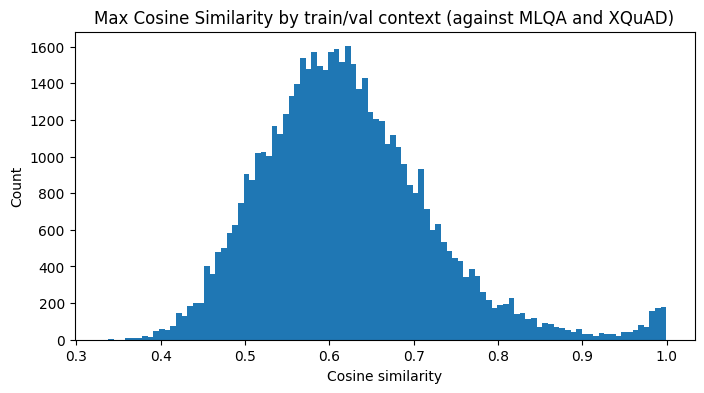

In [157]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(ctx_embed_sim_matrix, axis=1), bins=100)
plt.title("Max Cosine Similarity by train/val context (against MLQA and XQuAD)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

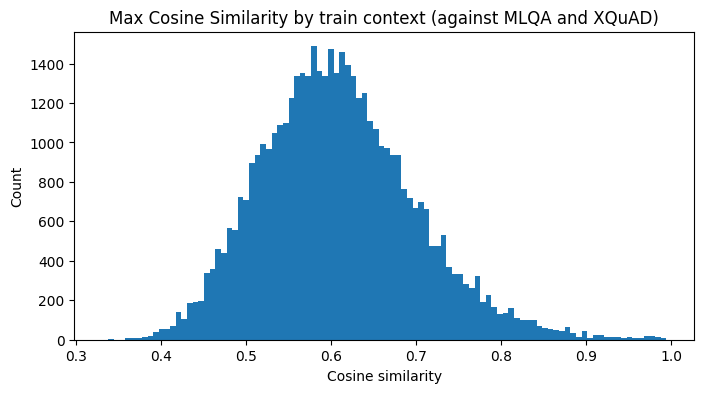

In [158]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(ctx_embed_sim_matrix[:len(ctx_train),:], axis=1), bins=100)
plt.title("Max Cosine Similarity by train context (against MLQA and XQuAD)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

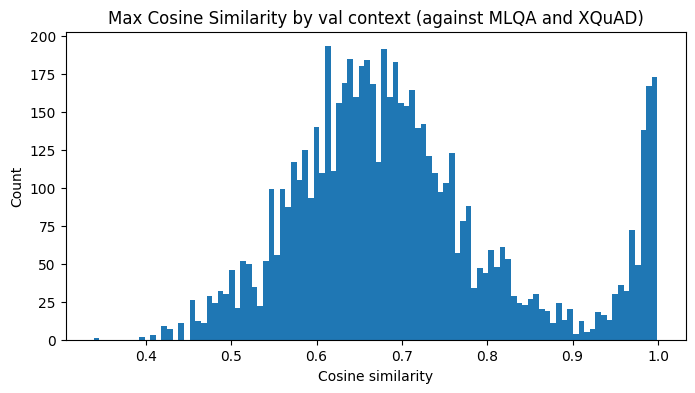

In [159]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(ctx_embed_sim_matrix[len(ctx_train):,:], axis=1), bins=100)
plt.title("Max Cosine Similarity by val context (against MLQA and XQuAD)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

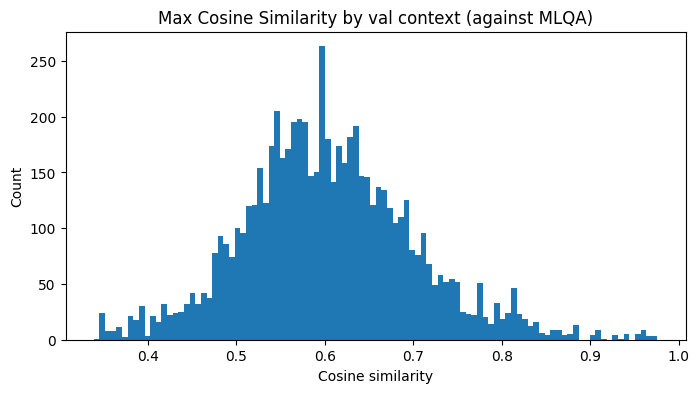

In [160]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(ctx_embed_sim_matrix[len(ctx_train):,:len(ctx_test1)], axis=1), bins=100)
plt.title("Max Cosine Similarity by val context (against MLQA)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

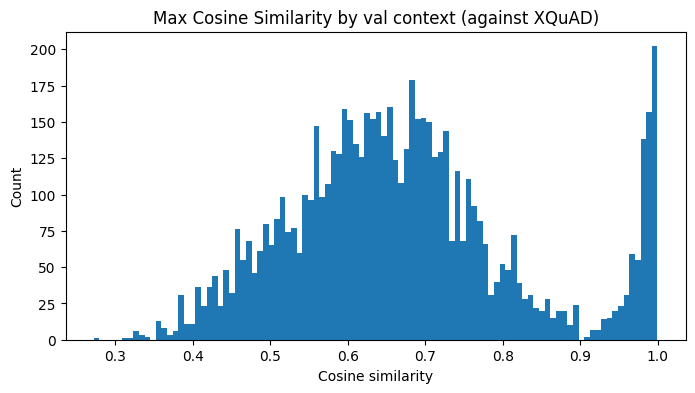

In [161]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(ctx_embed_sim_matrix[len(ctx_train):,len(ctx_test1):], axis=1), bins=100)
plt.title("Max Cosine Similarity by val context (against XQuAD)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

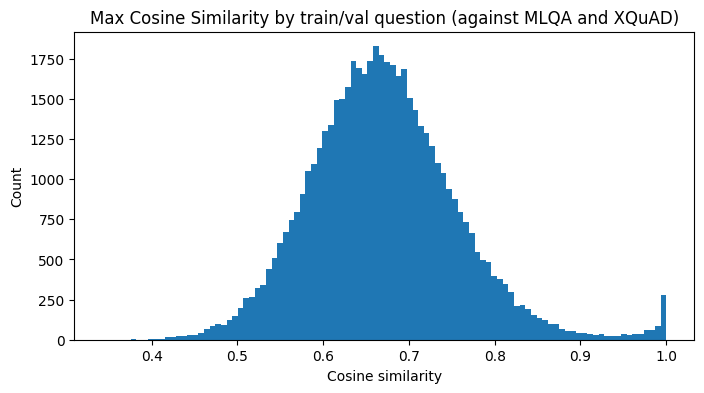

In [162]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(qst_embed_sim_matrix, axis=1), bins=100)
plt.title("Max Cosine Similarity by train/val question (against MLQA and XQuAD)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

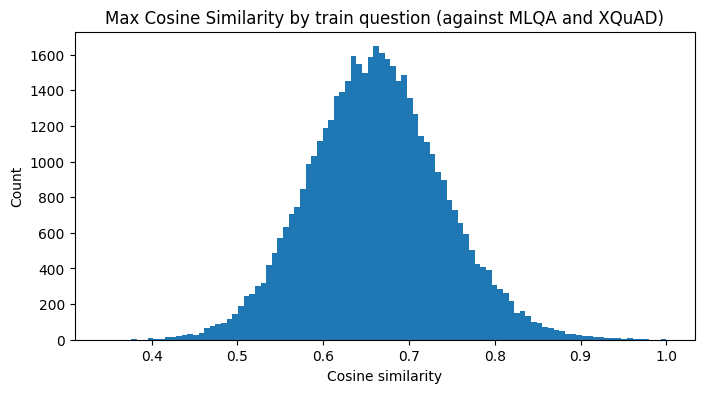

In [163]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(qst_embed_sim_matrix[:len(ctx_train),:], axis=1), bins=100)
plt.title("Max Cosine Similarity by train question (against MLQA and XQuAD)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

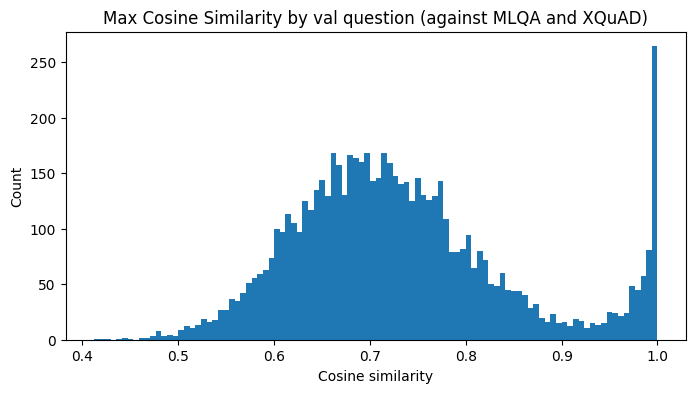

In [164]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(qst_embed_sim_matrix[len(ctx_train):,:], axis=1), bins=100)
plt.title("Max Cosine Similarity by val question (against MLQA and XQuAD)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

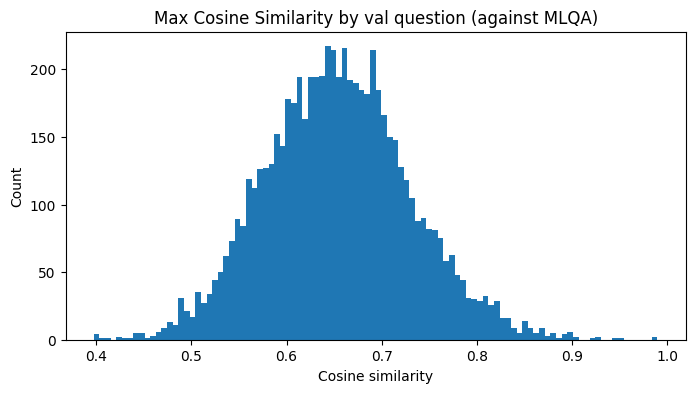

In [165]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(qst_embed_sim_matrix[len(ctx_train):,:len(ctx_test1)], axis=1), bins=100)
plt.title("Max Cosine Similarity by val question (against MLQA)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

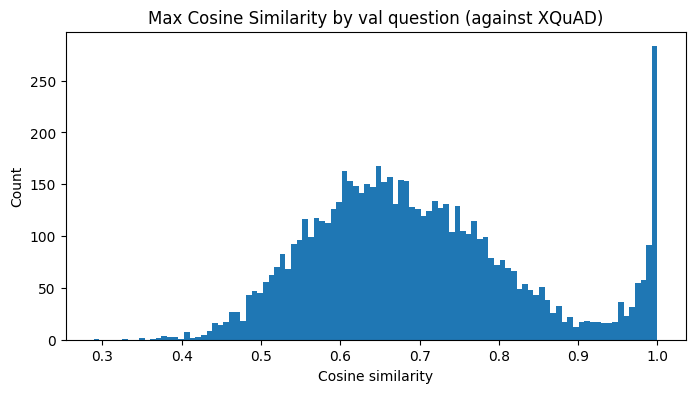

In [166]:
plt.figure(figsize=(8, 4))
plt.hist(np.max(qst_embed_sim_matrix[len(ctx_train):,len(ctx_test1):], axis=1), bins=100)
plt.title("Max Cosine Similarity by val question (against XQuAD)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

Examining the plotted similarity distributions, we can clearly see:
- There are *no significant clusters of highly similar entries* between the SQuAD train split and either test set (MLQA or XQuAD).
- The SQuAD validation split shows very little overlap with MLQA, but reveals a *substantial concentration* of similar entries to XQuAD.

This matches our understanding of the datasets:  
MLQA was independently constructed, so overlap with SQuAD should be rare. XQuAD, however, is a professionally translated subset of SQuAD, so we expect meaningful overlap, especially in the validation split, from which XQuAD was derived.

The plots show clear threshold values (0.9 for context, 0.9 for questions) that separate the highly semantically similar texts.  
For confirmation, we will review a few samples above these thresholds and a just bellow them (edge cases), focusing only on SQuAD val agains XQuAD:

In [167]:
embed_match_above = np.argwhere((ctx_embed_sim_matrix[len(ctx_train):,len(ctx_test1):] > 0.9) & (qst_embed_sim_matrix[len(ctx_train):,len(ctx_test1):] > 0.9))
embed_match_edge = np.argwhere((ctx_embed_sim_matrix[len(ctx_train):,len(ctx_test1):] > 0.8) & (ctx_embed_sim_matrix[len(ctx_train):,len(ctx_test1):] <= 0.9) & \
            (qst_embed_sim_matrix[len(ctx_train):,len(ctx_test1):] > 0.8) & (qst_embed_sim_matrix[len(ctx_train):,len(ctx_test1):] <= 0.9))

In [168]:
for i, j in random.sample(list(embed_match_above), min(10, len(embed_match_above))):
    print(f"Val Index: {i}, XQuAD Index: {j}, Similarity: CTX {ctx_embed_sim_matrix[len(ctx_train):,len(ctx_test1):][i, j]:.3f}, QST {qst_embed_sim_matrix[len(ctx_train):,len(ctx_test1):][i, j]:.3f}\n")
    print(f"[VAL]    {ctx_val[i]}\n[VAL]     {qst_val[i]}")
    print(f"[XQUAD]  {ctx_test2[j]}\n[XQUAD]   {qst_test2[j]}")
    print("###########################################################################")

Val Index: 5630, XQuAD Index: 1048, Similarity: CTX 0.994, QST 0.975

[VAL]    El islamismo es un concepto controvertido no sólo porque postula un papel político para el Islam, sino también porque sus partidarios creen que sus opiniones simplemente reflejan el Islam, mientras que la idea contraria de que el Islam es, o puede ser, un error. Académicos y observadores que no creen que el Islam sea simplemente una ideología política incluyen a Fred Halliday, John Esposito e intelectuales musulmanes como Javed Ahmad Ghamidi. Hayri Abaza argumenta que el no distinguir entre el Islam y el islamismo lleva a muchos en Occidente a apoyar regímenes islámicos no liberales, en detrimento de los moderados progresistas que buscan separar la religión de la política.
[VAL]     ¿Qué tipo de papel que busca el islamismo lo convierte en un concepto algo controvertido?
[XQUAD]  El islamismo es un concepto controvertido no solo porque plantea un papel político para el Islam, sino también porque sus partidar

In [169]:
for i, j in random.sample(list(embed_match_edge), min(10, len(embed_match_edge))):
    print(f"Val Index: {i}, XQuAD Index: {j}, Similarity: CTX {ctx_embed_sim_matrix[len(ctx_train):,len(ctx_test1):][i, j]:.3f}, QST {qst_embed_sim_matrix[len(ctx_train):,len(ctx_test1):][i, j]:.3f}\n")
    print(f"[VAL]    {ctx_val[i]}\n[VAL]     {qst_val[i]}")
    print(f"[XQUAD]  {ctx_test2[j]}\n[XQUAD]   {qst_test2[j]}")
    print("###########################################################################")

Val Index: 5268, XQuAD Index: 992, Similarity: CTX 0.863, QST 0.813

[VAL]    Según los economistas del Fondo Monetario Internacional, la desigualdad en la riqueza y el ingreso está correlacionada negativamente con la duración de los períodos de crecimiento económico (no la tasa de crecimiento). Los altos niveles de desigualdad impiden no sólo la prosperidad económica, sino también la calidad de las instituciones de un país y los altos niveles de educación. Según los economistas del personal del FMI, "si la proporción de ingresos del 20% superior (los ricos) aumenta, entonces el crecimiento del PIB en realidad disminuye en el mediano plazo, lo que sugiere que los beneficios no se debilitan. En contraste, un aumento en la proporción de ingresos del 20% inferior (los pobres) se asocia con un mayor crecimiento del PIB. Los pobres y la clase media importan más para el crecimiento a través de una serie de canales económicos, sociales y políticos interrelacionados ".
[VAL]     ¿Qué evitan lo

From the samples observed, we can confirm that the observed thresholds produce true duplicates with great accuracy, while the edge-cases show mainly different QA pairs.  

Before removing duplicates we will compute some quantitative values measuring the amount of entries above the thresholds and their proportion in relation to our SQuAD data:

In [170]:
# Thresholds used for masks
th_ctx = 0.9
th_qst = 0.9

# Full mask (SQuAD train+val against MLQA+XQuAD)
full_mask = ((ctx_embed_sim_matrix > th_ctx) & (qst_embed_sim_matrix > th_qst)).any(axis=1)

# Masks for SQuAD train split against MLQA and XQuAD together and separately
train_full_mask = ((ctx_embed_sim_matrix[:len(ctx_train),:] > th_ctx) & (qst_embed_sim_matrix[:len(ctx_train),:] > th_qst)).any(axis=1)
train_mlqa_mask = ((ctx_embed_sim_matrix[:len(ctx_train),:len(ctx_test1)] > th_ctx) & (qst_embed_sim_matrix[:len(ctx_train),:len(ctx_test1)] > th_qst)).any(axis=1)
train_xquad_mask = ((ctx_embed_sim_matrix[:len(ctx_train),len(ctx_test1):] > th_ctx) & (qst_embed_sim_matrix[:len(ctx_train),len(ctx_test1):] > th_qst)).any(axis=1)

# Masks for SQuAD val split against MLQA and XQuAD together and separately
val_full_mask = ((ctx_embed_sim_matrix[len(ctx_train):,:] > th_ctx) & (qst_embed_sim_matrix[len(ctx_train):,:] > th_qst)).any(axis=1)
val_mlqa_mask = ((ctx_embed_sim_matrix[len(ctx_train):,:len(ctx_test1)] > th_ctx) & (qst_embed_sim_matrix[len(ctx_train):,:len(ctx_test1)] > th_qst)).any(axis=1)
val_xquad_mask = ((ctx_embed_sim_matrix[len(ctx_train):,len(ctx_test1):] > th_ctx) & (qst_embed_sim_matrix[len(ctx_train):,len(ctx_test1):] > th_qst)).any(axis=1)

In [171]:
print(f'--- Using as similarity thresholds {th_ctx} for contexts and {th_qst} for questions ---')
print('\n##########################################################################\n')
print('--- Full comparison SQuAD train+val against MLQA and XQuAD ---')
print(f'Total entries to be dropped: {full_mask.sum()} out of {full_mask.shape[0]} ({100 * full_mask.sum() / full_mask.shape[0]:.2f}%)')
print('\n##########################################################################\n')
print('--- Considering only SQuAD train split ---')
print(f'Total entries to be dropped: {train_full_mask.sum()} out of {train_full_mask.shape[0]} ({100 * train_full_mask.sum() / train_full_mask.shape[0]:.2f}%)')
print(f' - Due to MLQA: {train_mlqa_mask.sum()} out of {train_mlqa_mask.shape[0]} ({100 * train_mlqa_mask.sum() / train_mlqa_mask.shape[0]:.2f}%)')
print(f' - Due to XQuAD: {train_xquad_mask.sum()} out of {train_xquad_mask.shape[0]} ({100 * train_xquad_mask.sum() / train_xquad_mask.shape[0]:.2f}%)')
print('\n##########################################################################\n')
print('--- Considering only SQuAD val split ---')
print(f'Total entries to be dropped: {val_full_mask.sum()} out of {val_full_mask.shape[0]} ({100 * val_full_mask.sum() / val_full_mask.shape[0]:.2f}%)')
print(f' - Due to MLQA: {val_mlqa_mask.sum()} out of {val_mlqa_mask.shape[0]} ({100 * val_mlqa_mask.sum() / val_mlqa_mask.shape[0]:.2f}%)')
print(f' - Due to XQuAD: {val_xquad_mask.sum()} out of {val_xquad_mask.shape[0]} ({100 * val_xquad_mask.sum() / val_xquad_mask.shape[0]:.2f}%)')

--- Using as similarity thresholds 0.9 for contexts and 0.9 for questions ---

##########################################################################

--- Full comparison SQuAD train+val against MLQA and XQuAD ---
Total entries to be dropped: 657 out of 52729 (1.25%)

##########################################################################

--- Considering only SQuAD train split ---
Total entries to be dropped: 8 out of 46176 (0.02%)
 - Due to MLQA: 7 out of 46176 (0.02%)
 - Due to XQuAD: 1 out of 46176 (0.00%)

##########################################################################

--- Considering only SQuAD val split ---
Total entries to be dropped: 649 out of 6553 (9.90%)
 - Due to MLQA: 2 out of 6553 (0.03%)
 - Due to XQuAD: 647 out of 6553 (9.87%)


Quantitative analysis confirms our expectations: the SQuAD validation set has substantial overlap with XQuAD, with almost 10% of entries exhibiting above 0.9 cosine similarity in both context and question. Overlap with MLQA, or within the SQuAD train split, is negligible.

**Regarding SQuAD Val and XQuAD:**  
The original SQuAD validation set contained 10,570 entries, but our subset (from the Spanish machine-translated SQuAD) is smaller due to removal of entries with translation artifacts by the original authors, as well as our own further cleaning—resulting in 6,553 samples (about 62% of the original split).

XQuAD comprises 1,190 entries drawn from the original SQuAD validation split. Our deduplication process identified 647 highly similar entries (assuming no false positives, that is ~54% of XQuAD), indicating substantial overlap.

It is likely that the remaining XQuAD entries were already removed due to translation artifacts, either by the creators of the translation or by our subsequent cleaning. However, it is important to note that there is no guarantee of complete absence of leakage; some XQuAD entries may still be present in our validation split, but with sufficient translation differences that our semantic similarity approach did not detect them.

In [172]:
# Note: Only removing entries from SQuAD train and val sets that have high similarity to MLQA and XQuAD
# MLQA and XQuAD test sets are left unchanged (test sets)
squad_train_df = squad_train_df[~train_full_mask].copy()
squad_val_df = squad_val_df[~val_full_mask].copy()

# 6. Analysis & Exploration

Before exporting the cleaned and harmonized datasets, we will analyse several aspects of the content and manually review outliers in order to remove any problematic entries from our data, as well as getting to know better the structure and content.  

Before proceeding forward, we will create copies of the dataframes and the final modification or removal of entries will be done at the end of the section over the original dataframes.

In [173]:
# Copies for exploration
train_df = squad_train_df.copy()
val_df = squad_val_df.copy()
test1_df = mlqa_test_df.copy()
test2_df = xquad_test_df.copy()

# Sets for flagged IDs for train and val sets (test sets will not be changed)
train_df_flagged = set()
val_df_flagged = set()

## 6.1 Context Length

We will plot the distribution of context length for each dataset, manually reviewing extreme cases and flagging those that need to be removed.  

For that we will add an auxiliary column to the datasets with the length of the context, which we will drop at the end of the subsection.

In [174]:
train_df['ctx_len'] = train_df['context'].apply(lambda x: len(x))
val_df['ctx_len'] = val_df['context'].apply(lambda x: len(x))
test1_df['ctx_len'] = test1_df['context'].apply(lambda x: len(x))
test2_df['ctx_len'] = test2_df['context'].apply(lambda x: len(x))

First we will analyse our training data (train split from SQuAD):

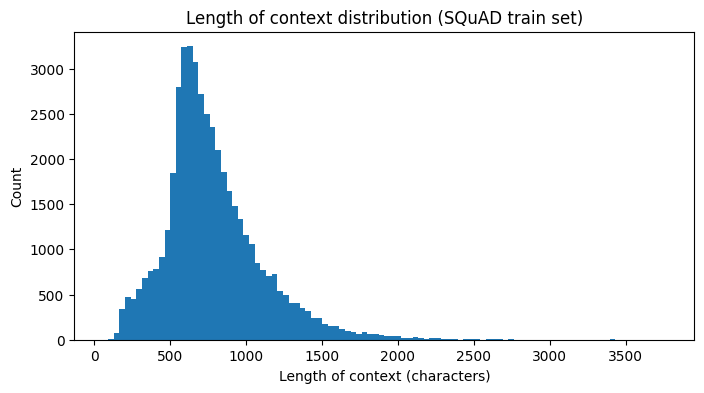

Length of context statistics for SQuAD train set:
count    46168.000000
mean       783.052980
std        319.868725
min         56.000000
25%        583.000000
50%        723.000000
75%        933.000000
max       3768.000000
Name: ctx_len, dtype: float64


In [175]:
plt.figure(figsize=(8, 4))
plt.hist(train_df['ctx_len'], bins=100)
plt.title("Length of context distribution (SQuAD train set)")
plt.xlabel("Length of context (characters)")
plt.ylabel("Count")
plt.show()
print("Length of context statistics for SQuAD train set:")
print(train_df['ctx_len'].describe())

In [176]:
# Entries with context length < 125 characters
train_df[train_df['ctx_len'] < 125]

,id,context,question,answers,ctx_len
4766,56df50e896943c1400a5d383,Babatunde Osotimehin (Nigeria) 2000-2010 Ms Th...,¿El Dr. Babatunde Osotimehin vino de qué país?,"{'answer_start': [22], 'text': ['Nigeria']}",117
4767,56df50e896943c1400a5d384,Babatunde Osotimehin (Nigeria) 2000-2010 Ms Th...,¿Quién fue Director Ejecutivo o Subsecretario ...,"{'answer_start': [44], 'text': ['Thoraya Ahmed...",117
4768,56df50e896943c1400a5d385,Babatunde Osotimehin (Nigeria) 2000-2010 Ms Th...,¿Qué médico de Pakistán sirvió hasta 2000?,"{'answer_start': [91], 'text': ['Dr. Nafis Sad...",117
4909,56df6aed56340a1900b29adc,"La palabra persa más común es Masīhī (مسیحی), ...",¿Cuál es la palabra persa más común para crist...,"{'answer_start': [30], 'text': ['Masīhī']}",56
9067,56f840dea6d7ea1400e17513,Orden del Mérito de la República Checa Orden d...,Tito fue condecorado con la Real Orden de qué ...,"{'answer_start': [59], 'text': ['Camboya']}",83
13374,570a580b4103511400d59632,"Consultado el 21 de octubre de 2008. ""Ficha de...",¿Qué diseñador de automóviles famoso es consid...,"{'answer_start': [77], 'text': ['Nicholas Tomb...",96


There are two cases (id **56f840dea6d7ea1400e17513** and id **570a580b4103511400d59632**) where it seems like the context is incomplete.  
Regardless of the source of this error (original SQuAD or the translation process), while the answer is contained in the context, the question cannot be answered without external information.  
As such, both will be flagged for removal.

In [177]:
train_df_flagged.add("56f840dea6d7ea1400e17513")
train_df_flagged.add("570a580b4103511400d59632")

In [178]:
# Entries with context length > 3000 characters
train_df[train_df['ctx_len'] > 3000]

,id,context,question,answers,ctx_len
22678,5726a9a8f1498d1400e8e673,"En 1824, el físico francés François Arago form...",¿Qué tipo de potencia eran los primeros motore...,"{'answer_start': [772], 'text': ['Ac']}",3014
28564,5727e311ff5b5019007d979a,Los discos maestros originales se crean cortan...,¿Cuál se prefiere el proceso de dos pasos o tr...,"{'answer_start': [3247], 'text': ['tres pasos']}",3430
28565,5727e311ff5b5019007d979b,Los discos maestros originales se crean cortan...,¿Qué tiene estructuras más fuertes el molde pa...,"{'answer_start': [3200], 'text': ['hijos']}",3430
28566,5727e311ff5b5019007d979c,Los discos maestros originales se crean cortan...,¿Qué puede aumentar la producción de un molde ...,"{'answer_start': [3164], 'text': ['la calidad ...",3430
31309,5728b30aff5b5019007da4cb,La mandolina se ha utilizado ampliamente en la...,¿Qué produjo Simon mayer?,"{'answer_start': [174], 'text': ['seis álbumes...",3559
31310,5728b30aff5b5019007da4ce,La mandolina se ha utilizado ampliamente en la...,¿Qué canción usó Rod Stewart la mandolina?,"{'answer_start': [1036], 'text': ['Maggie May']}",3559
31544,5728c4163acd2414000dfddf,El cielo es generalmente claro por encima del ...,¿Cuál es la mayor área continuamente grande má...,"{'answer_start': [561], 'text': ['el Gran Desi...",3768
31545,5728c4163acd2414000dfde0,El cielo es generalmente claro por encima del ...,¿Cuál es la temperatura de valor de la mayor p...,"{'answer_start': [2605], 'text': ['25 ° C']}",3768


Although extremely long compared with the average, nothing is wrong with the reviewed samples.  
No need for further action.  

We will proceed with the analysis of the SQuAD val split:

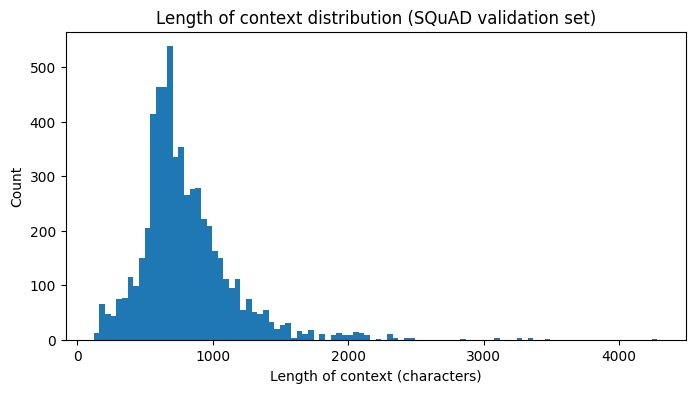

Length of context statistics for SQuAD validation set:
count    5904.000000
mean      801.015413
std       352.501410
min       123.000000
25%       593.000000
50%       728.000000
75%       937.000000
max      4282.000000
Name: ctx_len, dtype: float64


In [179]:
plt.figure(figsize=(8, 4))
plt.hist(val_df['ctx_len'], bins=100)
plt.title("Length of context distribution (SQuAD validation set)")
plt.xlabel("Length of context (characters)")
plt.ylabel("Count")
plt.show()
print("Length of context statistics for SQuAD validation set:")
print(val_df['ctx_len'].describe())

In [180]:
# Entries with context length < 150 characters
val_df[val_df['ctx_len'] < 150]

,id,context,question,answers,ctx_len
752,56e11c24e3433e1400422c18,"Tesla medía 6 pies y 2 pulgadas (1,88 m) de al...",¿Cuánto pesaba Tesla?,"{'answer_start': [58], 'text': ['142 libras (6...",142
2259,5725c63438643c19005acc9f,El satélite CALIPSO de la NASA ha medido la ca...,¿Cuál es el nombre del satélite que midió la c...,"{'answer_start': [12], 'text': ['CALIPSO']}",123
2260,5725c63438643c19005acca2,El satélite CALIPSO de la NASA ha medido la ca...,¿En qué cuenca se cae el polvo?,"{'answer_start': [114], 'text': ['Amazon']}",123
4175,5728455bff5b5019007da078,El satélite CALIPSO de la NASA ha medido la ca...,¿Qué herramienta ha medido la cantidad de polv...,"{'answer_start': [3, 3], 'text': ['satélite CA...",123
5073,5729ea263f37b319004785bd,El satélite CALIPSO de la NASA ha medido la ca...,Un satélite que midió la cantidad de polvo que...,"{'answer_start': [12], 'text': ['CALIPSO']}",123
5074,5729ea263f37b319004785be,El satélite CALIPSO de la NASA ha medido la ca...,¿Qué organización dirige el satélite que mide ...,"{'answer_start': [23], 'text': ['la NASA']}",123


In [181]:
# Entries with context length > 3000 characters
val_df[val_df['ctx_len'] > 3000]

,id,context,question,answers,ctx_len
2504,57263b1638643c19005ad333,Tanto X.25 como Frame Relay proporcionan opera...,Qué requieren X.25 y Frame Relay ambos requieren,"{'answer_start': [269, 41], 'text': ['un apret...",3271
2505,57263b1638643c19005ad334,Tanto X.25 como Frame Relay proporcionan opera...,Lo que fueron X.25 y Frame relay usados para,"{'answer_start': [1339], 'text': ['interfaz es...",3271
2506,57263b1638643c19005ad335,Tanto X.25 como Frame Relay proporcionan opera...,Qué supplantó Frame Relay y X.25,"{'answer_start': [2971, 2971], 'text': ['Proto...",3271
2507,57263b1638643c19005ad336,Tanto X.25 como Frame Relay proporcionan opera...,Qué configuración típica,"{'answer_start': [3061], 'text': ['Una configu...",3271
3188,5726b718dd62a815002e8dbe,La libre circulación de bienes dentro de la Un...,¿Qué ayuda al proceso de libre circulación de ...,"{'answer_start': [76], 'text': ['una unión adu...",3357
3189,5726b718dd62a815002e8dbf,La libre circulación de bienes dentro de la Un...,¿Qué discriminó el artículo 34 en Procureur du...,"{'answer_start': [943], 'text': ['importadores...",3357
3190,5726b718dd62a815002e8dc0,La libre circulación de bienes dentro de la Un...,El artículo 34 significaba que los estados pod...,"{'answer_start': [1395], 'text': ['actores pri...",3357
3191,5726b718dd62a815002e8dc2,La libre circulación de bienes dentro de la Un...,"En Schmidberger v Austria, el Tribunal de Just...","{'answer_start': [2672], 'text': ['una prote']}",3357
3196,5726b929f1498d1400e8e8e8,A menudo se aplican reglas a todos los bienes ...,¿Cuál es el porcentaje mínimo de alcohol que u...,"{'answer_start': [640], 'text': ['25%']}",3084
3197,5726b929f1498d1400e8e8e9,A menudo se aplican reglas a todos los bienes ...,¿De qué país quería importar Rewe-Zentrale AG?,"{'answer_start': [722], 'text': ['Francia']}",3084


Neither the shortest cases nor the longest show issues.  
No need for further action.  

We will proceed with the MLQA dataframe:  

_Note: Regardless of our findings, no modifications will be done to the test sets (MLQA and XQuAD) in order to be able to compare our results with available benchmark scores._

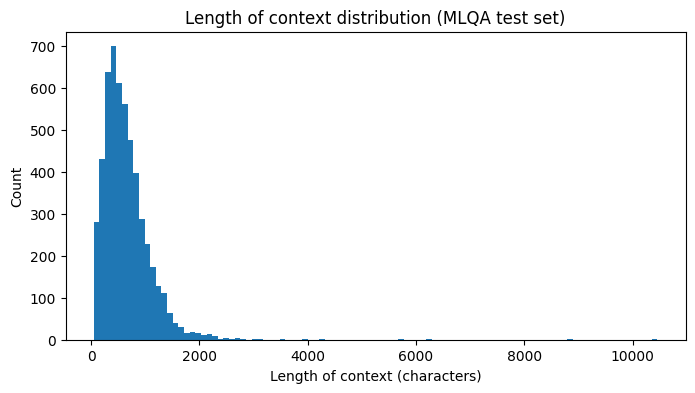

Length of context statistics for MLQA test set:
count     5253.000000
mean       650.865410
std        455.298405
min         51.000000
25%        359.000000
50%        563.000000
75%        839.000000
max      10458.000000
Name: ctx_len, dtype: float64


In [182]:
plt.figure(figsize=(8, 4))
plt.hist(test1_df['ctx_len'], bins=100)
plt.title("Length of context distribution (MLQA test set)")
plt.xlabel("Length of context (characters)")
plt.ylabel("Count")
plt.show()
print("Length of context statistics for MLQA test set:")
print(test1_df['ctx_len'].describe())

In [183]:
# Entries with context length < 100 characters
test1_df[test1_df['ctx_len'] < 100]

,id,context,question,answers,ctx_len
83,04352748842192bb525ce15da61d5c006cd10edd,"En 2005, Murphy firmó como portavoz para los v...",¿Con qué marca ha estado asociado Murphy?,"{'answer_start': [45], 'text': ['vaqueros Jord...",68
165,074b26887a46cf1cdbd29b07d0a112113366bff0,Turgun Syzdykov - candidato del Partido Comuni...,¿Quién es el candidato del partido comunista d...,"{'answer_start': [0], 'text': ['Turgun Syzdyko...",74
204,09810bfad2084f9f6f0a758efc8119e6f92e194e,Una imagen de la película con Johnson fue reve...,¿Cuándo se lanzó la imagen?,"{'answer_start': [54], 'text': ['17 de marzo d...",74
382,11aef833126d5ddb1462c2efb08e5d176f9020b7,"En octubre de 2006, Men's Fitness reconoció a ...",¿Qué universidad fue catalogada como número 1 ...,"{'answer_start': [46], 'text': ['Colgate']}",97
582,1abcca56f9d1cd694c20e191bcc196240b180496,Anhinga minuta (Solimões Late Miocene/Early Pl...,¿Qué continente está listado aquí?,"{'answer_start': [59], 'text': ['South America']}",73
...,...,...,...,...,...
5014,f66529495349d7cc431a0fc1f77d81773cb80fa1,Los diseños se publican en el Diario Oficial d...,¿Quién publicita los diseños emitidos?,"{'answer_start': [27], 'text': ['el Diario Ofi...",69
5031,f70be4441a86a7fa5b721f2f0a2e381465acea7a,Los motivos más frecuentes para circuncidar so...,¿Por qué razones tendría este procedimiento al...,"{'answer_start': [48], 'text': ['religiosos, c...",81
5123,fabab07d9c7b42d2425047d91b2e637fa77cb941,En 1920 fue unificado y el 15 de junio de 1962...,¿cuándo se unificaron?,"{'answer_start': [24], 'text': ['el 15 de juni...",80
5162,fbe25f00a58cf82ee5ba3986c5c4b6a4cb6a94d5,Tipo espectral Ld. Nuevo tipo con característi...,¿Qué distingue el asteroide tipo LD del astero...,"{'answer_start': [0], 'text': ['Tipo espectral...",99


Observing the entries with the shortest contexts, we find several several instances where some error happens due to different reasons, for example:  

- In id **11aef833126d5ddb1462c2efb08e5d176f9020b7** the answer is contained in the context, but either the context is missing information or the question is wrong (*classified by Men's Fitness according to context, question asks for Princeton*).
- In id **1d22edb876b6dcd60c3a2a9bdafac95515db9cf4** the context is missing information
- In id **4151377af1140e837a4dd8463fb04ca825172094** there is a tranlation error (*Terms* in *Terms of Services* cannot be translated as *tipos*, should have been *términos* or *condiciones*)

But as mentioned before, no modifications will be done on the test sets.

In [184]:
# Entries with context length > 5000 characters
test1_df[test1_df['ctx_len'] > 5000]

,id,context,question,answers,ctx_len
955,2df79121cf767480ae75a85568fe66fa33f7aa13,Christian Bale como Bruce Wayne / Batman:Un mu...,¿Qué hace ser Batman difícil?,"{'answer_start': [724], 'text': ['mantener la ...",10458
1648,51acbb26e0248b88f4d4d11784fb0c30302d5324,"Ninguna zona del Oriente Medio, o tal vez del ...",¿Cuántas fábricas hay en el nuevo complejo ind...,"{'answer_start': [5843], 'text': ['124']}",8825
4184,cf5f6bfa0028cc245e5e5438534ba2f9645adfe3,1845: Carl August Reichenbach entrega la prime...,¿Qué tipo de sistema de producción se puede cr...,"{'answer_start': [2836], 'text': ['un sistema ...",6250
4666,e5b981d93ae1302120f735aaf1eac848d523f57b,Johnny Depp como el capitán Jack Sparrow: un e...,¿Hace cuánto que Jack Sparrow capturó la perla...,"{'answer_start': [352], 'text': ['diez años']}",5721


MLQA shows entries with contexts significantly longer than the other datasets, but the most extreme cases reviewed show nothing wrong.  

Finally we will observe the distribution on the XQuAD dataset:  

_Note: Regardless of our findings, no modifications will be done to the test sets (MLQA and XQuAD) in order to be able to compare our results with available benchmark scores._

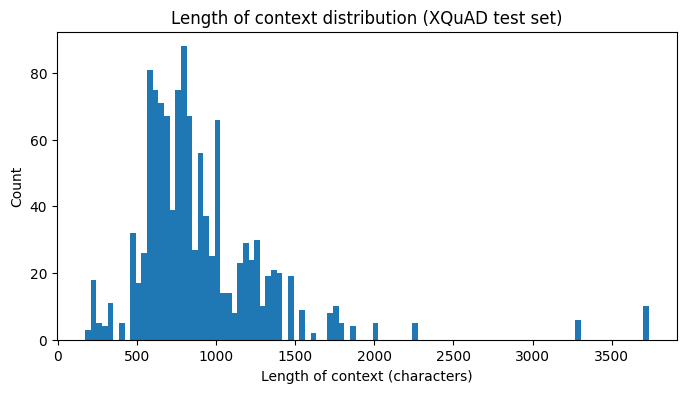

Length of context statistics for XQuAD test set:
count    1190.000000
mean      908.000840
std       452.597363
min       173.000000
25%       641.000000
50%       805.000000
75%      1026.000000
max      3734.000000
Name: ctx_len, dtype: float64


In [185]:
plt.figure(figsize=(8, 4))
plt.hist(test2_df['ctx_len'], bins=100)
plt.title("Length of context distribution (XQuAD test set)")
plt.xlabel("Length of context (characters)")
plt.ylabel("Count")
plt.show()
print("Length of context statistics for XQuAD test set:")
print(test2_df['ctx_len'].describe())

In [186]:
# Entries with context length < 200 characters
test2_df[test2_df['ctx_len'] < 200]

,id,context,question,answers,ctx_len
174,56f8ca289b226e1400dd1007,Después se encontró un trozo de papel en el qu...,¿Qué se descubrió más tarde que había escrito ...,"{'answer_start': [69], 'text': ['su última dec...",173
175,56f8ca289b226e1400dd1008,Después se encontró un trozo de papel en el qu...,¿En qué idioma estaba escrita la mayor parte d...,"{'answer_start': [117], 'text': ['latín']}",173
176,56f8ca289b226e1400dd1009,Después se encontró un trozo de papel en el qu...,¿Qué parte de la última declaración de Lutero ...,"{'answer_start': [134], 'text': ['«Somos mendi...",173


In [187]:
# Entries with context length > 2500 characters
test2_df[test2_df['ctx_len'] > 2500]

,id,context,question,answers,ctx_len
450,572651f9f1498d1400e8dbee,Aunque la Comisión tiene el monopolio de la in...,¿Qué dos órganos rectores tienen poder de veto...,"{'answer_start': [68], 'text': ['el Parlamento...",3734
451,572651f9f1498d1400e8dbef,Aunque la Comisión tiene el monopolio de la in...,¿Qué no puede hacer el Parlamento para que la ...,"{'answer_start': [464], 'text': ['no pueden in...",3734
452,572651f9f1498d1400e8dbf0,Aunque la Comisión tiene el monopolio de la in...,¿Con qué frecuencia se celebran elecciones al ...,"{'answer_start': [1843], 'text': ['cada cinco ...",3734
453,572651f9f1498d1400e8dbf1,Aunque la Comisión tiene el monopolio de la in...,¿Qué mayoría de votos debe existir para censur...,"{'answer_start': [3135], 'text': ['una mayoría...",3734
454,572651f9f1498d1400e8dbf2,Aunque la Comisión tiene el monopolio de la in...,¿Cuáles son los dos órganos por los que el Par...,"{'answer_start': [3480], 'text': ['la Comisión...",3734
473,57265e455951b619008f70bb,"Desde su fundación, la UE ha actuado en un con...",En caso de conflicto entre la legislación de l...,"{'answer_start': [519], 'text': ['Derecho de l...",3306
474,57265e455951b619008f70bc,"Desde su fundación, la UE ha actuado en un con...",¿Cuál fue la razón por la que el Tribunal Cons...,"{'answer_start': [1102], 'text': ['como la ley...",3306
475,57265e455951b619008f70bd,"Desde su fundación, la UE ha actuado en un con...",¿Cuáles fueron los años en que se originaron d...,"{'answer_start': [2612], 'text': ['1964 y 1968']}",3306
536,5726938af1498d1400e8e446,Aunque la Comisión tiene el monopolio de la in...,¿Qué entidad tiene el monopolio de la iniciati...,"{'answer_start': [7], 'text': ['la Comisión']}",3734
537,5726938af1498d1400e8e447,Aunque la Comisión tiene el monopolio de la in...,¿Qué entidades tienen poderes de enmienda y ve...,"{'answer_start': [68], 'text': ['el Parlamento...",3734


No issues found regarding context length in the XQuAD most extreme cases.

In [188]:
train_df.drop(['ctx_len'], axis=1, inplace=True)
val_df.drop(['ctx_len'], axis=1, inplace=True)
test1_df.drop(['ctx_len'], axis=1, inplace=True)
test2_df.drop(['ctx_len'], axis=1, inplace=True)

## 6.2 Question Length

We will plot the distribution of question length for each dataset, manually reviewing extreme cases and flagging those that need to be removed.  

For that we will add an auxiliary column to the datasets with the length of the question, which we will drop at the end of the subsection.

In [189]:
train_df['qst_len'] = train_df['question'].apply(lambda x: len(x))
val_df['qst_len'] = val_df['question'].apply(lambda x: len(x))
test1_df['qst_len'] = test1_df['question'].apply(lambda x: len(x))
test2_df['qst_len'] = test2_df['question'].apply(lambda x: len(x))

Starting with the SQuAD train split:

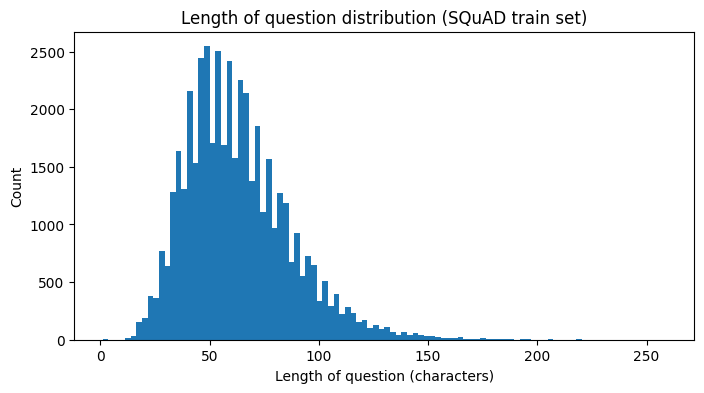

Length of question statistics for SQuAD train set:
count    46168.000000
mean        63.133491
std         24.053884
min          1.000000
25%         46.000000
50%         60.000000
75%         76.000000
max        259.000000
Name: qst_len, dtype: float64


In [190]:
plt.figure(figsize=(8, 4))
plt.hist(train_df['qst_len'], bins=100)
plt.title("Length of question distribution (SQuAD train set)")
plt.xlabel("Length of question (characters)")
plt.ylabel("Count")
plt.show()
print("Length of question statistics for SQuAD train set:")
print(train_df['qst_len'].describe())

In [191]:
# Entries with question length < 10 characters
train_df[train_df['qst_len'] < 10]

,id,context,question,answers,qst_len
5680,56e06bd2231d4119001ac0ee,"En muchos idiomas, como el armenio, coreano, t...",¿Y qué?,"{'answer_start': [261], 'text': ['fonemas']}",7
7026,56e6eb396fe0821900b8ec26,"Nanjing (escucha; China: 南., ""Capital del Sur""...",N,"{'answer_start': [0], 'text': ['N']}",1
7027,56e6eb396fe0821900b8ec27,"Nanjing (escucha; China: 南., ""Capital del Sur""...",B,"{'answer_start': [290], 'text': ['b']}",1
7028,56e6eb396fe0821900b8ec28,"Nanjing (escucha; China: 南., ""Capital del Sur""...",V,"{'answer_start': [206], 'text': ['v']}",1
19778,57262473271a42140099d4ec,El período helenístico abarca el período de la...,DD,"{'answer_start': [1113], 'text': ['budismo']}",2
21114,57267131dd62a815002e8500,Los griegos tienen una larga tradición de valo...,¿Paideia?,"{'answer_start': [73], 'text': ['educación']}",9


In the low end of the spectrum we find several instances where the question is either a single word or even a character or two.  
These entries will be flagged for removal.  

In [192]:
for id in train_df[train_df['qst_len'] < 10]['id'].tolist():
    train_df_flagged.add(id)

In [193]:
# Entries with question length > 200 characters
train_df[train_df['qst_len'] > 200]

,id,context,question,answers,qst_len
2577,56d3a51459d6e41400146877,William Atwood sugirió una reconciliación de e...,"Un comentarista moderno, William Atwood, sient...","{'answer_start': [345], 'text': ['libertad']}",202
3937,56ddecfe66d3e219004dae18,Los marcos de la Constitución de los Estados U...,Quien describió a la confederación holandesa c...,"{'answer_start': [163], 'text': ['James Madiso...",220
8549,56f7477aa6d7ea1400e1714c,La posibilidad de retirada depende de los térm...,Los términos y travaux preparatoire del Pacto ...,"{'answer_start': [0], 'text': ['La posibilidad...",214
8660,56f75cbfaef2371900625b58,El consentimiento tampoco es válido si es dado...,¿Quién debe haber sido notificado de las restr...,"{'answer_start': [161], 'text': ['las otras pa...",207
15925,570da4e916d0071400510c3b,La investigación parece favorecer la hipótesis...,¿La investigación favorece o rechaza la hipóte...,"{'answer_start': [24], 'text': ['favor']}",205
17249,5710dcb5b654c5140001fa10,"En términos generales, la ciencia de la Ilustr...",¿Qué siglo es considerado por algunos como un ...,"{'answer_start': [1237], 'text': ['el siglo XV...",259
17304,57110322b654c5140001fabf,Uno de los desarrollos más importantes que la ...,¿Qué trabajo de Isaac Newton fue publicado en ...,"{'answer_start': [1189], 'text': ['Philosophia...",206
24067,5726d752dd62a815002e9211,Ha habido estudios modernos que han apoyado la...,El estudio de 2008 relacionado con la muerte d...,"{'answer_start': [300], 'text': ['100 veces']}",240
25853,572760715951b619008f88f7,"En abril de 2009, la Corte Suprema de los Esta...",¿Cuántos de los 18 bomberos blancos recibieron...,"{'answer_start': [749], 'text': ['14']}",220
27174,5727a1232ca10214002d925c,"En abril de 2009, la Corte Suprema de los Esta...",¿Qué justicia de la Corte Suprema era un gradu...,"{'answer_start': [777], 'text': ['Sonia Sotoma...",220


No issues found in the higher end of the spectrum.  

We will proceed with the SQuAD validation split:

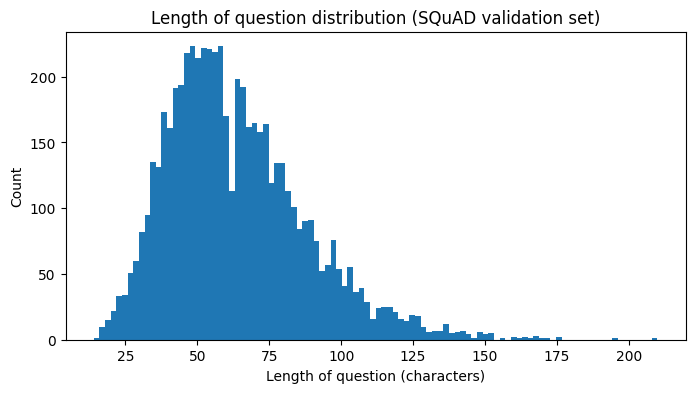

Length of question statistics for SQuAD validation set:
count    5904.000000
mean       63.723747
std        24.283632
min        14.000000
25%        46.000000
50%        60.000000
75%        77.000000
max       210.000000
Name: qst_len, dtype: float64


In [194]:
plt.figure(figsize=(8, 4))
plt.hist(val_df['qst_len'], bins=100)
plt.title("Length of question distribution (SQuAD validation set)")
plt.xlabel("Length of question (characters)")
plt.ylabel("Count")
plt.show()
print("Length of question statistics for SQuAD validation set:")
print(val_df['qst_len'].describe())

In [195]:
# Entries with question length < 20 characters
val_df[val_df['qst_len'] < 20]

,id,context,question,answers,qst_len
459,56de3cd0cffd8e1900b4b6be,"Los normandos llegaron a Escocia, construyendo...",¿Con quién me casé?,"{'answer_start': [287], 'text': ['Sibila']}",19
546,56e057e1231d4119001ac044,"En 1888, el editor de la revista Electrical Wo...",¿Cuál es el IEEE?,"{'answer_start': [198, 195], 'text': ['Institu...",17
580,56e0b94b7aa994140058e6bb,Nikola Tesla (serbio cirílico: Никола Тесла; r...,¿Qué significa AC?,"{'answer_start': [266], 'text': ['corriente al...",18
745,56e11a73e3433e1400422bf1,"Para hacer ejercicio, Tesla caminaba entre 8 a...",¿Por qué caminó?,"{'answer_start': [11], 'text': ['ejercicio']}",16
767,56e12005cd28a01900c67618,Tesla podía ser duro a veces y expresaba abier...,¿A quién disparó?,"{'answer_start': [118], 'text': ['una secretar...",17
1503,57060a6e52bb8914006897f9,El sur de California es el hogar de muchos dis...,¿Qué significa CBD?,"{'answer_start': [82], 'text': ['distritos cen...",19
2249,5725c41eec44d21400f3d50b,Hay evidencia de que ha habido cambios signifi...,¿Qué significa LGM?,"{'answer_start': [133], 'text': ['Último Máxim...",19
2523,57264228ec44d21400f3dcf5,Telenet fue la primera red de datos públicos c...,¿Qué era Telenet?,"{'answer_start': [12], 'text': ['la primera re...",17
2524,57264228ec44d21400f3dcf6,Telenet fue la primera red de datos públicos c...,Quien fundó Telnet,"{'answer_start': [129], 'text': ['Larry Robert...",18
2525,57264228ec44d21400f3dcf7,Telenet fue la primera red de datos públicos c...,Propósito de Telnet,"{'answer_start': [148], 'text': ['un medio par...",19


In [196]:
# Entries with question length > 150 characters
val_df[val_df['qst_len'] > 150]

,id,context,question,answers,qst_len
193,56bf53e73aeaaa14008c95ce,La experiencia anual de la NFL se celebró en e...,¿Cuál fue el nombre del evento en el Embarcade...,"{'answer_start': [90], 'text': ['Super Bowl Ci...",167
199,56bf59523aeaaa14008c95e3,"Por primera vez, el Comité de Anfitriones del ...",Qué comité hizo un esfuerzo para invitar a com...,"{'answer_start': [17], 'text': ['el Comité de ...",175
801,56e17644e3433e1400422f42,Los campos estrechamente relacionados en cienc...,¿Qué campo de la informática analiza todos los...,"{'answer_start': [211], 'text': ['complejidad ...",164
802,56e17644e3433e1400422f43,Los campos estrechamente relacionados en cienc...,¿Qué campo de la ciencia de la computación se ...,"{'answer_start': [111, 684], 'text': ['teoría ...",175
876,56e1c2eee3433e1400423138,Pero limitar el tiempo de cálculo anterior por...,Los problemas de decisión capaces de ser resue...,"{'answer_start': [674], 'text': ['p']}",167
882,56e1c720e3433e140042316e,Para las clases de complejidad definidas de es...,¿Qué tipo de declaración se hace en el esfuerz...,"{'answer_start': [769, 783], 'text': ['declara...",160
891,56e1cbe2cd28a01900c67baf,La reducción más utilizada es una reducción de...,¿Qué tendría que permanecer constante en un al...,"{'answer_start': [384], 'text': ['entrada']}",151
908,56e1e9dfe3433e1400423200,El problema del isomorfismo gráfico es el prob...,¿Quiénes son comúnmente asociados con el algor...,"{'answer_start': [642, 649], 'text': ['Laszlo ...",165
922,56e1febfe3433e1400423238,Lo que la intratabilidad significa en la práct...,¿Cuál es un ejemplo de un problema al que los ...,"{'answer_start': [484, 481], 'text': ['problem...",162
923,56e200e4cd28a01900c67c15,Antes de que la investigación real se dedicara...,¿Quién fue el investigador más influyente entr...,"{'answer_start': [253], 'text': ['Alan Turing']}",152


The shortest question do not present any issues, however in the longest cases we have found several cases where instead of questions, we saw statements.  
We will drop those entries before moving forward with the MLQA analysis.

_Note: Regardless of our findings, no modifications will be done to the test sets (MLQA and XQuAD) in order to be able to compare our results with available benchmark scores._

In [197]:
val_df_flagged.add("57269bb8708984140094cb95")
val_df_flagged.add("5726d7faf1498d1400e8ecdc")
val_df_flagged.add("5727526cdd62a815002e9b11")
val_df_flagged.add("572753335951b619008f8854")

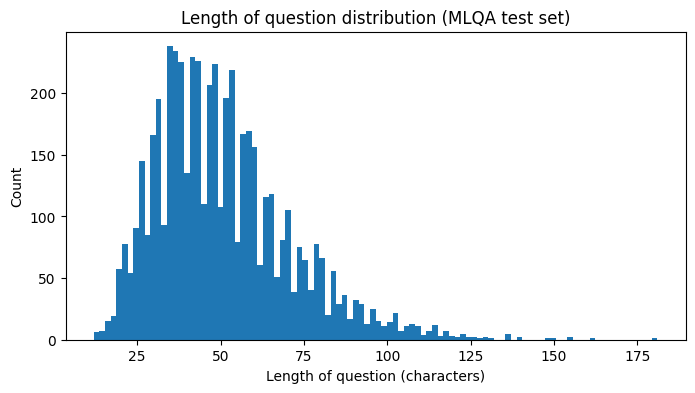

Length of question statistics for MLQA test set:
count    5253.000000
mean       50.919475
std        20.459371
min        12.000000
25%        36.000000
50%        48.000000
75%        62.000000
max       181.000000
Name: qst_len, dtype: float64


In [198]:
plt.figure(figsize=(8, 4))
plt.hist(test1_df['qst_len'], bins=100)
plt.title("Length of question distribution (MLQA test set)")
plt.xlabel("Length of question (characters)")
plt.ylabel("Count")
plt.show()
print("Length of question statistics for MLQA test set:")
print(test1_df['qst_len'].describe())

In [199]:
# Entries with question length < 15 characters
test1_df[test1_df['qst_len'] < 15]

,id,context,question,answers,qst_len
17,00d95cc01bc4d24a340197b4b7bafaa48a688f3c,iTEP Business evalúa las habilidades en inglés...,¿Qué evalúa?,"{'answer_start': [190], 'text': ['cursos inter...",12
481,1694b1bc50cd517d326e85d071277eef7c1b1249,Se examina a los donantes para detectar síntom...,¿Qué examinan?,"{'answer_start': [218], 'text': ['factores de ...",14
543,191d31dd7925f69912dc487ebf5959bbbaac7195,Las ERW eran bombas termonucleares de dos etap...,¿Qué es ERW?,"{'answer_start': [13], 'text': ['bombas termon...",13
785,251af87c499c0b39be5736144b3b2a14a568d50e,Lago Míchigan es el único de los Grandes Lagos...,¿Cuánto mide?,"{'answer_start': [400], 'text': ['494']}",13
1456,47ae485c7af9c9314775bf2a7494049f2b2d6328,Sobre el centro de cada línea de meta y adentr...,¿Cuántos pies?,"{'answer_start': [305], 'text': ['7,32 metros']}",14
1835,5b3b2adfb452f0368b1c51eb4c2d589600418138,Al seleccionar esa tragedia como el tema de su...,¿Qué visitó?,"{'answer_start': [700], 'text': ['depósitos de...",12
2356,73f7b677275f78adbea504cd2e25abdb211578b6,"ISIS. Creado por Pixel Translations, que utili...",¿Qué usa ISIS?,"{'answer_start': [71], 'text': ['máquinas gran...",14
3132,9a4ff92f22ac72dd21ee67e62fe928d277b5e690,Durante el viaje se dañó la estructura de algu...,¿Qué comandó?,"{'answer_start': [366], 'text': ['la flota,']}",13
3421,a77bbb92560d2cb8702ba4e2d320de5786f032a5,Levesque tuvo un feudo con Alex Wright que cul...,¿Quien se fue?,"{'answer_start': [227], 'text': ['Levesque']}",14
3686,b5c27fd4c51f05de6b8bfdf25d4d692ca2d3efdc,Los agentes utilizan el ojo cortado de Martes ...,¿Quién muere?,"{'answer_start': [118], 'text': ['Domingo']}",13


In [200]:
# Entries with question length > 150 characters
test1_df[test1_df['qst_len'] > 150]

,id,context,question,answers,qst_len
1433,460e4bd36b12a05899cd9a8c02c2b214d0f7ade9,El límite entre el uso humanitario y el uso co...,¿Los agricultores y los subsiguientes usuarios...,"{'answer_start': [177], 'text': ['10.000 dólar...",154
1695,53b39c47751f28331e1ef1cbbc995450c942607f,"Las técnicas de imagen, tales como rayos X, fl...",Cuando se modifican los planes para tratamient...,"{'answer_start': [35], 'text': ['rayos X, fluo...",155
4407,d9942198286325a1afca013b3df8f6f91cdef436,Las disputas sucesorias durante el Periodo Tum...,¿Cómo se llamaba la crisis dinástica que resul...,"{'answer_start': [35], 'text': ['Periodo Tumul...",181
4708,e889d4a53e09eeab575f07fa4313fd0fd0fcee02,"Su apariencia muestra escasa estructura y, típ...",Las galaxias elípticas tienen una tasa más baj...,"{'answer_start': [82], 'text': ['materia inter...",162


No issues found with either the shortest or the longest questions in MLQA.  

We will proceed with XQuAD:  

_Note: Regardless of our findings, no modifications will be done to the test sets (MLQA and XQuAD) in order to be able to compare our results with available benchmark scores._

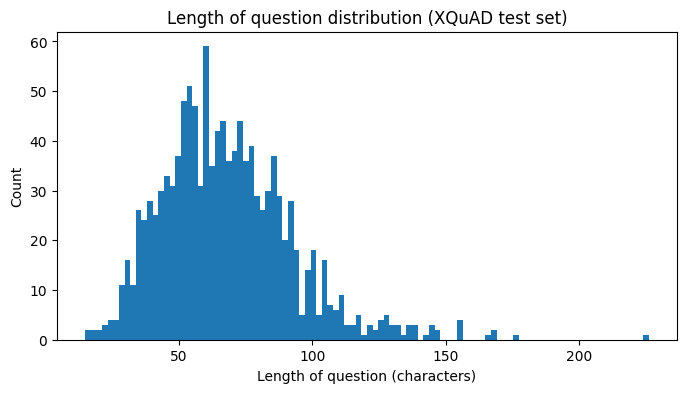

Length of question statistics for XQuAD test set:
count    1190.000000
mean       68.083193
std        24.682828
min        15.000000
25%        51.000000
50%        65.000000
75%        82.000000
max       226.000000
Name: qst_len, dtype: float64


In [201]:
plt.figure(figsize=(8, 4))
plt.hist(test2_df['qst_len'], bins=100)
plt.title("Length of question distribution (XQuAD test set)")
plt.xlabel("Length of question (characters)")
plt.ylabel("Count")
plt.show()
print("Length of question statistics for XQuAD test set:")
print(test2_df['qst_len'].describe())

In [202]:
# Entries with question length < 20 characters
test2_df[test2_df['qst_len'] < 20]

,id,context,question,answers,qst_len
138,56e7788200c9c71400d77183,Los docentes de Gales pueden ser miembros regi...,¿Qué es la NASUWT?,"{'answer_start': [57], 'text': ['sindicatos']}",18
409,57263ea0271a42140099d7c3,DECnet es un conjunto de protocolos de red cre...,¿Qué es DECnet?,"{'answer_start': [10], 'text': ['un conjunto d...",15
425,5726472bdd62a815002e8042,Internet2 es un consorcio de redes informática...,¿Qué es Internet2?,"{'answer_start': [13], 'text': ['un consorcio ...",18
823,572881d34b864d1900164a5a,La medicina occidental también la practicaron ...,¿Qué era huihui?,"{'answer_start': [148], 'text': ['medicina mus...",16


In [203]:
# Entries with question length >170 characters
test2_df[test2_df['qst_len'] > 170]

,id,context,question,answers,qst_len
277,571144d1a58dae1900cd6d70,El calor necesario para hervir el agua y sumin...,Junto con el calor residual de la energía nucl...,"{'answer_start': [349], 'text': ['energía sola...",177
672,57274e0d708984140094dbe8,La tendencia moderna en el diseño es la de int...,¿Qué tipo de contrato se da cuando el contrati...,"{'answer_start': [781], 'text': ['contrato de ...",226


No issues found with either the shortest or the longest questions in XQuAD.

In [204]:
train_df.drop(['qst_len'], axis=1, inplace=True)
val_df.drop(['qst_len'], axis=1, inplace=True)
test1_df.drop(['qst_len'], axis=1, inplace=True)
test2_df.drop(['qst_len'], axis=1, inplace=True)

## 6.3 Answer Length

We will plot the distribution of answer length for each dataset, manually reviewing extreme cases and flagging those that need to be removed.  

For that we will explode the 'answers' dict and add an auxiliary column to the datasets with the length of the answer.

In [205]:
train_df = explode_answers(train_df)
val_df = explode_answers(val_df)
test1_df = explode_answers(test1_df)
test2_df = explode_answers(test2_df)

train_df['ans_len'] = train_df['answer_text'].apply(lambda x: len(x))
val_df['ans_len'] = val_df['answer_text'].apply(lambda x: len(x))
test1_df['ans_len'] = test1_df['answer_text'].apply(lambda x: len(x))
test2_df['ans_len'] = test2_df['answer_text'].apply(lambda x: len(x))

Starting with the SQuAD train split:

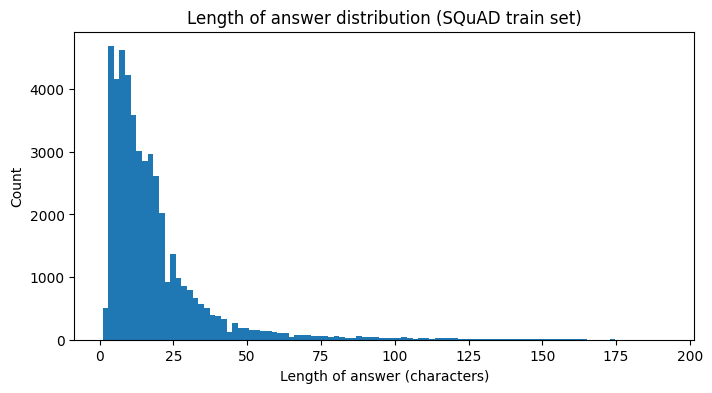

Length of answer statistics for SQuAD train set:
count    46168.000000
mean        18.418818
std         18.767818
min          1.000000
25%          7.000000
50%         13.000000
75%         22.000000
max        192.000000
Name: ans_len, dtype: float64


In [206]:
plt.figure(figsize=(8, 4))
plt.hist(train_df['ans_len'], bins=100)
plt.title("Length of answer distribution (SQuAD train set)")
plt.xlabel("Length of answer (characters)")
plt.ylabel("Count")
plt.show()
print("Length of answer statistics for SQuAD train set:")
print(train_df['ans_len'].describe())

In [207]:
# Entries with answer length < 2 characters
train_df[train_df['ans_len'] < 2]

,id,context,question,answer_start,answer_text,ans_len
1065,56cf3727aab44d1400b88e79,Bond y Swann regresan a Londres donde conocen ...,¿Quién impide que Nueve Ojos entre en línea?,64,Q,1
5624,56e042487aa994140058e409,"En el Alfabeto Fonético Internacional (IPA), l...",¿Qué modificador indica una parada bilabial so...,40,P,1
5629,56e045d2231d4119001ac02a,Las consonantes no aspiradas o tenuis se marca...,¿Cómo se dejan sin marcar consonantes no aspir...,239,T,1
6556,56e1753fcd28a01900c6796a,Con casi un tercio de los bostonianos utilizan...,El MBTA también se conoce como el qué?,209,t,1
6751,56e1cd44e3433e140042319d,"En la inflexión de género, la característica m...",¿Cuál es el sufijo masculino habitual?,135,o,1
7026,56e6eb396fe0821900b8ec26,"Nanjing (escucha; China: 南., ""Capital del Sur""...",N,0,N,1
7027,56e6eb396fe0821900b8ec27,"Nanjing (escucha; China: 南., ""Capital del Sur""...",B,290,b,1
7028,56e6eb396fe0821900b8ec28,"Nanjing (escucha; China: 南., ""Capital del Sur""...",V,206,v,1
12479,570725049e06ca38007e9495,Debido a la inestabilidad general del gobierno...,¿Quién encabezó ahora las autoridades civiles ...,638,J,1
13090,5709a8ad200fba1400368223,El censo de 1850 vio un cambio dramático en la...,"En el censo de 1850, ¿qué fue puesto en la col...",373,b,1


We have found several single character answers that are not valid.  
As it was confirmed in the cleaning process that the train split from SQuAD has no instances of multiple answers, we will directly flagged the id's for removal.

In [208]:
train_df_flagged.add("56e045d2231d4119001ac02a")
train_df_flagged.add("56e1753fcd28a01900c6796a")
train_df_flagged.add("56e6eb396fe0821900b8ec26")
train_df_flagged.add("56e6eb396fe0821900b8ec27")
train_df_flagged.add("56e6eb396fe0821900b8ec28")
train_df_flagged.add("570725049e06ca38007e9495")
train_df_flagged.add("57267d7fdd62a815002e8706")
train_df_flagged.add("572765a95951b619008f896d")
train_df_flagged.add("57280742ff5b5019007d9b3d")
train_df_flagged.add("572909d51d04691400778fb9")
train_df_flagged.add("57291ce0af94a219006aa089")
train_df_flagged.add("572947453f37b319004781f9")
train_df_flagged.add("5730409004bcaa1900d77415")
train_df_flagged.add("5731933a05b4da19006bd2d4")

In [209]:
# Entries with answer length > 175 characters
train_df[train_df['ans_len'] > 175]

,id,context,question,answer_start,answer_text,ans_len
1629,56d09a0e234ae51400d9c3c3,"En 2011, un informe de la Agencia Internaciona...",¿Qué podría hacer la energía del sol para ayud...,333,podría desempeñar un papel clave en la descarb...,186
17006,57101326a58dae1900cd6866,La Asociación Americana de Psicología afirma q...,¿Cuáles son las etiquetas más usadas en Estado...,405,las lesbianas (mujeres atraídas por las mujere...,181
20334,57265208dd62a815002e8176,Se han ideado muchos partidos especializados m...,¿Cómo se gana un partido de escalera?,317,el luchador o equipo de luchadores deben trata...,176
20693,5726618d5951b619008f7100,Las aves de corral están disponibles frescas o...,¿Cuál es la parte más sustancial de una antomí...,182,Las partes más escasas de un ave son los múscu...,180
21185,5726738e5951b619008f7300,El censo de 2010 dio al estado dos escaños más...,Lo que fue desafiado en 2012,79,"La redistribución de la legislatura, anunciada...",182
21186,5726738e5951b619008f7301,El censo de 2010 dio al estado dos escaños más...,¿Cómo gobernó la Corte Suprema de Florida sobr...,272,la Corte Suprema de Florida dictaminó en apela...,185
22691,5726aabcf1498d1400e8e686,El crecimiento de la población es mayor que el...,Qué es la tasa de crecimiento de la población ...,0,El crecimiento de la población es mayor que el...,182
24435,5726e1ce708984140094d4a4,La principal estación de autobuses local y reg...,Lo que es una de las Europas más limpias,617,La flota de autobuses local es una de las más ...,192
37958,572faf0e04bcaa1900d76be7,La Era Espacial es un período que abarca las a...,¿Cuál es la edad espacial?,19,un período que abarca las actividades relacion...,185
38203,572fc92904bcaa1900d76d31,La Football Association Premier League Ltd (FA...,¿Por qué John Quinton y Peter Leaver renunciar...,539,"John Quinton y Peter Leaver, se vieron obligad...",177


No issues found within the longest answers of the SQuAD train split.  

We will continue with the SQuAD validation split:

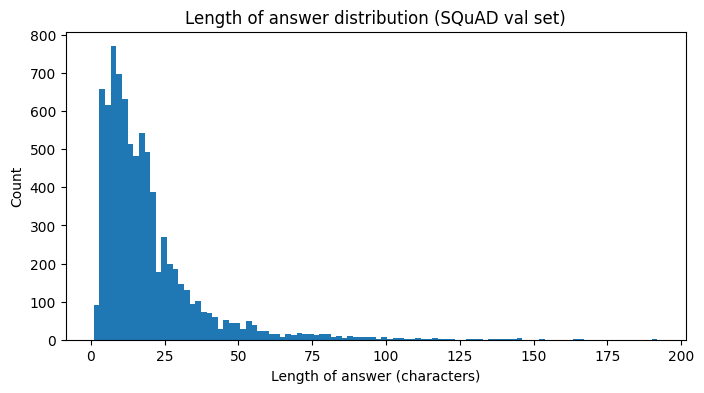

Length of answer statistics for SQuAD val set:
count    7997.000000
mean       19.206703
std        17.858398
min         1.000000
25%         8.000000
50%        15.000000
75%        23.000000
max       192.000000
Name: ans_len, dtype: float64


In [210]:
plt.figure(figsize=(8, 4))
plt.hist(val_df['ans_len'], bins=100)
plt.title("Length of answer distribution (SQuAD val set)")
plt.xlabel("Length of answer (characters)")
plt.ylabel("Count")
plt.show()
print("Length of answer statistics for SQuAD val set:")
print(val_df['ans_len'].describe())

In [211]:
# Entries with answer length < 2 characters
val_df[val_df['ans_len'] < 2]

,id,context,question,answer_start,answer_text,ans_len
26,56beace93aeaaa14008c91e2,El Super Bowl 50 fue un partido de fútbol amer...,"Si se usaran números romanos, ¿cómo se llamarí...",652,l,1
79,56bebbbf3aeaaa14008c9316,"El 4 de junio de 2014, la NFL anunció que la p...",¿Cuál fue el primer Super Bowl marcado con núm...,153,V,1
81,56bebbbf3aeaaa14008c9318,"El 4 de junio de 2014, la NFL anunció que la p...",¿Cuál fue el primer Super Bowl en usar la plan...,153,V,1
188,56bf4e1b3aeaaa14008c95c0,"El 4 de junio de 2014, la NFL anunció que la p...",Si se usaban números romanos en el nombramient...,23,l,1
188,56bf4e1b3aeaaa14008c95c0,"El 4 de junio de 2014, la NFL anunció que la p...",Si se usaban números romanos en el nombramient...,77,l,1
272,56d70daa0d65d21400198334,"El 4 de junio de 2014, la NFL anunció que la p...",¿Cuál es el número romano para 50?,77,l,1
876,56e1c2eee3433e1400423138,Pero limitar el tiempo de cálculo anterior por...,Los problemas de decisión capaces de ser resue...,674,p,1
895,56e1d9fee3433e14004231cc,"Si un problema X está en C y es duro para C, e...",Los problemas completos de NP contienen la men...,302,p,1
896,56e1dc62cd28a01900c67bca,La clase de complejidad P es a menudo vista co...,¿Qué clase de complejidad se caracteriza por t...,15,p,1
915,56e1f10ee3433e1400423222,"Del mismo modo, no se sabe si L (el conjunto d...",¿Qué variable se asocia con todos los problema...,30,L,1


We found a single-character instance (id **56e1d9fee3433e14004231cc**) which was wrong (not the correct answer for the question), mas well as two instances where the answer was a punctuation sign (id **5730b7ce069b5314008322c4** and id **57340d124776f419006617bf**).  

Because the validation split of SQuAD does have multiple answers for some questions, we will check if there are multiple answers for those entries, and in that case if there are valid answers those id's will be saved to a different set in order to remove only the wrong answer without unnecessarily removing the full QA entry.

In [212]:
val_df[val_df['id'] == "56e1d9fee3433e14004231cc"]

,id,context,question,answer_start,answer_text,ans_len
895,56e1d9fee3433e14004231cc,"Si un problema X está en C y es duro para C, e...",Los problemas completos de NP contienen la men...,302,p,1


In [213]:
val_df[val_df['id'] == "5730b7ce069b5314008322c4"]

,id,context,question,answer_start,answer_text,ans_len
6018,5730b7ce069b5314008322c4,Los primeros Estados Unidos expresaron su opos...,¿Cómo se llamaba la política imperialista de T...,272,intervencionismo,16
6018,5730b7ce069b5314008322c4,Los primeros Estados Unidos expresaron su opos...,¿Cómo se llamaba la política imperialista de T...,1293,.,1


In [214]:
val_df[val_df['id'] == "57340d124776f419006617bf"]

,id,context,question,answer_start,answer_text,ans_len
6376,57340d124776f419006617bf,"Para muchas poblaciones nativas, la eliminació...",¿Qué significaba la pérdida para Francia?,36,eliminación del poder francés,29
6376,57340d124776f419006617bf,"Para muchas poblaciones nativas, la eliminació...",¿Qué significaba la pérdida para Francia?,907,.,1


In [215]:
val_df_flagged.add("56e1d9fee3433e14004231cc")
val_df_single_answer_flagged = ("5730b7ce069b5314008322c4", "57340d124776f419006617bf")

In [216]:
# Entries with answer length > 150 characters
val_df[val_df['ans_len'] > 150]

,id,context,question,answer_start,answer_text,ans_len
2215,5725be0f271a42140099d11b,Después del evento de extinción Cretácico-Pale...,¿La selva tropical logró prosperar durante los...,599,"Sin embargo, la selva tropical todavía logró p...",167
2502,5726398589a1e219009ac589,La transmisión orientada a la conexión requier...,Qué es un identificador de conexión,214,un identificador de conexión en lugar de infor...,164
3059,57269bb8708984140094cb98,Aunque generalmente se acepta que la ley de la...,¿Cuáles son las regulaciones de la UE esencial...,1357,Las regulaciones de la UE son las mismas que l...,192
3074,57269e3bf1498d1400e8e517,"En primer lugar, si no se cumple la fecha lími...",¿Qué pasa en segundo lugar si no se cumple la ...,602,un ciudadano o compañía puede invocar una Dire...,152
6301,5733db8dd058e614000b642a,La expedición de Céloron consistía en unos 200...,¿Cómo manejó Celeron los negocios de viaje?,568,Cuando se encontró con comerciantes británicos...,166
6301,5733db8dd058e614000b642a,La expedición de Céloron consistía en unos 200...,¿Cómo manejó Celeron los negocios de viaje?,568,Cuando se encontró con comerciantes británicos...,165


No issues found on the longest answers of the SQuAD val split.  

We will move on to MLQA next:  

_Note: Regardless of our findings, no modifications will be done to the test sets (MLQA and XQuAD) in order to be able to compare our results with available benchmark scores._

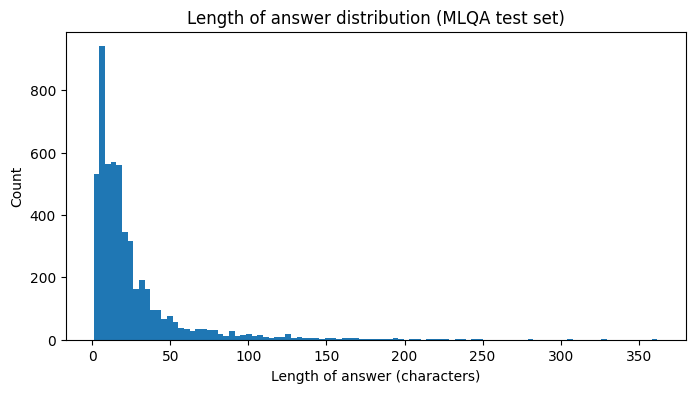

Length of answer statistics for MLQA test set:
count    5253.000000
mean       25.257948
std        31.327586
min         1.000000
25%         8.000000
50%        16.000000
75%        28.000000
max       362.000000
Name: ans_len, dtype: float64


In [217]:
plt.figure(figsize=(8, 4))
plt.hist(test1_df['ans_len'], bins=100)
plt.title("Length of answer distribution (MLQA test set)")
plt.xlabel("Length of answer (characters)")
plt.ylabel("Count")
plt.show()
print("Length of answer statistics for MLQA test set:")
print(test1_df['ans_len'].describe())

In [218]:
# Entries with answer length < 2 characters
test1_df[test1_df['ans_len'] < 2]

,id,context,question,answer_start,answer_text,ans_len
96,049c1d3798bb1118c0627811d08a847d72061069,"[…] cerca de un año atrás, existían dos versio...",¿Cuántas versiones de MIXIX había?,111,2,1
463,15f2354e66bae6eb030ecc20ad5a93b6e5c17ebb,Grand Theft Auto V recibió elogios por parte d...,¿Qué número romano contiene el nombre del juego?,17,V,1
859,28d8e063b765b577f0033f5b9ce038bff2ce5d42,En los Juegos Olímpicos de Invierno Marruecos ...,¿Cuántas veces ha estado Marruecos en los Jueg...,64,7,1
933,2c50e3748c5c844b482ffe4ca3ac1eddc1625b2d,{\displaystyle {\dot {\mathbf {x} }}(t)=A(t)\m...,¿Qué letra está entre ()?,10,t,1
989,2f5e8dc1eb39aefaca783ec40f1cd5f9223dae39,WWF/E World Tag Team Championship (5 veces) — ...,¿Cuántos campeonatos de equipo de equipos de e...,76,1,1
1174,38c4b717ff3d59e9b6826d4c2ff1fbc684df2e19,ECW World Tag Team Championship (1 vez) — con ...,Cuántas veces ganó Dean Malenko el título ECW ...,33,1,1
1951,60e6618ab6cb2a31bd20c7ed9e38a60d49ed0dca,Este haplogrupo es característico de todo Eura...,¿Cúantos haplogrupos de B4d hay?,191,5,1
2781,8933f5c80480fda84e1953560d10e4bde9b89806,"Cada cilindro cuenta con 4 válvulas, y la conf...",¿Cuántas válvulas tiene cada cilindro?,25,4,1
3308,a2988b361db81122e0d288e675a319069e03f638,"Posee 3 puertas, como en la mayoría de las cat...",¿Cuántas entradas grandes tiene una catedral?,6,3,1
3353,a4887b0906c227c84983b3438d600b69edc3d489,Tiene un valor de 7 en el sistema de numeració...,¿Qué valor tiene Zeta?,18,7,1


We can see on the single character answers a couple instances of translation mistakes in the question, and one instance (id **f0787be4ad000519073ce4cff1112904db953044**) where while the answer given is contained in the context, it is a wrong answer and the correct one does not appear in the context. But as mentioned before, no action will be taken on the test sets.

In [219]:
# Entries with answer length > 250 characters
test1_df[test1_df['ans_len'] > 250]

,id,context,question,answer_start,answer_text,ans_len
104,04ecd5555635bc05fd2f379d1b9027edd663cebf,"En 1994, cinco contratistas civiles anónimos y...",¿De qué se trataba la demanda contra Groom?,1044,la Fuerza Aérea de los Estados Unidos ha manip...,327
2938,904cde5c56b4227c6da34618846f86a42f8dbfc8,"Hacia 1983, los F-4N habían sido completamente...",¿Quién fue el último combatiente de la Reserva...,151,"El 25 de marzo de 1986, un F-4S del escuadrón ...",362
3846,bef140b872ffb43b39a20d5ebc98b31ba1e19a29,Se comercializan como: Green Apple Twist (manz...,¿Cuáles son los sabores?,23,Green Apple Twist (manzana verde) y Orange Twi...,307
4343,d6a6767f65b7cee382dc81a5172b8ff0c62fb35f,La Secretaría del ICCROM consiste en el Direct...,¿En qué departamentos se distribuyen los emple...,247,"patrimonio inmueble (monumentos, sitios arqueo...",280
4578,e1c51f1f0824cc1de737346f89cc40f8d381f172,En esta etapa se vuelven más notorios los camb...,¿Cuáles son algunos de los efectos secundarios...,158,episodios de confusión al final del día (agrav...,280


No issues found on the longest answers of MLQA.  

Finally, we will repeat the same analysis for XQuAD.  

_Note: Regardless of our findings, no modifications will be done to the test sets (MLQA and XQuAD) in order to be able to compare our results with available benchmark scores._

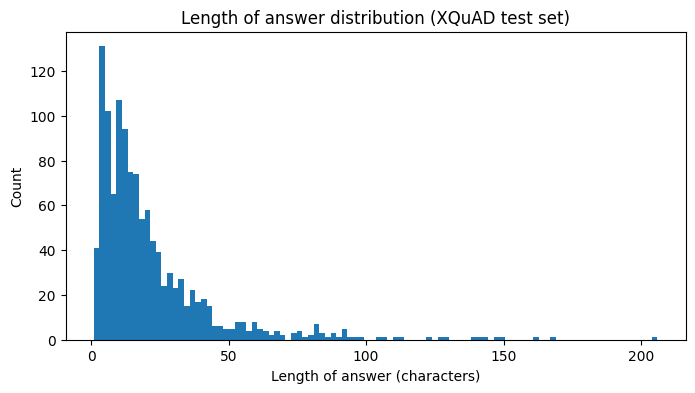

Length of answer statistics for XQuAD test set:
count    1190.000000
mean       21.531092
std        21.991518
min         1.000000
25%         8.000000
50%        15.000000
75%        26.000000
max       206.000000
Name: ans_len, dtype: float64


In [220]:
plt.figure(figsize=(8, 4))
plt.hist(test2_df['ans_len'], bins=100)
plt.title("Length of answer distribution (XQuAD test set)")
plt.xlabel("Length of answer (characters)")
plt.ylabel("Count")
plt.show()
print("Length of answer statistics for XQuAD test set:")
print(test2_df['ans_len'].describe())

In [221]:
# Entries with answer length < 2 characters
test2_df[test2_df['ans_len'] < 2]

,id,context,question,answer_start,answer_text,ans_len
59,56d9992fdc89441400fdb5a0,"﻿Los Panthers, que además de liderar las inter...",¿Con cuántas intercepciones Josh Norman consig...,306,2,1
246,570d47b8b3d812140066d631,También hay varios pequeños operadores de merc...,¿Cuántas líneas de ferrocarril de trocha angos...,538,5,1
291,57115bf350c2381900b54a95,Aunque la máquina de vapor de pistón ya no es ...,¿Cuántos cilindros tiene el motor Energiprojek...,460,5,1


We can see that among the three single character answers, one (id **56d9992fdc89441400fdb5a0**) is wrong, answer should be 4 not 2.  

In [222]:
# Entries with answer length > 150 characters
test2_df[test2_df['ans_len'] > 150]

,id,context,question,answer_start,answer_text,ans_len
419,5726414e271a42140099d7e6,"Merit Network, Inc., una corporación independi...",¿Qué completó la tríada?,632,se estableció una conexión interactiva de serv...,206
425,5726472bdd62a815002e8042,Internet2 es un consorcio de redes informática...,¿Qué es Internet2?,13,un consorcio de redes informáticas sin fines d...,169
653,57273f27dd62a815002e9a0d,La Clasificación Industrial Estándar y el nuev...,¿Qué son los directores de construcción?,582,empresas que se dedican a la gestión de proyec...,161


No issues found within the longest answers of XQuAD.

In [223]:
train_df.drop(['ans_len'], axis=1, inplace=True)
val_df.drop(['ans_len'], axis=1, inplace=True)
test1_df.drop(['ans_len'], axis=1, inplace=True)
test2_df.drop(['ans_len'], axis=1, inplace=True)

train_df = unexplode_answers(train_df)
val_df = unexplode_answers(val_df)
test1_df = unexplode_answers(test1_df)
test2_df = unexplode_answers(test2_df)

## 6.4 Number of Questions per Context

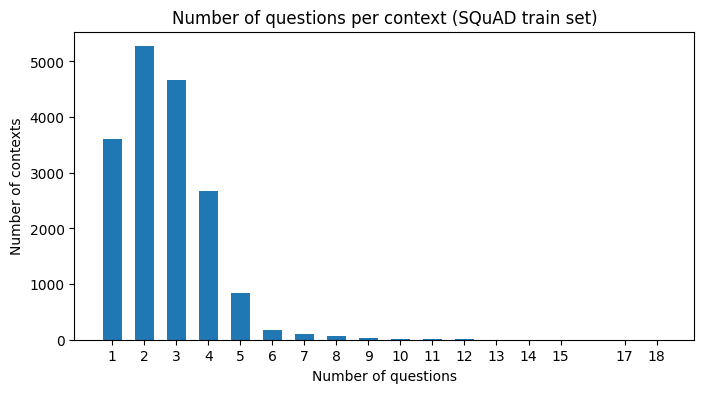

Counts of contexts by number of questions for SQuAD train set:
Total unique contexts: 17478
Number of questions: 1, Count: 3603, Percentage: 20.61%
Number of questions: 2, Count: 5270, Percentage: 30.15%
Number of questions: 3, Count: 4671, Percentage: 26.73%
Number of questions: 4, Count: 2673, Percentage: 15.29%
Number of questions: 5, Count: 848, Percentage: 4.85%
Number of questions: 6, Count: 168, Percentage: 0.96%
Number of questions: 7, Count: 97, Percentage: 0.55%
Number of questions: 8, Count: 66, Percentage: 0.38%
Number of questions: 9, Count: 39, Percentage: 0.22%
Number of questions: 10, Count: 14, Percentage: 0.08%
Number of questions: 11, Count: 11, Percentage: 0.06%
Number of questions: 12, Count: 10, Percentage: 0.06%
Number of questions: 13, Count: 3, Percentage: 0.02%
Number of questions: 14, Count: 1, Percentage: 0.01%
Number of questions: 15, Count: 2, Percentage: 0.01%
Number of questions: 17, Count: 1, Percentage: 0.01%
Number of questions: 18, Count: 1, Percenta

In [224]:
qst_per_ctx = train_df.groupby('context')['question'].nunique().value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.bar(qst_per_ctx.index, qst_per_ctx.values, width=0.6)
plt.title("Number of questions per context (SQuAD train set)")
plt.xlabel("Number of questions")
plt.ylabel("Number of contexts")
plt.xticks(qst_per_ctx.index)
plt.show()

print("Counts of contexts by number of questions for SQuAD train set:")
print(f'Total unique contexts: {train_df["context"].nunique()}')
for i in qst_per_ctx.index:
    print(f'Number of questions: {i}, Count: {qst_per_ctx[i]}, Percentage: {100 * qst_per_ctx[i] / qst_per_ctx.values.sum():.2f}%')

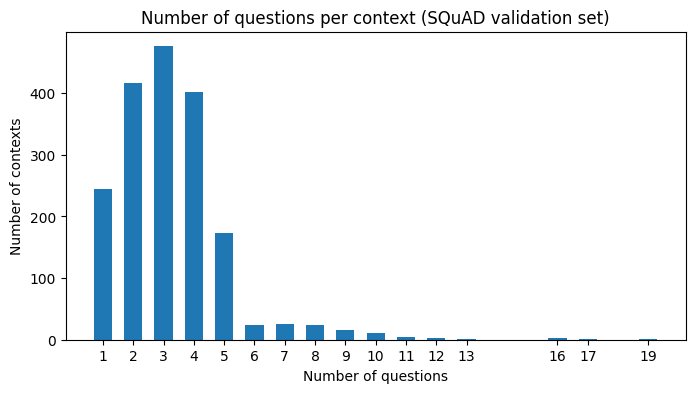

Counts of contexts by number of questions for SQuAD validation set:
Total unique contexts: 1825
Number of questions: 1, Count: 245, Percentage: 13.42%
Number of questions: 2, Count: 417, Percentage: 22.85%
Number of questions: 3, Count: 476, Percentage: 26.08%
Number of questions: 4, Count: 402, Percentage: 22.03%
Number of questions: 5, Count: 173, Percentage: 9.48%
Number of questions: 6, Count: 24, Percentage: 1.32%
Number of questions: 7, Count: 26, Percentage: 1.42%
Number of questions: 8, Count: 24, Percentage: 1.32%
Number of questions: 9, Count: 15, Percentage: 0.82%
Number of questions: 10, Count: 11, Percentage: 0.60%
Number of questions: 11, Count: 4, Percentage: 0.22%
Number of questions: 12, Count: 3, Percentage: 0.16%
Number of questions: 13, Count: 1, Percentage: 0.05%
Number of questions: 16, Count: 2, Percentage: 0.11%
Number of questions: 17, Count: 1, Percentage: 0.05%
Number of questions: 19, Count: 1, Percentage: 0.05%


In [225]:
qst_per_ctx = val_df.groupby('context')['question'].nunique().value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.bar(qst_per_ctx.index, qst_per_ctx.values, width=0.6)
plt.title("Number of questions per context (SQuAD validation set)")
plt.xlabel("Number of questions")
plt.ylabel("Number of contexts")
plt.xticks(qst_per_ctx.index)
plt.show()

print("Counts of contexts by number of questions for SQuAD validation set:")
print(f'Total unique contexts: {val_df["context"].nunique()}')
for i in qst_per_ctx.index:
    print(f'Number of questions: {i}, Count: {qst_per_ctx[i]}, Percentage: {100 * qst_per_ctx[i] / qst_per_ctx.values.sum():.2f}%')

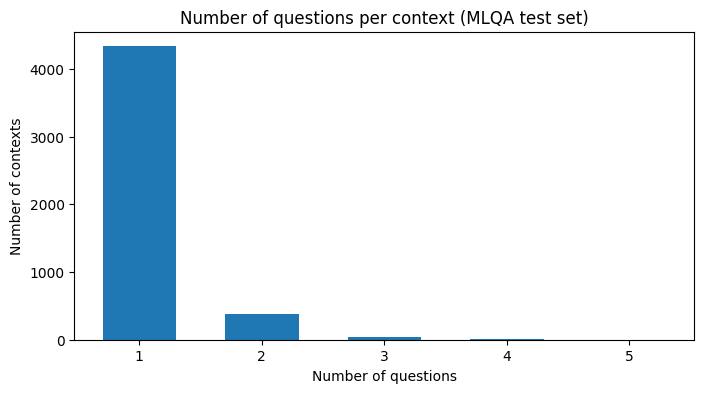

Counts of contexts by number of questions for MLQA test set:
Total unique contexts: 4761
Number of questions: 1, Count: 4333, Percentage: 91.01%
Number of questions: 2, Count: 374, Percentage: 7.86%
Number of questions: 3, Count: 45, Percentage: 0.95%
Number of questions: 4, Count: 8, Percentage: 0.17%
Number of questions: 5, Count: 1, Percentage: 0.02%


In [226]:
qst_per_ctx = test1_df.groupby('context')['question'].nunique().value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.bar(qst_per_ctx.index, qst_per_ctx.values, width=0.6)
plt.title("Number of questions per context (MLQA test set)")
plt.xlabel("Number of questions")
plt.ylabel("Number of contexts")
plt.xticks(qst_per_ctx.index)
plt.show()

print("Counts of contexts by number of questions for MLQA test set:")
print(f'Total unique contexts: {test1_df["context"].nunique()}')
for i in qst_per_ctx.index:
    print(f'Number of questions: {i}, Count: {qst_per_ctx[i]}, Percentage: {100 * qst_per_ctx[i] / qst_per_ctx.values.sum():.2f}%')

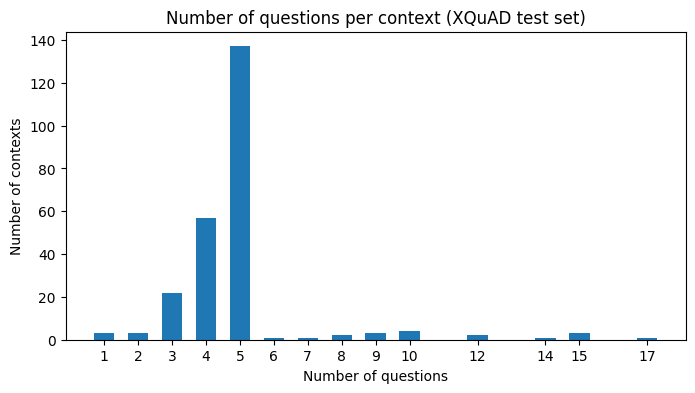

Counts of contexts by number of questions for XQuAD test set:
Total unique contexts: 240
Number of questions: 1, Count: 3, Percentage: 1.25%
Number of questions: 2, Count: 3, Percentage: 1.25%
Number of questions: 3, Count: 22, Percentage: 9.17%
Number of questions: 4, Count: 57, Percentage: 23.75%
Number of questions: 5, Count: 137, Percentage: 57.08%
Number of questions: 6, Count: 1, Percentage: 0.42%
Number of questions: 7, Count: 1, Percentage: 0.42%
Number of questions: 8, Count: 2, Percentage: 0.83%
Number of questions: 9, Count: 3, Percentage: 1.25%
Number of questions: 10, Count: 4, Percentage: 1.67%
Number of questions: 12, Count: 2, Percentage: 0.83%
Number of questions: 14, Count: 1, Percentage: 0.42%
Number of questions: 15, Count: 3, Percentage: 1.25%
Number of questions: 17, Count: 1, Percentage: 0.42%


In [227]:
qst_per_ctx = test2_df.groupby('context')['question'].nunique().value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.bar(qst_per_ctx.index, qst_per_ctx.values, width=0.6)
plt.title("Number of questions per context (XQuAD test set)")
plt.xlabel("Number of questions")
plt.ylabel("Number of contexts")
plt.xticks(qst_per_ctx.index)
plt.show()

print("Counts of contexts by number of questions for XQuAD test set:")
print(f'Total unique contexts: {test2_df["context"].nunique()}')
for i in qst_per_ctx.index:
    print(f'Number of questions: {i}, Count: {qst_per_ctx[i]}, Percentage: {100 * qst_per_ctx[i] / qst_per_ctx.values.sum():.2f}%')

## 6.5 Number of Answers per Question

In [228]:
train_df = explode_answers_dict(train_df)
val_df = explode_answers_dict(val_df)
test1_df = explode_answers_dict(test1_df)
test2_df = explode_answers_dict(test2_df)

train_df['num_answers'] = train_df['answer_start'].apply(lambda x: len(x))
val_df['num_answers'] = val_df['answer_start'].apply(lambda x: len(x))
test1_df['num_answers'] = test1_df['answer_start'].apply(lambda x: len(x))
test2_df['num_answers'] = test2_df['answer_start'].apply(lambda x: len(x))

In [229]:
max_answers = max(train_df['num_answers'].max(), val_df['num_answers'].max(), test1_df['num_answers'].max(), test2_df['num_answers'].max())

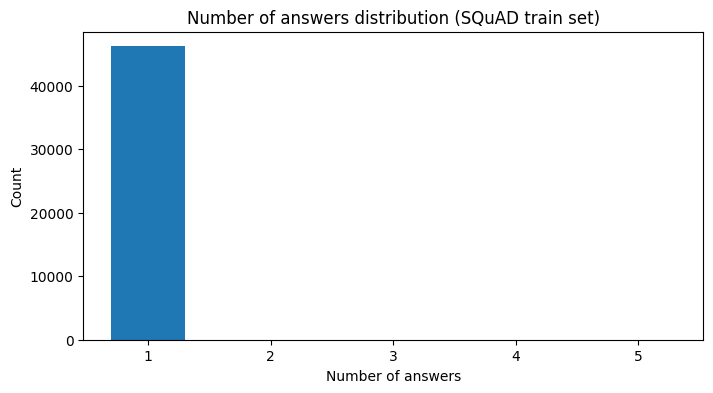

Counts of entries by number of answers for SQuAD train set:
Total entries: 46168
Number of answers: 1, Count: 46168, Percentage: 100.00%


In [230]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, max_answers + 1), train_df['num_answers'].value_counts().reindex(np.arange(1, max_answers + 1), fill_value=0).values, width=0.6)
plt.title("Number of answers distribution (SQuAD train set)")
plt.xlabel("Number of answers")
plt.ylabel("Count")
plt.show()
print("Counts of entries by number of answers for SQuAD train set:")
print(f'Total entries: {len(train_df)}')
for i in range(1, train_df['num_answers'].max() + 1):
    count = len(train_df[train_df['num_answers'] == i])
    print(f'Number of answers: {i}, Count: {count}, Percentage: {100 * count / len(train_df):.2f}%')

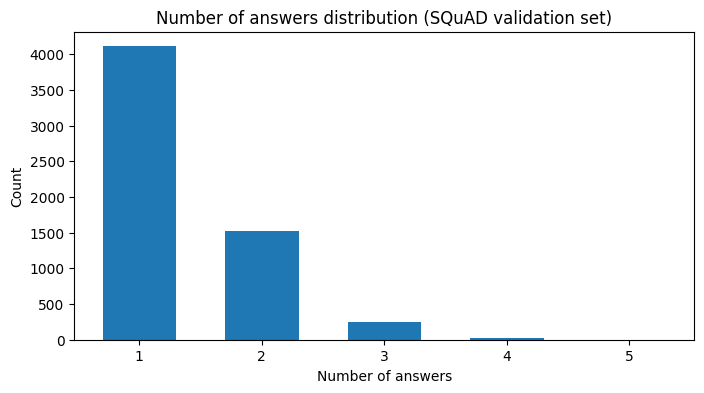

Counts of entries by number of answers for SQuAD validation set:
Total entries: 5904
Number of answers: 1, Count: 4109, Percentage: 69.60%
Number of answers: 2, Count: 1522, Percentage: 25.78%
Number of answers: 3, Count: 251, Percentage: 4.25%
Number of answers: 4, Count: 19, Percentage: 0.32%
Number of answers: 5, Count: 3, Percentage: 0.05%


In [231]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, max_answers + 1), val_df['num_answers'].value_counts().reindex(np.arange(1, max_answers + 1), fill_value=0).values, width=0.6)
plt.title("Number of answers distribution (SQuAD validation set)")
plt.xlabel("Number of answers")
plt.ylabel("Count")
plt.show()
print("Counts of entries by number of answers for SQuAD validation set:")
print(f'Total entries: {len(val_df)}')
for i in range(1, val_df['num_answers'].max() + 1):
    count = len(val_df[val_df['num_answers'] == i])
    print(f'Number of answers: {i}, Count: {count}, Percentage: {100 * count / len(val_df):.2f}%')

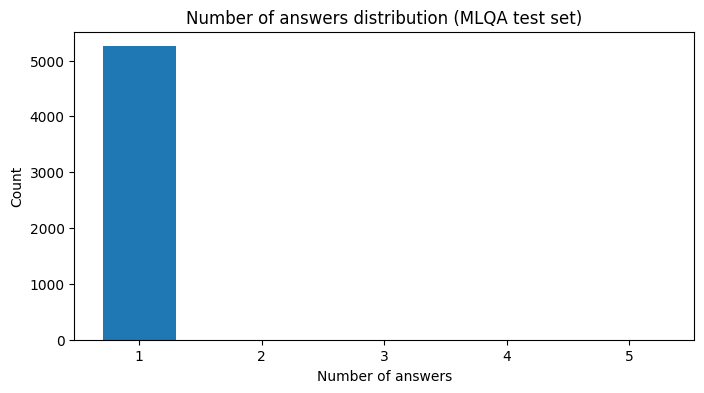

Counts of entries by number of answers for MLQA test set:
Total entries: 5253
Number of answers: 1, Count: 5253, Percentage: 100.00%


In [232]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, max_answers + 1), test1_df['num_answers'].value_counts().reindex(np.arange(1, max_answers + 1), fill_value=0).values, width=0.6)
plt.title("Number of answers distribution (MLQA test set)")
plt.xlabel("Number of answers")
plt.ylabel("Count")
plt.show()
print("Counts of entries by number of answers for MLQA test set:")
print(f'Total entries: {len(test1_df)}')
for i in range(1, test1_df['num_answers'].max() + 1):
    count = len(test1_df[test1_df['num_answers'] == i])
    print(f'Number of answers: {i}, Count: {count}, Percentage: {100 * count / len(test1_df):.2f}%')

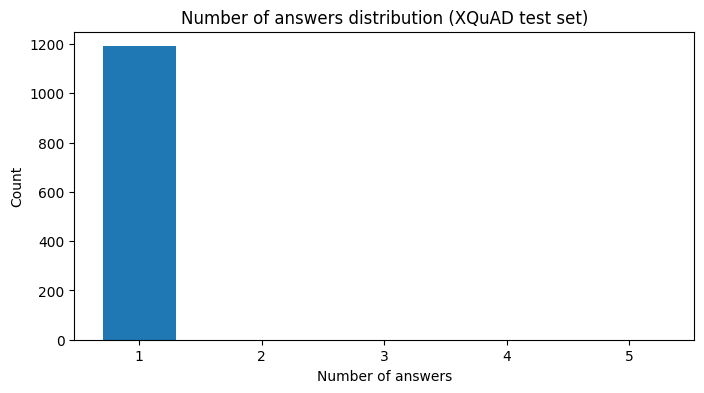

Counts of entries by number of answers for XQuAD test set:
Total entries: 1190
Number of answers: 1, Count: 1190, Percentage: 100.00%


In [233]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, max_answers + 1), test2_df['num_answers'].value_counts().reindex(np.arange(1, max_answers + 1), fill_value=0).values, width=0.6)
plt.title("Number of answers distribution (XQuAD test set)")
plt.xlabel("Number of answers")
plt.ylabel("Count")
plt.show()
print("Counts of entries by number of answers for XQuAD test set:")
print(f'Total entries: {len(test2_df)}')
for i in range(1, test2_df['num_answers'].max() + 1):
    count = len(test2_df[test2_df['num_answers'] == i])
    print(f'Number of answers: {i}, Count: {count}, Percentage: {100 * count / len(test2_df):.2f}%')

## 6.6 Flagged Entries Removal

During the exploration process we have manually flagged several entries in the SQuAD train and validation splits.  

We will proceed to remove them and do a final count of entries.

In [234]:
print(f'Number of flagged entries in SQuAD train set: {len(train_df_flagged)}')
print(f'Number of flagged entries in SQuAD val set: {len(val_df_flagged)}')
print(f'Number of IDs flagged for single answer removal in SQuAD val set: {len(val_df_single_answer_flagged)}')

Number of flagged entries in SQuAD train set: 19
Number of flagged entries in SQuAD val set: 5
Number of IDs flagged for single answer removal in SQuAD val set: 2


In [235]:
squad_train_df = squad_train_df[~squad_train_df['id'].isin(train_df_flagged)].copy()
squad_val_df = squad_val_df[~squad_val_df['id'].isin(val_df_flagged)].copy()

In [236]:
squad_val_df[squad_val_df['id'].isin(val_df_single_answer_flagged)]

,id,context,question,answers
6018,5730b7ce069b5314008322c4,Los primeros Estados Unidos expresaron su opos...,¿Cómo se llamaba la política imperialista de T...,"{'answer_start': [272, 1293], 'text': ['interv..."
6376,57340d124776f419006617bf,"Para muchas poblaciones nativas, la eliminació...",¿Qué significaba la pérdida para Francia?,"{'answer_start': [36, 907], 'text': ['eliminac..."


In [237]:
squad_val_df.loc[squad_val_df['id'] == "5730b7ce069b5314008322c4", 'answers'] = [{'answer_start': [272], 'text': ['intervencionismo']}]
squad_val_df.loc[squad_val_df['id'] == "57340d124776f419006617bf", 'answers'] = [{'answer_start': [36], 'text': ['eliminación del poder francés']}]

In [238]:
squad_val_df[squad_val_df['id'].isin(val_df_single_answer_flagged)]

,id,context,question,answers
6018,5730b7ce069b5314008322c4,Los primeros Estados Unidos expresaron su opos...,¿Cómo se llamaba la política imperialista de T...,"{'answer_start': [272], 'text': ['intervencion..."
6376,57340d124776f419006617bf,"Para muchas poblaciones nativas, la eliminació...",¿Qué significaba la pérdida para Francia?,"{'answer_start': [36], 'text': ['eliminación d..."


# 7. Summary

After a fairly thorough process of cleaning, exploration and analysis, this is the final number of samples available per dataset:

In [239]:
print('------------- SQuAD Train Set Cleaning Summary -------------')
print('Original number of entries:', original_squad_train_len)
print(f'Final number of entries: {len(squad_train_df)}, removed {100 * (original_squad_train_len - len(squad_train_df)) / original_squad_train_len:.2f}% entries')
print('------------- SQuAD Val Set Cleaning Summary -------------')
print('Original number of entries:', original_squad_val_len)
print(f'Final number of entries: {len(squad_val_df)}, removed {100 * (original_squad_val_len - len(squad_val_df)) / original_squad_val_len:.2f}% entries')
print('------------- MLQA Test Set Cleaning Summary -------------')
print('Original number of entries:', original_mlqa_test_len)
print(f'Final number of entries: {len(mlqa_test_df)}, removed {100 * (original_mlqa_test_len - len(mlqa_test_df)) / original_mlqa_test_len:.2f}% entries')
print('------------- XQuAD Test Set Cleaning Summary -------------')
print('Original number of entries:', original_xquad_test_len)
print(f'Final number of entries: {len(xquad_test_df)}, removed {100 * (original_xquad_test_len - len(xquad_test_df)) / original_xquad_test_len:.2f}% entries')

------------- SQuAD Train Set Cleaning Summary -------------
Original number of entries: 46260
Final number of entries: 46149, removed 0.24% entries
------------- SQuAD Val Set Cleaning Summary -------------
Original number of entries: 6583
Final number of entries: 5899, removed 10.39% entries
------------- MLQA Test Set Cleaning Summary -------------
Original number of entries: 5253
Final number of entries: 5253, removed 0.00% entries
------------- XQuAD Test Set Cleaning Summary -------------
Original number of entries: 1190
Final number of entries: 1190, removed 0.00% entries


Before exporting, we will review the format and content of the datasets to validate everything is as we expected:

In [240]:
squad_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46149 entries, 0 to 46175
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46149 non-null  object
 1   context   46149 non-null  object
 2   question  46149 non-null  object
 3   answers   46149 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [241]:
squad_train_df.head(1)

,id,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé Giselle Knowles-Carter (nacida el 4 de...,¿Cuándo Beyonce comenzó a ser popular?,"{'answer_start': [246], 'text': ['a finales de..."


In [242]:
squad_val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5899 entries, 0 to 6552
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5899 non-null   object
 1   context   5899 non-null   object
 2   question  5899 non-null   object
 3   answers   5899 non-null   object
dtypes: object(4)
memory usage: 230.4+ KB


In [243]:
squad_val_df.head(1)

,id,context,question,answers
0,56be4db0acb8001400a502ec,El Super Bowl 50 fue un partido de fútbol amer...,¿Qué equipo de la NFL representó a la AFC en e...,"{'answer_start': [165], 'text': ['Denver Bronc..."


In [244]:
mlqa_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5253 entries, 0 to 5252
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5253 non-null   object
 1   context   5253 non-null   object
 2   question  5253 non-null   object
 3   answers   5253 non-null   object
dtypes: object(4)
memory usage: 164.3+ KB


In [245]:
mlqa_test_df.head(1)

,id,context,question,answers
0,0004425bee3c039061dfb356ea5730e68b28d4cd,El estado y el Partido de los Trabajadores de ...,¿Quién controla la producción de literatura y ...,"{'answer_start': [0], 'text': ['El estado y el..."


In [246]:
xquad_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1190 non-null   object
 1   context   1190 non-null   object
 2   question  1190 non-null   object
 3   answers   1190 non-null   object
dtypes: object(4)
memory usage: 37.3+ KB


In [247]:
xquad_test_df.head(1)

,id,context,question,answers
0,56beb4343aeaaa14008c925b,"﻿Los Panthers, que además de liderar las inter...",¿Cuántos puntos dejaron escapar en defensa los...,"{'answer_start': [133], 'text': ['308']}"


# 8. Export Datasets

For full compatibility, we will convert the cleaned dataframes to HF Dataset format:

In [248]:
final_squad_train = Dataset.from_pandas(squad_train_df, preserve_index=False)
final_squad_val = Dataset.from_pandas(squad_val_df, preserve_index=False)
final_mlqa_test = Dataset.from_pandas(mlqa_test_df, preserve_index=False)
final_xquad_test = Dataset.from_pandas(xquad_test_df, preserve_index=False)

In [249]:
print(final_squad_train)
print(final_squad_train.features)
final_squad_train[0]

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 46149
})
{'id': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'answer_start': List(Value('int64')), 'text': List(Value('string'))}}


{'id': '56be85543aeaaa14008c9063',
 'context': 'Beyoncé Giselle Knowles-Carter (nacida el 4 de septiembre de 1981) es una cantante, compositora, productora y actriz estadounidense. Nacida y criada en Houston, Texas, actuó en varios concursos de canto y baile cuando era niña, y saltó a la fama a finales de 1990 como cantante del grupo femenino de R & B Destiny \'s Child. Dirigida por su padre, Mathew Knowles, el grupo se convirtió en uno de los grupos de chicas más vendidos de todos los tiempos. Su hiato vio el lanzamiento del álbum debut de Beyoncé, Dangerously in Love (2003), que la estableció como una artista en solitario en todo el mundo, ganó cinco premios Grammy y presentó el Billboard Hot 100 sencillos número uno "Crazy in Love" y ".',
 'question': '¿Cuándo Beyonce comenzó a ser popular?',
 'answers': {'answer_start': [246], 'text': ['a finales de 1990']}}

In [250]:
print(final_squad_val)
print(final_squad_val.features)
final_squad_val[0]

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 5899
})
{'id': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'answer_start': List(Value('int64')), 'text': List(Value('string'))}}


{'id': '56be4db0acb8001400a502ec',
 'context': 'El Super Bowl 50 fue un partido de fútbol americano para determinar al campeón de la NFL para la temporada 2015. El campeón de la American Football Conference (AFC) Denver Broncos derrotó al campeón de la National Football Conference (NFC) Carolina Panthers 24-10 para ganar su tercer título de Super Bowl. El partido se jugó el 7 de febrero de 2016 en el Levi \'s Stadium en la Bahía de San Francisco en Santa Clara, California. Como este fue el 50º Super Bowl, la liga enfatizó el "aniversario dorado" con varias iniciativas temáticas de oro, así como suspender temporalmente la tradición de nombrar cada juego de Super Bowl con números romanos (bajo los cuales el juego).',
 'question': '¿Qué equipo de la NFL representó a la AFC en el Super Bowl 50?',
 'answers': {'answer_start': [165], 'text': ['Denver Broncos']}}

In [251]:
print(final_mlqa_test)
print(final_mlqa_test.features)
final_mlqa_test[0]

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 5253
})
{'id': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'answer_start': List(Value('int64')), 'text': List(Value('string'))}}


{'id': '0004425bee3c039061dfb356ea5730e68b28d4cd',
 'context': 'El estado y el Partido de los Trabajadores de Corea (PTC) controlan la producción de literatura y arte. A inicios de los años 90, no existían evidencias de movimientos culturales o literarios clandestinos como los samizdat de la Unión Soviética o los que existen en la República Popular de China. El partido ejerce el control sobre la cultura a través de su Departamento de Propaganda y Agitación y el Departamento de Cultura y Artes del Comité Central del PTC.',
 'question': '¿Quién controla la producción de literatura y arte en Corea?',
 'answers': {'answer_start': [0],
  'text': ['El estado y el Partido de los Trabajadores de Corea (PTC)']}}

In [252]:
print(final_xquad_test)
print(final_xquad_test.features)
final_xquad_test[0]

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 1190
})
{'id': Value('string'), 'context': Value('string'), 'question': Value('string'), 'answers': {'answer_start': List(Value('int64')), 'text': List(Value('string'))}}


{'id': '56beb4343aeaaa14008c925b',
 'context': '\ufeffLos Panthers, que además de liderar las intercepciones de la NFL con 24 y contar con cuatro jugadores de la Pro Bowl, cedieron solo 308 puntos en defensa y se sitúan en el sexto lugar de la liga. Kawann Short, tacle defensivo de la Pro Bowl, lideró al equipo con 11 capturas, 3 balones sueltos forzados y 2 recuperaciones. A su vez, el liniero Mario Addison, consiguió 6 capturas y media. En la línea de los Panthers, también destacó como ala defensiva el veterano Jared Allen ―5 veces jugador de la Pro Bowl y que fue el líder, en activo, de capturas de la NFL con 136― junto con el también ala defensiva Kony Ealy, que lleva 5 capturas en solo 9 partidos como titular. Detrás de ellos, Thomas Davis y Luke Kuechly, dos de los tres apoyadores titulares que también han sido seleccionados para jugar la Pro Bowl. Davis se hizo con 5 capturas y media, 4 balones sueltos forzados y 4 intercepciones, mientras que Kuechly lideró al equipo en derribo

In [ ]:
squad_es_clean_train_path = squad_folder / 'clean_train-v1.1-es_small.json'
squad_es_clean_dev_path = squad_folder / 'clean_dev-v1.1-es_small.json'
mlqa_es_clean_test_path = mlqa_folder / 'clean_test-context-es-question-es.json'
xquad_es_clean_test_path = xquad_folder / 'clean_xquad-es.json'

final_squad_train.to_json(squad_es_clean_train_path, orient="records", lines=True, force_ascii=False)
final_squad_val.to_json(squad_es_clean_dev_path, orient="records", lines=True, force_ascii=False)
final_mlqa_test.to_json(mlqa_es_clean_test_path, orient="records", lines=True, force_ascii=False)
final_xquad_test.to_json(xquad_es_clean_test_path, orient="records", lines=True, force_ascii=False)

# 9. Citations & References

**Datasets:**
- SQuAD (original): [SQuAD: 100,000+ Questions for Machine Comprehension of Text](https://arxiv.org/abs/1606.05250) (Rajpurkar, Zhang, Lopyrev, Liang. EMNLP 2016)
- SQuAD (translation): [Automatic Spanish Translation of the SQuAD Dataset for Multilingual Question Answering](https://arxiv.org/abs/1912.05200) (Carrino, Costa-jussà, Fonollosa. arXiv 2019)
- MLQA: [MLQA: Evaluating Cross-lingual Extractive Question Answering](https://arxiv.org/abs/1910.07475) (Lewis, Oguz, Rinott, Riedel, Schwenk. arXiv 2019)
- XQuAD: [On the cross-lingual transferability of monolingual representations](https://arxiv.org/abs/1910.11856) (Artetxe, Ruder, Yogatama. arXiv 2019)
- PAWS: [PAWS: Paraphrase Adversaries from Word Scrambling](https://arxiv.org/abs/1904.01130) (Zhang, Baldridge, He. NAACL 2019)
- PAWS-X: [PAWS-X: A Cross-lingual Adversarial Dataset for Paraphrase Identification](https://arxiv.org/abs/1908.11828) (Yang, Zhang, Tar, Baldridge. EMNLP 2019)

**Sentence Transformers (sentence similarity):**  
- [SentenceTransformer](https://www.sbert.net/)
- [SentenceTransformer Pretrained Models Leaderboard](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084) (Reimers, Gurevich, EMNLP 2019)
- [MTEB: Massive Text Embedding Benchmark](https://arxiv.org/abs/2210.07316) (Muennighoff, Tazi1, Magne1, Reimers. arXiv 2022)

**Kaggle competition:**
- [Google Gemma Global Communication Comp Announcement](https://discuss.ai.google.dev/t/join-the-competition-unlock-global-communication-with-gemma/47814)
- [Kaggle Gemma Language Tuning Comp](https://www.kaggle.com/competitions/gemma-language-tuning)